# Anomaly Detection using AutoEncoders on Time Series Data
***
- Results documented as info graphs / plots and saved in ./plots directory
- [Future changes and experiments](#Changes-and-Experiements-working-upon) and [References](#References) mentioned after analysis and before Appendix 
- [Appendix](#Appendix) attached at the very end of the ipynb file
- [Functions](#Helper-Functions) documented with doc string and necessary comments 
- Link of [Dataset](#Dataset) - https://webscope.sandbox.yahoo.com/catalog.php?datatype=s&did=70

***

#### Necessary Library Imports

***

In [1]:
import glob
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

***

#### Dataset
#### [Yahoo! Webscope dataset ydata-labeled-time-series-anomalies-v1_0](https://webscope.sandbox.yahoo.com/catalog.php?datatype=s&did=70)

***

#### Selecting the follwoing timeseries for Anomaly Detection Analysis, rest of the data set visualized in the appendix (bottom) 
- **[Dataset 1](#Dataset-1) : ./datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_19.csv**
- **[Dataset 2](#Dataset-2) : ./datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_65.csv**
- **[Dataset 3](#Dataset-3) : ./datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_37.csv**
- **[Dataset 4](#Dataset-4) : ./datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_50.csv**
- **[Dataset 5](#Dataset-5) : ./datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_26.csv**
- **[Dataset 6](#Dataset-6) : ./datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_40.csv**

In [34]:
def plotter(file_list):
    """
    Plots Subplots in a 2x3 manner for a given set of data files
    """
    fig, ax = plt.subplots(2,3, figsize=(30,15), sharey=True); ax=ax.reshape(-1)
    i = 0
    for file in file_list:
        data = pd.read_csv(file)
        data.timestamp = data.index
        ct = ColumnTransformer([('scaler',StandardScaler(),['value'])], remainder='drop')
        data['scaled_value'] = ct.fit_transform(data)
        anomalies = data[data.is_anomaly > 0]
        _ = sns.lineplot(data=data, x='timestamp', y='scaled_value', ax=ax[i])
        _ = sns.scatterplot(data=anomalies, x='timestamp',y='scaled_value', color='r', marker='x', s= 200, ax=ax[i])        
        _ = ax[i].set_title('{}\nAnomaly Count - {}'.format('/'.join(file.split('/')[-2:]), anomalies.is_anomaly.sum()))
        _ = ax[i].set_xlabel('Over Time')
        _ = ax[i].set_xlabel('Scaled Value')
        i+=1
    plt.savefig('./plots/selected-dataset.png', transparent=False)
    plt.show(fig)

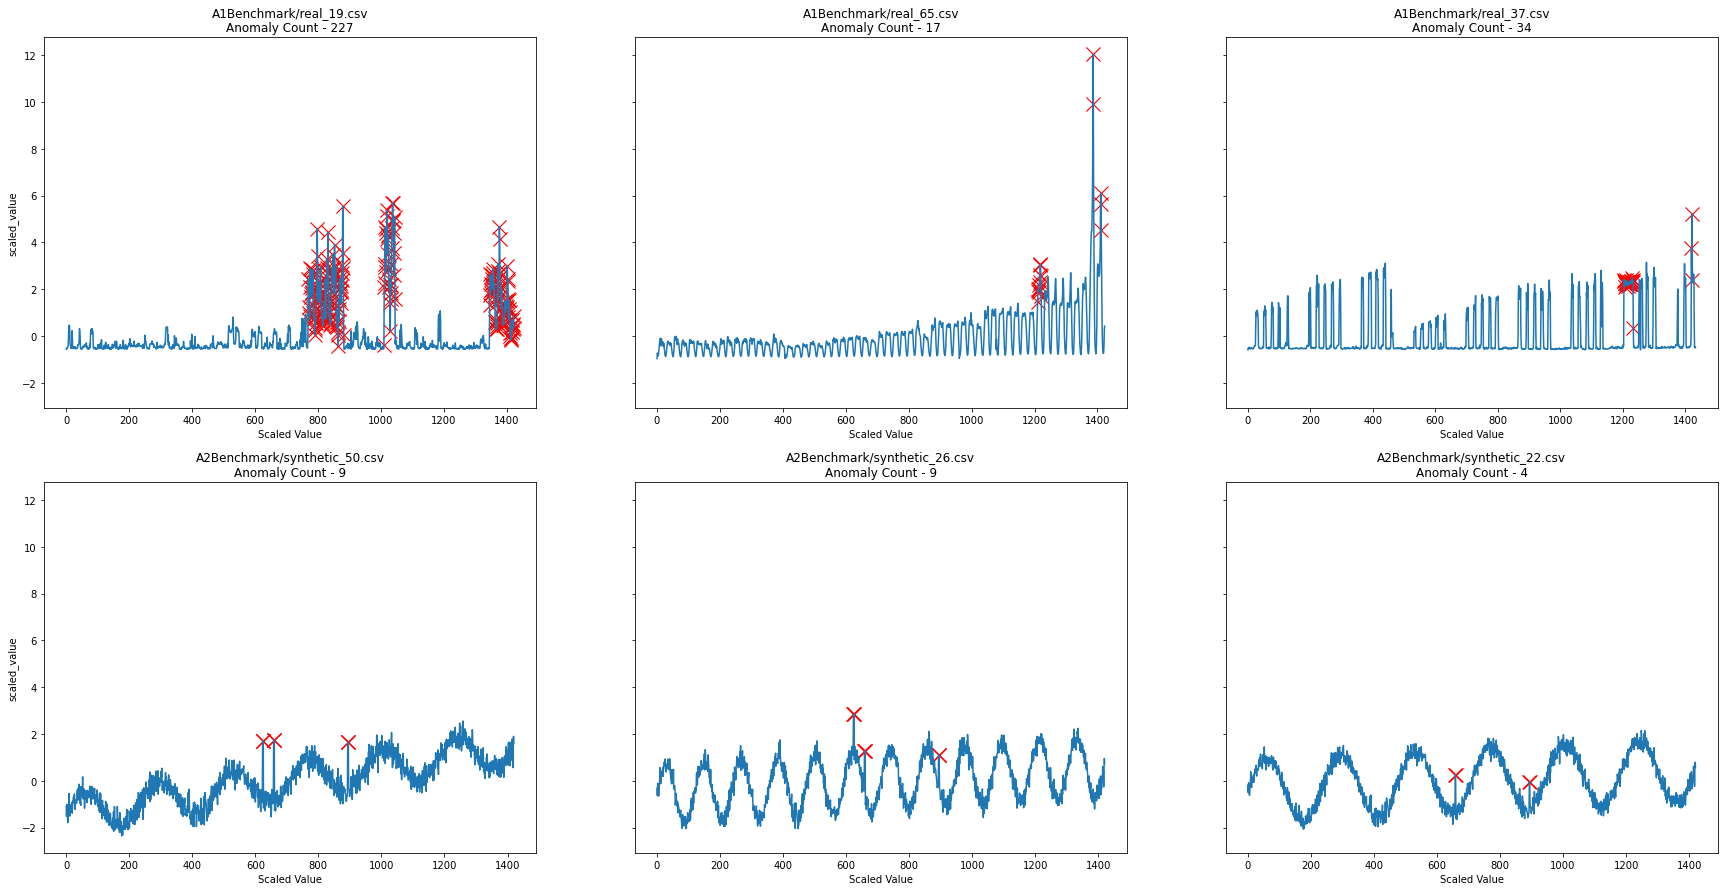

In [7]:
files = ['./datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_19.csv',
         './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_65.csv',
         './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_37.csv',
         './datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_50.csv',
         './datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_26.csv',
         './datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_22.csv']
plotter(files)

#### Helper Functions 
- **read_preprocess_data** - for Reading data from csv file and Preprosing using sklearn StandardScalar()
- **get_feature_matrix** - for Reshaping timeseries data into tensors of shape (samples, time_steps, features)
- **get_auto_encoder_model** - for defining different types of Sequential Auto Encoder Models   
- **train_model** - for training Auto Encoder Model
- **get_reconstruction_error** - for Making Predictions and computing the Reconstruction Erros
- **get_anomalies** - For determining which data samples have been flagged / predicted as anomaly by the model
- **plot_info_graph** - for Plotting various graphs highling model summary, model training,  model results, and model evaluation

In [35]:
def read_preprocess_data(file, column_name='value'):
    """
    Reading data from csv file and Preprosing using sklearn StandardScalar()
    """
    df = pd.read_csv(file) # Reading data from csv file
    df.timestamp = df.index
    ct = ColumnTransformer([('scaler',StandardScaler(),[column_name])], remainder='drop') # Standadize the data using Standard Scalar
    df['scaled_'+column_name] = ct.fit_transform(df)
    return df



def get_feature_matrix(time_steps, df, column_name='scaled_value', label_col=None):
    """
    Reshaping timeseries data into tensors of shape (samples, time_steps, features)
    """
    X = []
    y = []
    for i in range(time_steps, df.shape[0]):
        X.append(df.iloc[i-time_steps:i][column_name].values)
        if label_col is not None:
            y.append(np.any(df.iloc[i-time_steps:i][label_col].values)) # A series is deemed Anomly if any of the time steps is flagged as anomaly
    X = np.array(X)
    X = X.reshape(X.shape[0],X.shape[1],1) # Reshaping Feature Matrix as (samples, time_steps, n_features) for LSTM and CNN Auto encoders
    if label_col is not None:
        return (X,y)
    return X



def get_auto_encoder_model(ae_variant, time_steps, n_features, optimizer='adam', loss='mae'):
    """
    Defining different types of Sequential Auto Encoder Models
    """
    autoencoder = keras.models.Sequential(name='auto_encoder')
    if ae_variant.lower() == 'lstm-2-layer-128': # 2 layer LSTM auto encoder with (128-64-64-128) encode-decode architecture
        
        autoencoder.add(keras.layers.LSTM(128, return_sequences=True, input_shape=(time_steps, n_features), name='Encoder_Layer_1'))
        autoencoder.add(keras.layers.LSTM(64, return_sequences=False, name='Encoder_Layer_2'))
        
        autoencoder.add(keras.layers.RepeatVector(time_steps, name='Encoder_Last_Layer'))
        
        autoencoder.add(keras.layers.LSTM(64, return_sequences=True, name='Decoder_Layer_1'))
        autoencoder.add(keras.layers.LSTM(128, return_sequences=True, name='Decoder_Layer_2'))
        
        autoencoder.add(keras.layers.TimeDistributed(keras.layers.Dense(n_features), name='Decoder_Last_Layer_'))    
    
    elif ae_variant.lower() == 'lstm-2-layer-64': # 2 layer LSTM auto encoder with (64-32-32-64) encode-decode architecture
        
        autoencoder.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(time_steps, n_features), name='Encoder_Layer_1'))
        autoencoder.add(keras.layers.LSTM(32, return_sequences=False, name='Encoder_Layer_2'))
        
        autoencoder.add(keras.layers.RepeatVector(time_steps, name='Encoder_Last_Layer'))
        
        autoencoder.add(keras.layers.LSTM(32, return_sequences=True, name='Decoder_Layer_1'))
        autoencoder.add(keras.layers.LSTM(64, return_sequences=True, name='Decoder_Layer_2'))
        
        autoencoder.add(keras.layers.TimeDistributed(keras.layers.Dense(n_features), name='Decoder_Last_Layer'))
    
    elif ae_variant.lower() == 'cnn-2-layer-16': # 2 layer CNN auto encoder with (16-8-8-16) encode-decode architecture
        
        autoencoder.add(keras.layers.Conv1D(16, 3, activation='relu', padding='same', input_shape=(time_steps, n_features), name='Encoder_layer_1'))
        autoencoder.add(keras.layers.MaxPool1D(2))
        
        autoencoder.add(keras.layers.Conv1D(8, 3, activation='relu', padding='same'))
        autoencoder.add(keras.layers.MaxPool1D(2))
        
        autoencoder.add(keras.layers.Conv1D(8, 3, activation='relu', padding='same'))
        autoencoder.add(keras.layers.UpSampling1D(2))
        
        autoencoder.add(keras.layers.Conv1D(16, 3, activation='relu', padding='same'))
        autoencoder.add(keras.layers.UpSampling1D(2))
        
        autoencoder.add(keras.layers.Conv1D(1, 1, activation='tanh', padding='valid'))
        
    autoencoder.compile(optimizer=optimizer, loss=loss)
    
    return autoencoder



def train_model(model, feature_matrix, labels, epochs=30, verbose=1):
    """
    Train Auto Encoder Model
    """
    return model.fit(x=feature_matrix, y=labels, epochs=epochs, verbose=verbose) # Train Autoencoder Model



def get_reconstruction_error(model, x, return_predictions=True):
    """
    Making Predictions and Computing the Reconstruction Erros
    """
    x_pred = model.predict(x) # Predict / Recreate input data
    re = np.mean(np.abs(x_pred - x), axis=1).reshape(-1) # Compute MAE as loss
    if return_predictions:
        return (re, x_pred)
    return re



def get_anomalies(errors, time_steps, standard_deviation_factor=1.0, return_threshold=True):
    """
    Determins which data samples have to been flagged / predicted as anomaly by the model
    """
    threshold = errors.mean() + (standard_deviation_factor*errors.std()) # Selecting a Threshold for flagging samples as Anomaly [Mean + (factor)*std]
    above_threshold = errors > threshold
    samples = []
    for i in range(time_steps - 1, len(errors) + 1):
        if np.all(above_threshold[i - time_steps + 1 : i]):
            samples.append(i)
    if return_threshold:
        return (samples, threshold)
    return samples




def plot_confusion_matrix(true_values, predicted_values, ax=None):
    """
    Plots Confusion Matrix for a Binary Classification Problem
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,7))
        
    cm = confusion_matrix(true_values, predicted_values)

    cm_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cm_count = ['{:d}'.format(i) for i in cm.flatten()]
    cm_percents = ['{:.2%}'.format(i) for i in cm.flatten()/np.sum(cm)]

    sns.heatmap(cm, 
                cmap='Blues', robust=True, 
                linewidths=5, fmt='',
                annot=np.asarray(['{}\n{}\n{}'.format(i,j,k) for i,j,k in zip(cm_labels, cm_count, cm_percents)]).reshape(2,2),
                annot_kws ={'fontsize':'10'},
                xticklabels=['Not Anomolous','Anomaly'],
                yticklabels=['Not Anomolous','Anomaly'],
                ax=ax, 
               )
    _ = ax.set_xlabel('Predicted')
    _ = ax.set_ylabel('Actaul')
    _ = ax.set_title('Confusion Matrix')
    
    
    

def plot_info_graph(model_history, errors, data_df, raw_samples, predicted_samples, y_true, save_name='model', model=None,
                    zoom_pts=None, feature_col='scaled_value', time_col='timestamp', true_anomaly_df=None, threshold=None, anomalies=None):
    """
    Plots various information graphs highling model summary, model training, model results, and model evaluation
    """
    
    # keras Model Summary
    if model:
        model.summary(line_length=150)
        
    fig = plt.figure(figsize=(30,22))

    # Subplot Layout 
    ax_loss = plt.subplot2grid((4,3), (0,0), colspan=1, rowspan=1)
    ax_cm = plt.subplot2grid((4,3), (0,1), colspan=1, rowspan=1)
    ax_pr = plt.subplot2grid((4,3), (0,2), colspan=1, rowspan=1)
    ax_raw = plt.subplot2grid((4, 3), (1, 0), colspan=2, rowspan=1)
    ax_pred = plt.subplot2grid((4, 3), (2, 0), colspan=2, rowspan=1)
    ax_hist = plt.subplot2grid((4, 3), (1, 2), rowspan=2, colspan=1)
    ax_zoom1 = plt.subplot2grid((4, 3), (3, 0))
    ax_zoom2 = plt.subplot2grid((4, 3), (3, 1))
    ax_zoom3 = plt.subplot2grid((4, 3), (3, 2))

    # Plot Model History
    _ = ax_loss.plot(model_history.epoch, model_history.history['loss'])
    _ = ax_loss.set_title('Training Loss Over Epochs')
    _ = ax_loss.set_xlabel('Number of Epochs')
    _ = ax_loss.set_ylabel('Mean Absolute Error Loss')
    
    # Plot Confusion Matrix
    plot_confusion_matrix(data_df.is_anomaly.values, [1 if i in anomalies else 0 for i in data_df.index.values], ax=ax_cm)
    
    # Plot Precision Recall Curve
    precision, recall, thresholds = precision_recall_curve(np.array(y_true).astype(float), errors)
    _ = ax_pr.plot(thresholds, precision[1:], label="Precision")
    _ = ax_pr.plot(thresholds, recall[1:], label="Recall")
    _ = ax_pr.set_title('Precision Recall Curve')
    _ = ax_pr.set_xlabel('Threshold')
    _ = ax_pr.set_ylabel('Precision / Recall')
    if threshold is not None:
        _ = ax_pr.axvline(x=threshold, c='r', linestyle='--', label='Threshold')
    _ = ax_pr.legend()
    
    
    # Plot Reconstruction Error Histogram
    _ = ax_hist.set_title('Reconstruction Error')
    _ = sns.histplot(errors.reshape(-1), bins=100, ax=ax_hist)
    if threshold is not None:
        _ = ax_hist.axvline(x=threshold, c='r', linestyle='--', label='Threshold')
        _ = ax_hist.legend()
    
    # Plot Raw Time Series Data w or w/o true anomalies
    _ = ax_raw.set_title('Time Series')
    _ = ax_raw.set_xlabel('Over Time')
    _ = ax_raw.set_ylabel('Scaled Value')
    _ = sns.lineplot(data=data_df, x=time_col, y=feature_col, ax=ax_raw)
    
    if true_anomaly_df is not None:
        _ = ax_raw.set_title('Time Series with Ground Truth ({} Anomalous Points)'.format(true_anomaly_df.is_anomaly.sum()))
        _ = sns.scatterplot(data=true_anomaly_df, x=time_col,y=feature_col, color='g', marker='x', s=200, ax=ax_raw, label='Ground Truth')
    
    
    # Plot Raw Time Series w or w/o predicted anomalies
    _ = ax_pred.set_title('Predicted Anomalious Points')
    _ = ax_pred.set_xlabel('Over Time')
    _ = ax_pred.set_ylabel('Scaled Value')
    _ = sns.lineplot(data=data_df, x=time_col, y=feature_col, ax=ax_pred)
    
    if anomalies is not None:
        _ = sns.scatterplot(data=data_df.iloc[anomalies], x=time_col, y=feature_col, color='r', marker='x', s=200, ax=ax_pred, label='Predicted Anomaly') 
        if threshold:
            _ = ax_pred.set_title('Predicted Anomalious Points (Threshold = {:.2f}) ({} Anomalous Points)'.format(threshold, len(anomalies)))
    
    
    # Plot the original and auto encoder generated time series samples for given location indices
    if zoom_pts is not None:
        for zpt in zoom_pts:
            _ = ax_raw.axvspan(zpt, zpt+len(raw_samples[zpt].reshape(-1)), alpha=0.7, color='orange')
            _ = ax_pred.axvspan(zpt, zpt+len(predicted_samples[zpt].reshape(-1)), alpha=0.7, color='orange')

        for zpt, ax in zip(zoom_pts, [ax_zoom1, ax_zoom2, ax_zoom3]):
            sns.lineplot(x=np.arange(zpt, zpt+len(raw_samples[zpt].reshape(-1))), y=raw_samples[zpt].reshape(-1), label='Raw', ax=ax)
            sns.lineplot(x=np.arange(zpt, zpt+len(predicted_samples[zpt].reshape(-1))), y=predicted_samples[zpt].reshape(-1), label='AutoEncoder Generated', ax=ax)
            ax.set_title('Zoom Point = {}'.format(zpt))
            ax.set_xlabel('Over Time')
            ax.set_ylabel('Scaled Value')
            
    _ = plt.savefig('./plots/{}.png'.format(save_name)) # Saving infor graph results in plots sub directory
    plt.show()
    
    
    
def perform_analysis(file, ae_type, sequence_size=30, zoom_locations=[300, 800, 1000], threshold=None):
    """
    Driver function encapsulating the above functions and capturing the anlysis process
    """
    data = read_preprocess_data(file)

    X_train, Y_train = get_feature_matrix(time_steps=sequence_size, df=data, column_name='scaled_value', label_col='is_anomaly')

    ae_model = get_auto_encoder_model(ae_variant=ae_type, time_steps=sequence_size, n_features=X_train.shape[2])

    ae_model_history = train_model(model=ae_model, feature_matrix=X_train, labels=X_train, epochs=30, verbose=1)

    recontruction_error, X_train_pred = get_reconstruction_error(model=ae_model, x=X_train, return_predictions=True)
    
    if threshold is None:
        anomalous_samples, threshold = get_anomalies(errors=recontruction_error, time_steps=sequence_size, return_threshold=True)
    else:
        anomalous_samples = get_anomalies(errors=recontruction_error, time_steps=sequence_size, return_threshold=False)

    plot_info_graph(model_history=ae_model_history, model=ae_model, errors=recontruction_error, data_df=data, zoom_pts=zoom_locations, 
                    raw_samples=X_train, predicted_samples=X_train_pred, y_true=Y_train,
                    true_anomaly_df=data[data.is_anomaly > 0], threshold=threshold, anomalies=anomalous_samples,
                    save_name='{}-{}-{}-ss-{}-t-{:.3f}'.format(file.split('/')[-2], file.split('/')[-1].split('.')[0], ae_type, sequence_size, threshold))
    
    
    

### Analysis and Modeling for various datasets by varying the Auto Encoder architecture and hyperparameters

***

#### Dataset 1
#### A1Benchmark/real_19.csv

***

- **2 Layer LSTM Auto Encoder with (128-64-64-128) Auto Encoder architecture**
- **Sequence Length = 40**

Epoch 1/30
44/44 [==============================] - 4s 98ms/step - loss: 0.3883
Epoch 2/30
44/44 [==============================] - 5s 105ms/step - loss: 0.3427
Epoch 3/30
44/44 [==============================] - 5s 120ms/step - loss: 0.3261
Epoch 4/30
44/44 [==============================] - 4s 96ms/step - loss: 0.3085
Epoch 5/30
44/44 [==============================] - 6s 131ms/step - loss: 0.2993
Epoch 6/30
44/44 [==============================] - 8s 172ms/step - loss: 0.2821
Epoch 7/30
44/44 [==============================] - 5s 117ms/step - loss: 0.2678
Epoch 8/30
44/44 [==============================] - 5s 125ms/step - loss: 0.2565
Epoch 9/30
44/44 [==============================] - 4s 88ms/step - loss: 0.2461
Epoch 10/30
44/44 [==============================] - 5s 124ms/step - loss: 0.2265
Epoch 11/30
44/44 [==============================] - 5s 117ms/step - loss: 0.2094
Epoch 12/30
44/44 [==============================] - 4s 99ms/step - loss: 0.2003
Epoch 13/30
44/44 [==========

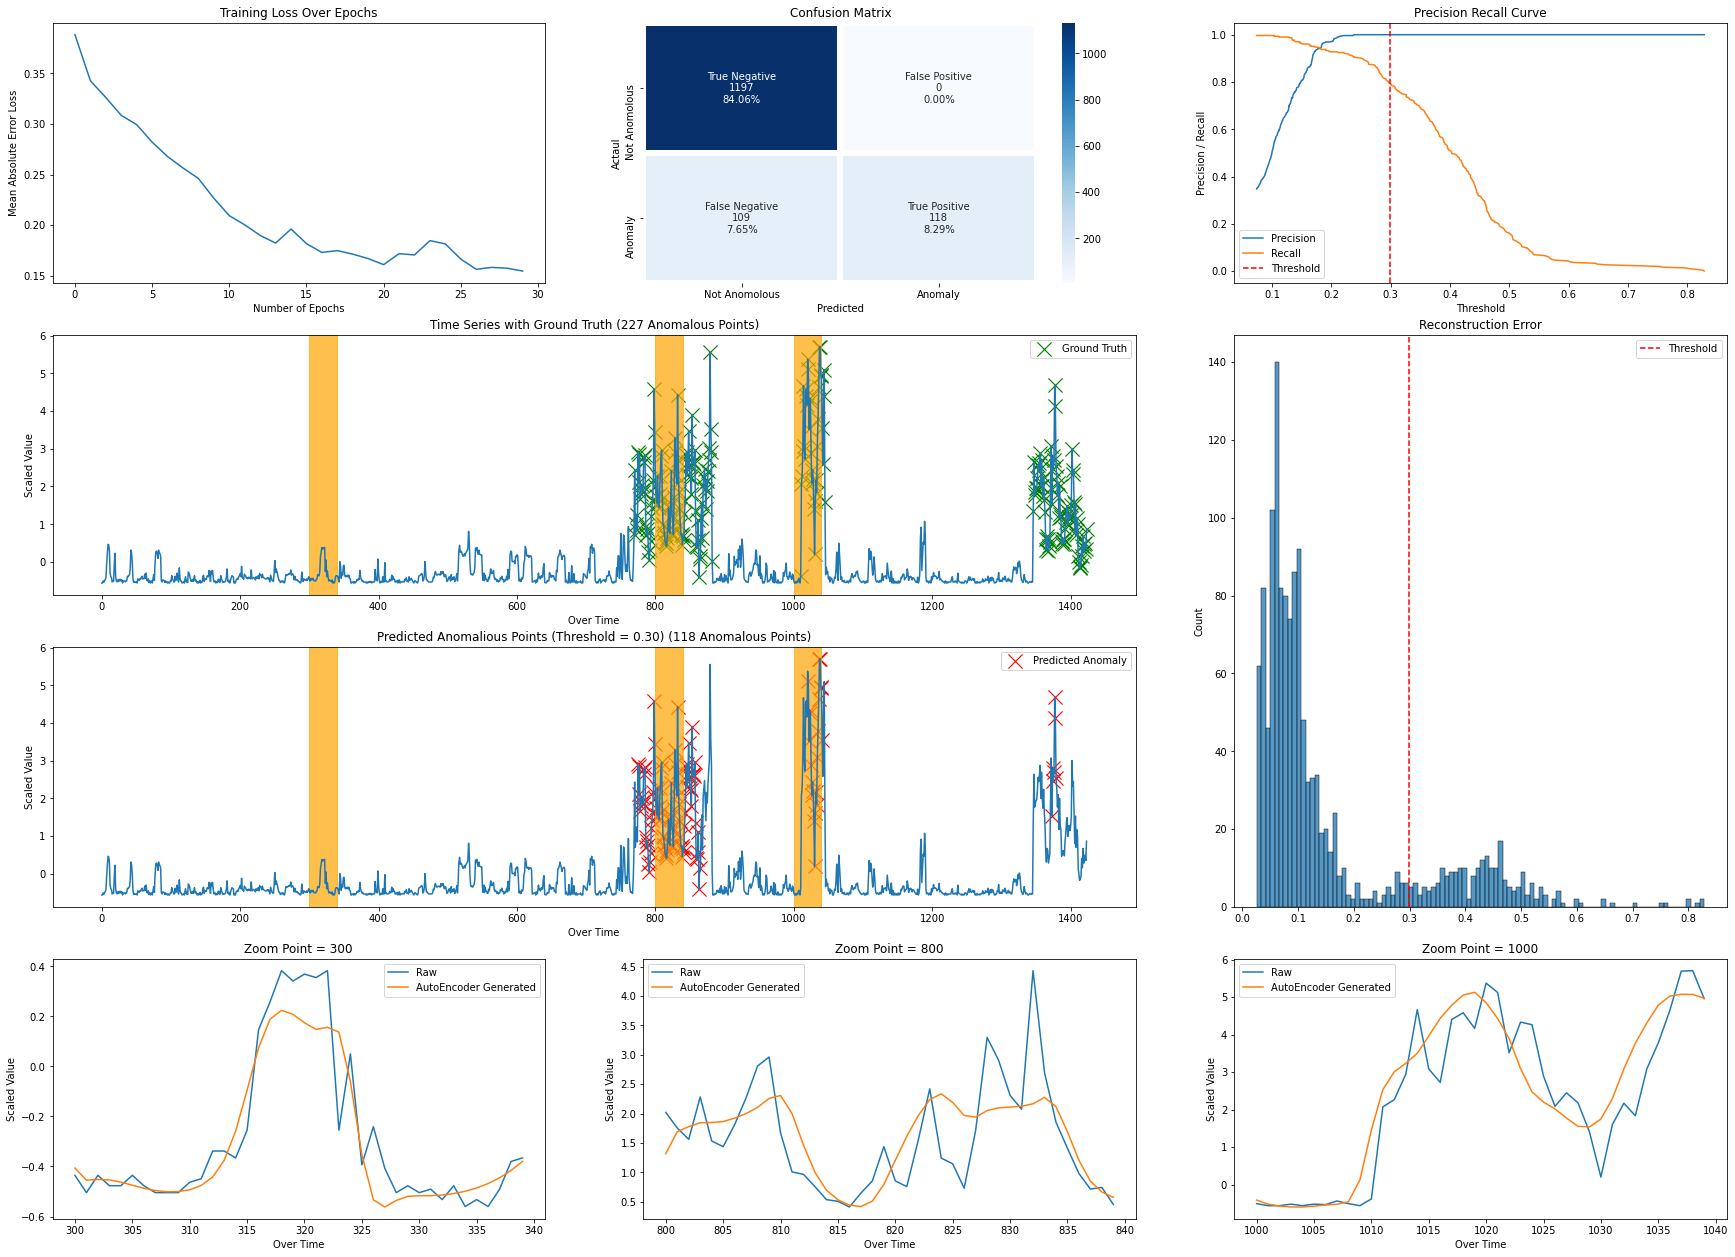

In [12]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_19.csv'
perform_analysis(file=file, ae_type='lstm-2-layer-128', sequence_size=40, zoom_locations=[300, 800, 1000])

- **2 Layer LSTM Auto Encoder with (128-64-64-128) Auto Encoder architecture**
- **Sequence Length = 40**
- **Threshold = 0.2**

Epoch 1/30
44/44 [==============================] - 4s 101ms/step - loss: 0.3859
Epoch 2/30
44/44 [==============================] - 4s 99ms/step - loss: 0.3391
Epoch 3/30
44/44 [==============================] - 6s 126ms/step - loss: 0.3282
Epoch 4/30
44/44 [==============================] - 5s 103ms/step - loss: 0.3054
Epoch 5/30
44/44 [==============================] - 6s 128ms/step - loss: 0.2947
Epoch 6/30
44/44 [==============================] - 5s 118ms/step - loss: 0.2901
Epoch 7/30
44/44 [==============================] - 5s 116ms/step - loss: 0.2700
Epoch 8/30
44/44 [==============================] - 4s 96ms/step - loss: 0.2541
Epoch 9/30
44/44 [==============================] - 5s 113ms/step - loss: 0.2548
Epoch 10/30
44/44 [==============================] - 4s 96ms/step - loss: 0.2328
Epoch 11/30
44/44 [==============================] - 4s 91ms/step - loss: 0.2160
Epoch 12/30
44/44 [==============================] - 4s 89ms/step - loss: 0.2032
Epoch 13/30
44/44 [===========

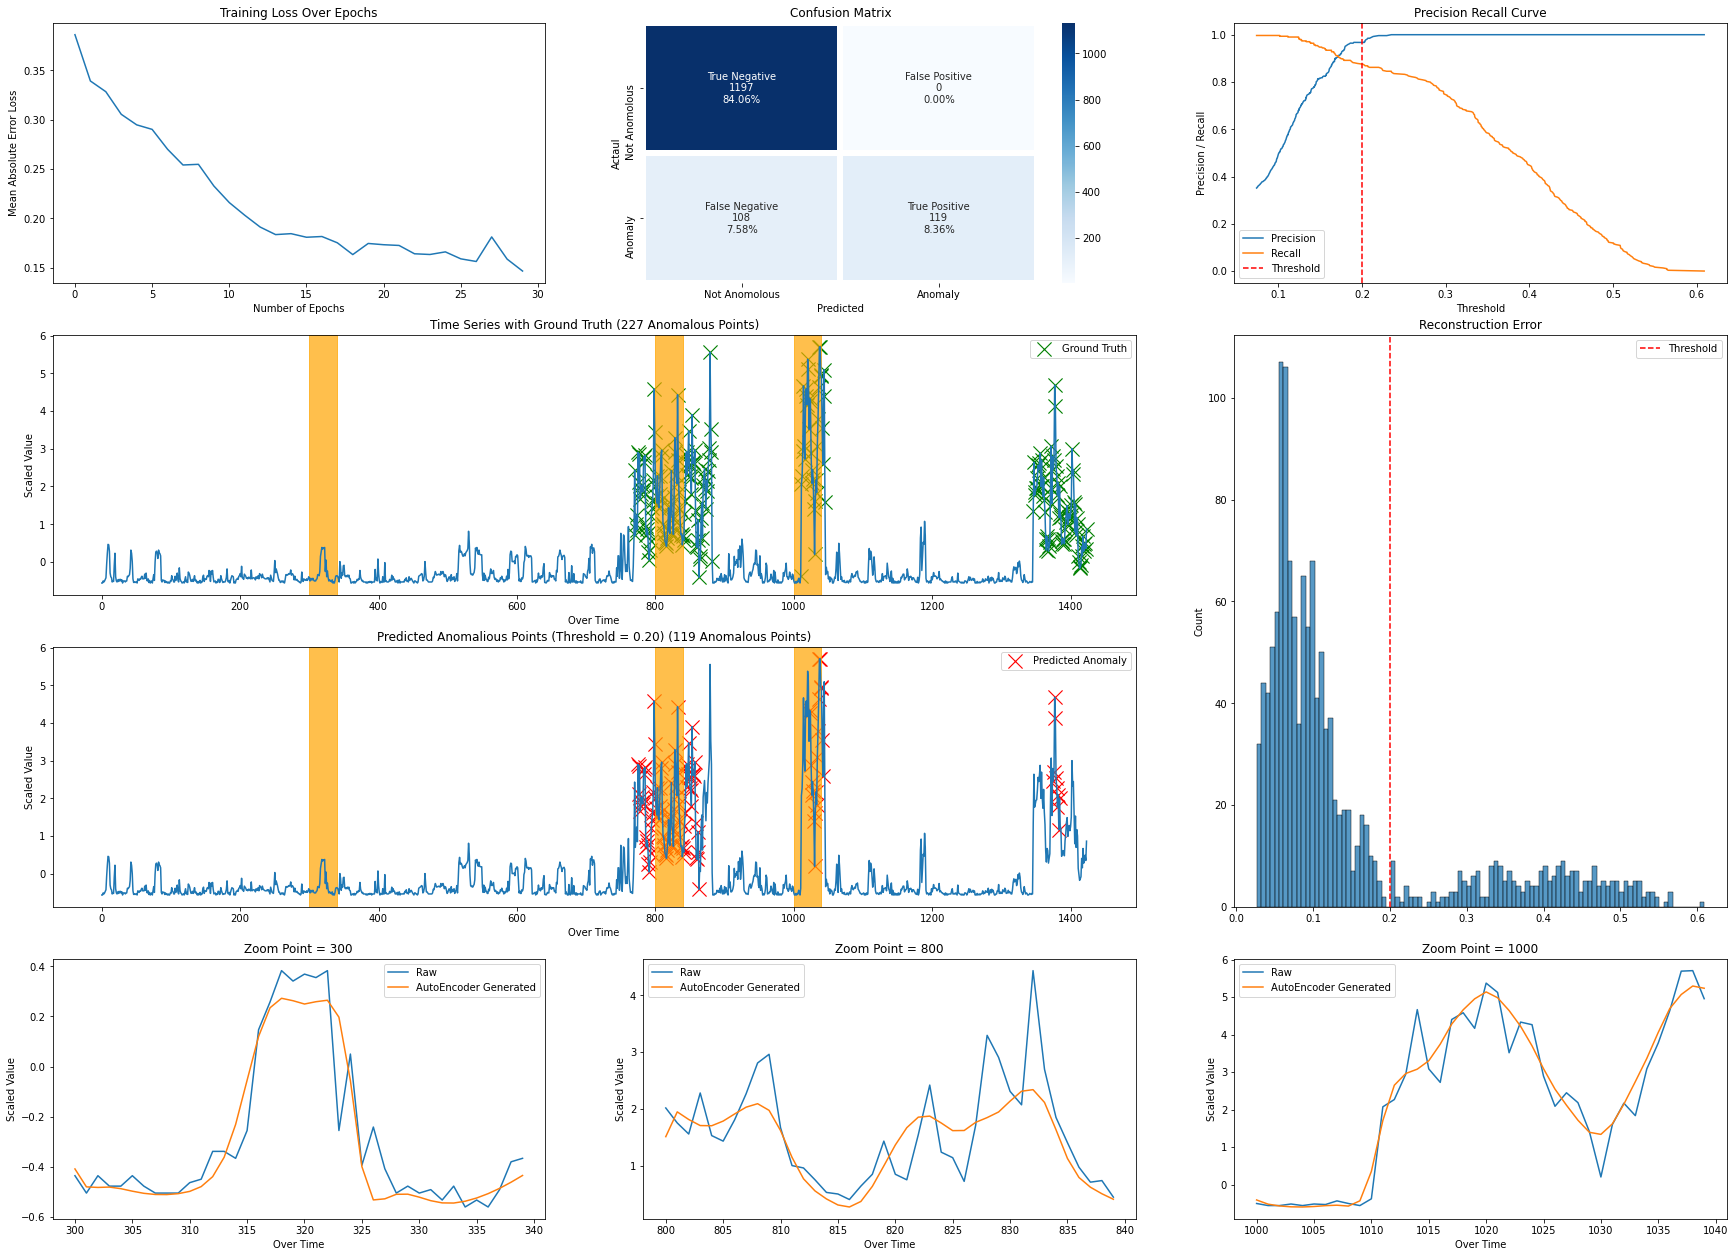

In [13]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_19.csv'
perform_analysis(file=file, ae_type='lstm-2-layer-128', sequence_size=40, zoom_locations=[300, 800, 1000], threshold=0.2)

- **2 Layer CNN Auto Encoder with (16-8-8-16) Auto Encoder architecture**
- **Sequence Length = 40**
- **Threshold = 0.15**

Epoch 1/30
44/44 [==============================] - 0s 4ms/step - loss: 0.4564
Epoch 2/30
44/44 [==============================] - 0s 5ms/step - loss: 0.2830
Epoch 3/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2709
Epoch 4/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2639
Epoch 5/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2568
Epoch 6/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2500
Epoch 7/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2451
Epoch 8/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2424
Epoch 9/30
44/44 [==============================] - 0s 10ms/step - loss: 0.2409
Epoch 10/30
44/44 [==============================] - 0s 9ms/step - loss: 0.2398
Epoch 11/30
44/44 [==============================] - 0s 6ms/step - loss: 0.2389
Epoch 12/30
44/44 [==============================] - 0s 6ms/step - loss: 0.2382
Epoch 13/30
44/44 [=============================

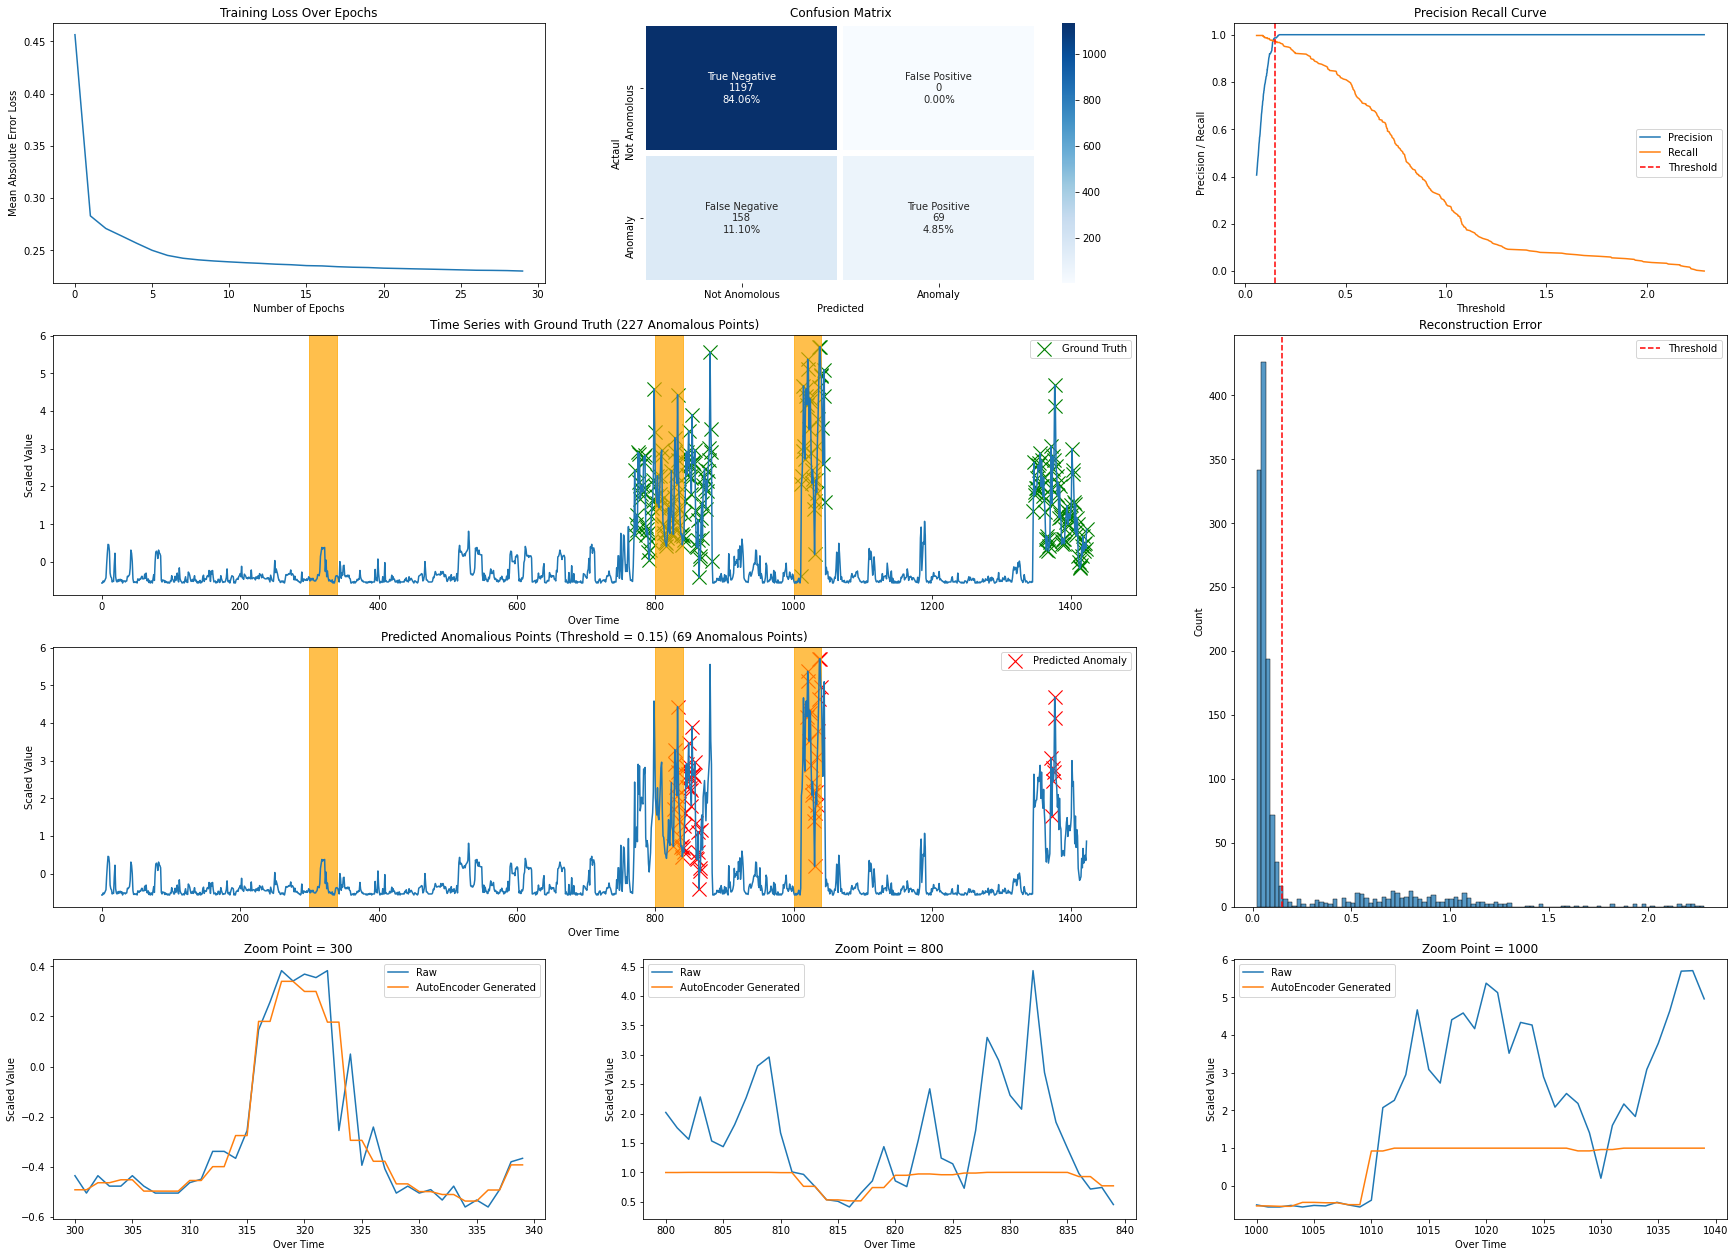

In [16]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_19.csv'
perform_analysis(file=file, ae_type='cnn-2-layer-16', sequence_size=40, zoom_locations=[300, 800, 1000], threshold=0.15)

***

#### Dataset 2 
#### A1Benchmark/real_65.csv

***

- **2 Layer LSTM Auto Encoder with (128-64-64-128) Auto Encoder architecture**
- **Sequence Length = 40**

Epoch 1/30
44/44 [==============================] - 4s 97ms/step - loss: 0.4646
Epoch 2/30
44/44 [==============================] - 4s 92ms/step - loss: 0.4285
Epoch 3/30
44/44 [==============================] - 4s 90ms/step - loss: 0.2469
Epoch 4/30
44/44 [==============================] - 4s 95ms/step - loss: 0.1698
Epoch 5/30
44/44 [==============================] - 4s 90ms/step - loss: 0.1540
Epoch 6/30
44/44 [==============================] - 4s 93ms/step - loss: 0.1383
Epoch 7/30
44/44 [==============================] - 4s 92ms/step - loss: 0.1452
Epoch 8/30
44/44 [==============================] - 4s 89ms/step - loss: 0.1321
Epoch 9/30
44/44 [==============================] - 4s 90ms/step - loss: 0.1247
Epoch 10/30
44/44 [==============================] - 4s 90ms/step - loss: 0.1248
Epoch 11/30
44/44 [==============================] - 4s 90ms/step - loss: 0.1214
Epoch 12/30
44/44 [==============================] - 4s 91ms/step - loss: 0.1148
Epoch 13/30
44/44 [==================

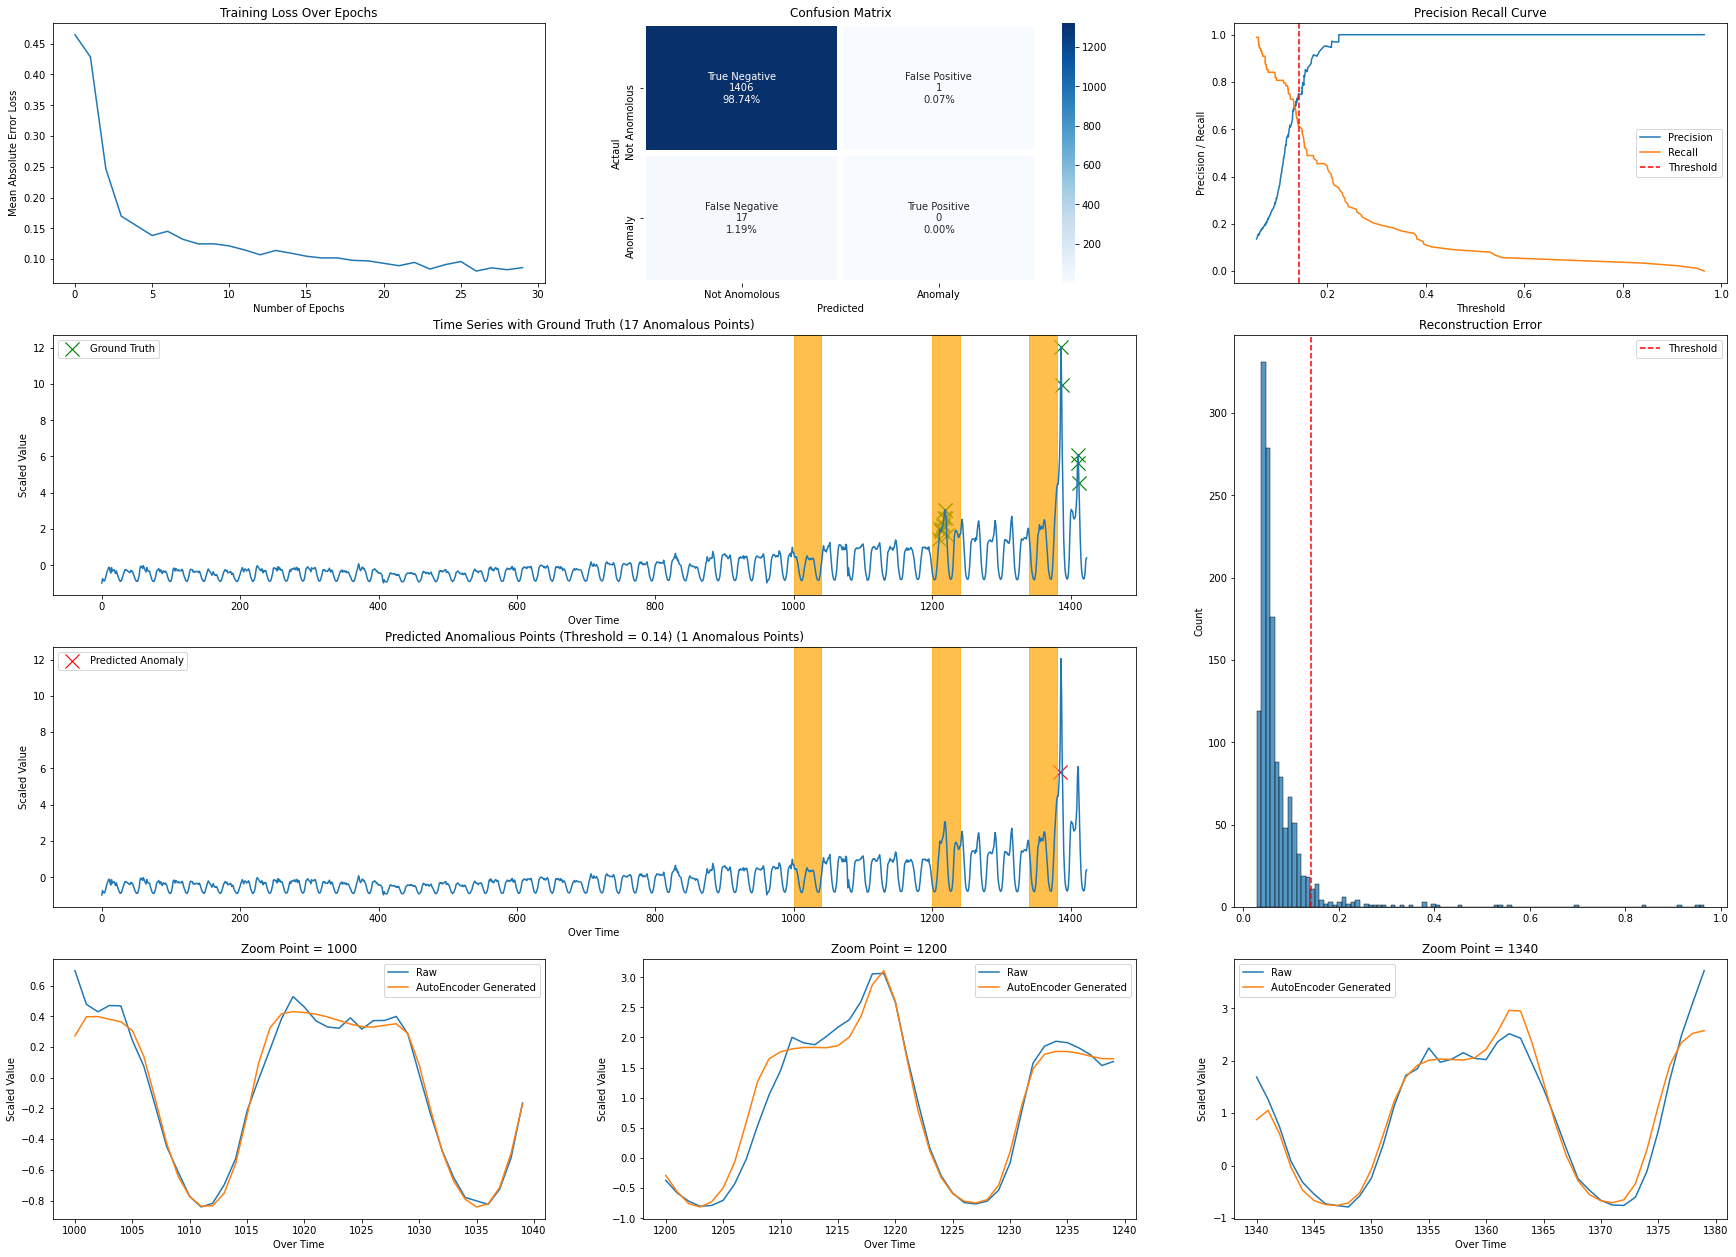

In [17]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_65.csv'
perform_analysis(file=file, ae_type='lstm-2-layer-128', sequence_size=40, zoom_locations=[1000, 1200, 1340])

- **2 Layer LSTM Auto Encoder with (64-32-32-64) Auto Encoder architecture**
- **Sequence Length = 40**

Epoch 1/30
44/44 [==============================] - 3s 66ms/step - loss: 0.4778
Epoch 2/30
44/44 [==============================] - 3s 62ms/step - loss: 0.4390
Epoch 3/30
44/44 [==============================] - 3s 63ms/step - loss: 0.4235
Epoch 4/30
44/44 [==============================] - 3s 63ms/step - loss: 0.2657
Epoch 5/30
44/44 [==============================] - 3s 62ms/step - loss: 0.1913
Epoch 6/30
44/44 [==============================] - 3s 62ms/step - loss: 0.1642
Epoch 7/30
44/44 [==============================] - 3s 61ms/step - loss: 0.1495
Epoch 8/30
44/44 [==============================] - 4s 80ms/step - loss: 0.1407
Epoch 9/30
44/44 [==============================] - 3s 63ms/step - loss: 0.1374
Epoch 10/30
44/44 [==============================] - 3s 62ms/step - loss: 0.1270
Epoch 11/30
44/44 [==============================] - 3s 62ms/step - loss: 0.1283
Epoch 12/30
44/44 [==============================] - 3s 65ms/step - loss: 0.1270
Epoch 13/30
44/44 [==================

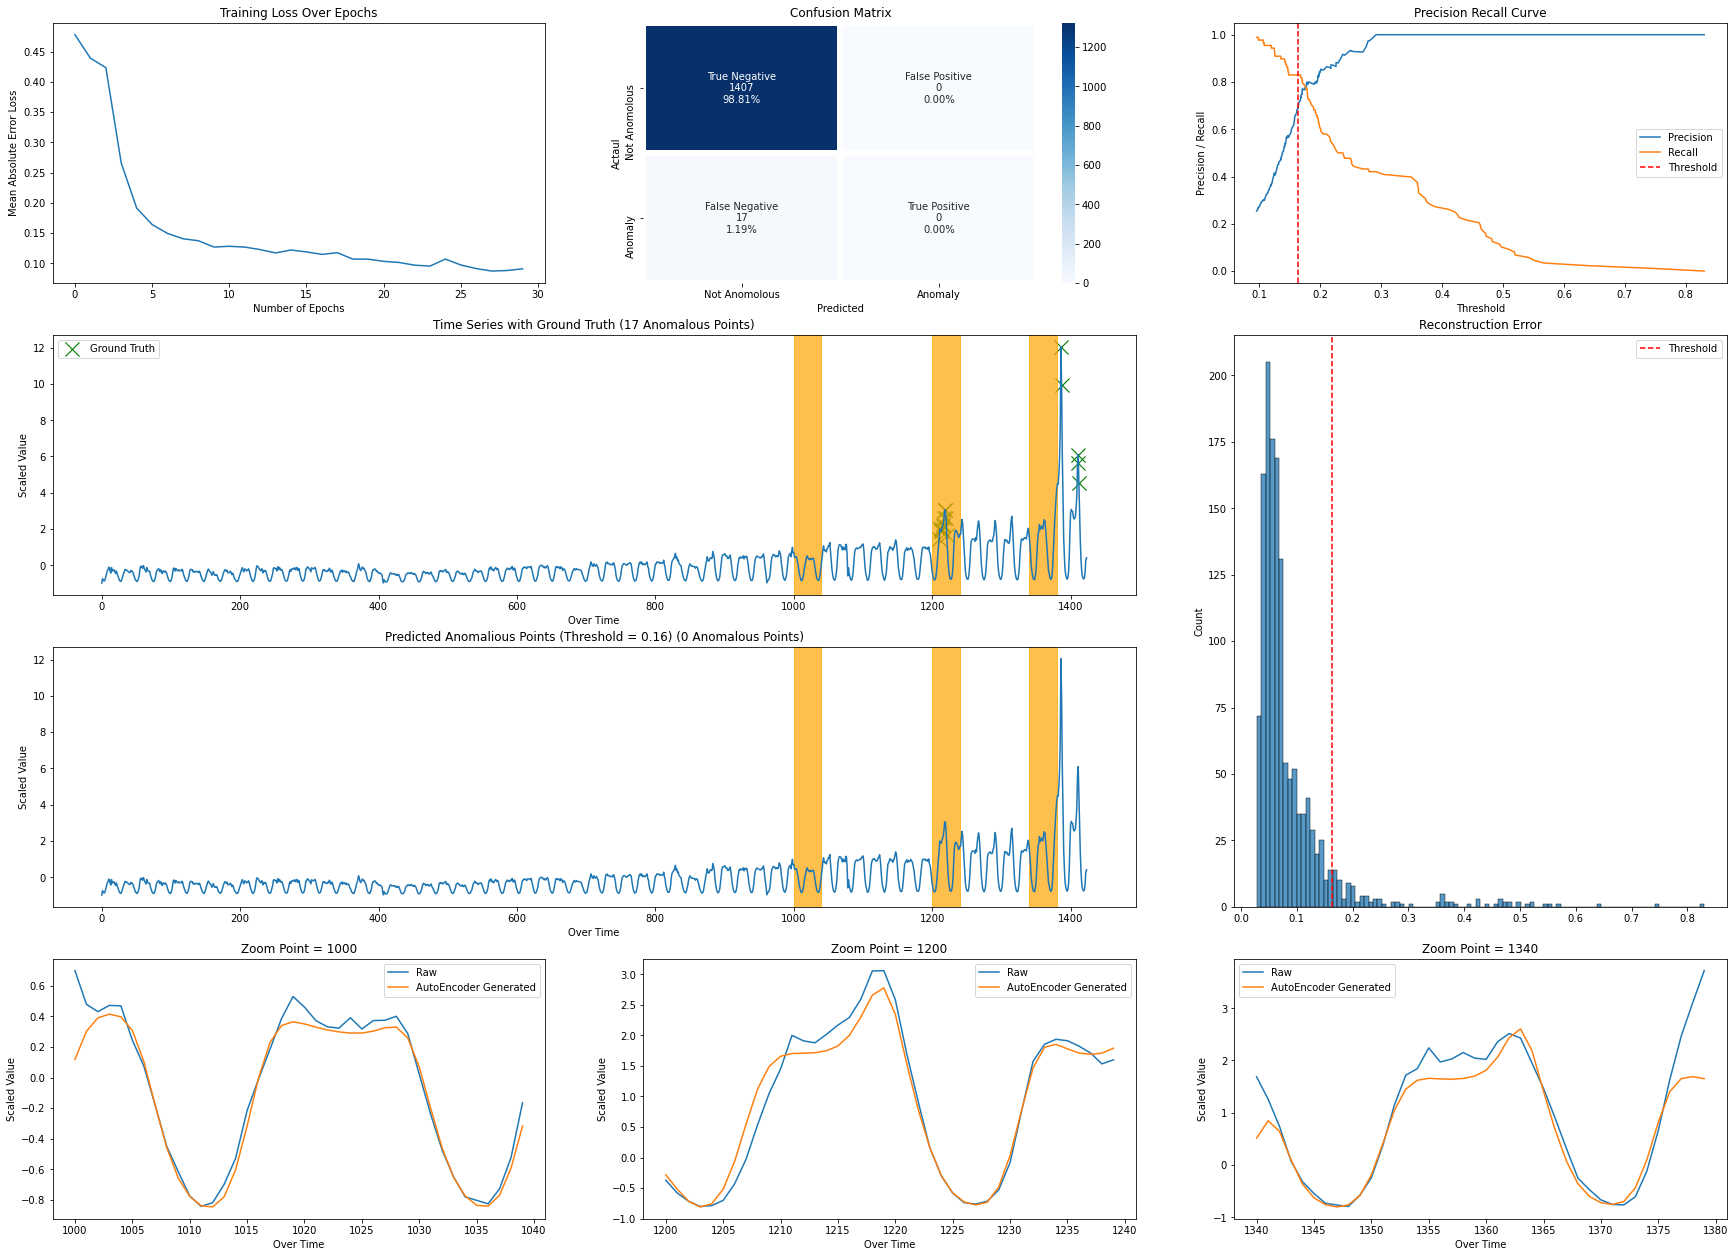

In [18]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_65.csv'
perform_analysis(file=file, ae_type='lstm-2-layer-64', sequence_size=40, zoom_locations=[1000, 1200, 1340])

***

#### Dataset 3 
#### A1Benchmark/real_37.csv

***

- **2 Layer LSTM Auto Encoder with (64-32-32-64) Auto Encoder architecture**
- **Sequence Length = 40**

Epoch 1/30
44/44 [==============================] - 3s 65ms/step - loss: 0.5880
Epoch 2/30
44/44 [==============================] - 3s 62ms/step - loss: 0.5356
Epoch 3/30
44/44 [==============================] - 3s 62ms/step - loss: 0.5175
Epoch 4/30
44/44 [==============================] - 4s 85ms/step - loss: 0.5105
Epoch 5/30
44/44 [==============================] - 5s 106ms/step - loss: 0.5087
Epoch 6/30
44/44 [==============================] - 4s 89ms/step - loss: 0.5212
Epoch 7/30
44/44 [==============================] - 3s 67ms/step - loss: 0.5069
Epoch 8/30
44/44 [==============================] - 3s 65ms/step - loss: 0.4983
Epoch 9/30
44/44 [==============================] - 3s 64ms/step - loss: 0.4997
Epoch 10/30
44/44 [==============================] - 3s 69ms/step - loss: 0.4906
Epoch 11/30
44/44 [==============================] - 3s 68ms/step - loss: 0.4770
Epoch 12/30
44/44 [==============================] - 3s 74ms/step - loss: 0.4704
Epoch 13/30
44/44 [=================

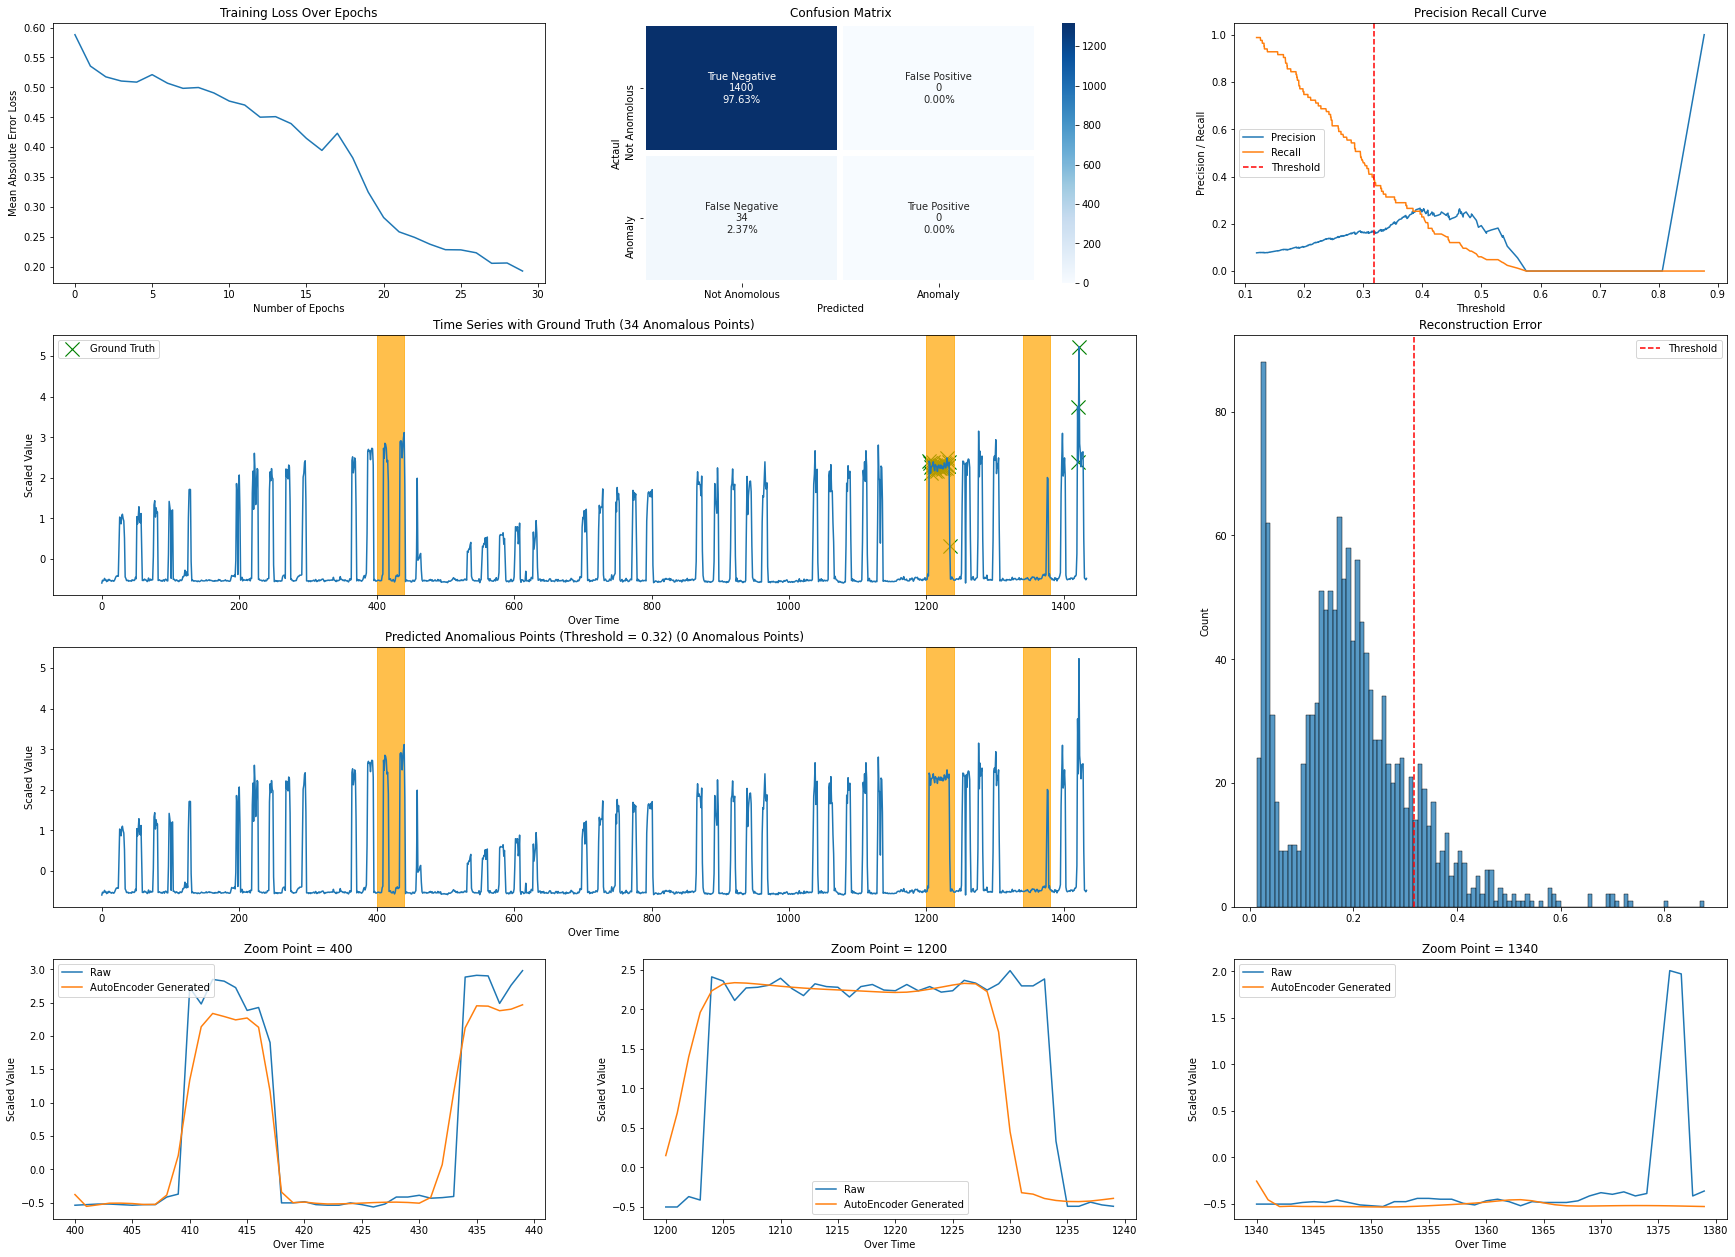

In [23]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_37.csv'
perform_analysis(file=file, ae_type='lstm-2-layer-64', sequence_size=40, zoom_locations=[400, 1200, 1340])

- **2 Layer CNN Auto Encoder with (16-8-8-16) Auto Encoder architecture**
- **Sequence Length = 40**

Epoch 1/30
44/44 [==============================] - 0s 6ms/step - loss: 0.5611
Epoch 2/30
44/44 [==============================] - 0s 4ms/step - loss: 0.3204
Epoch 3/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2930
Epoch 4/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2763
Epoch 5/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2665
Epoch 6/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2589
Epoch 7/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2546
Epoch 8/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2526
Epoch 9/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2511
Epoch 10/30
44/44 [==============================] - 0s 5ms/step - loss: 0.2501
Epoch 11/30
44/44 [==============================] - 0s 5ms/step - loss: 0.2492
Epoch 12/30
44/44 [==============================] - 0s 5ms/step - loss: 0.2485
Epoch 13/30
44/44 [==============================

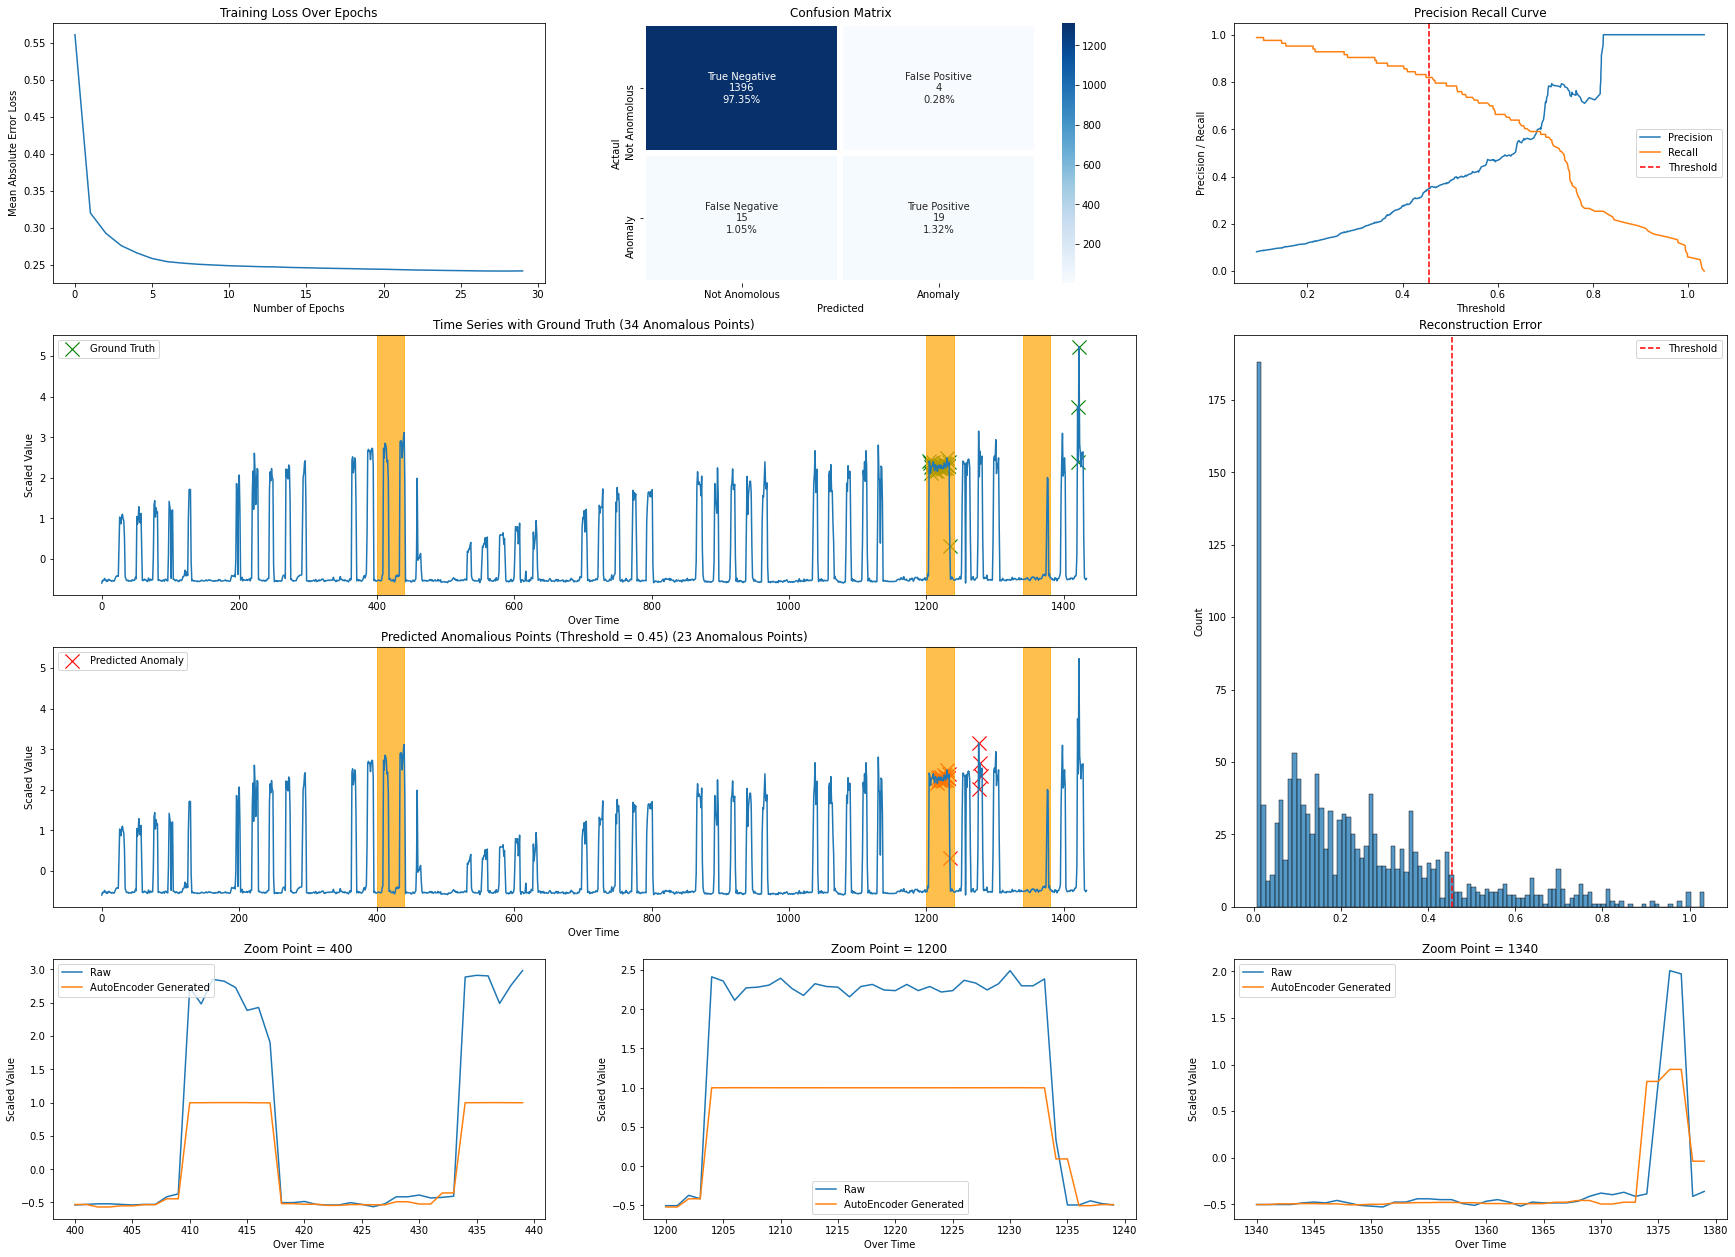

In [24]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_37.csv'
perform_analysis(file=file, ae_type='cnn-2-layer-16', sequence_size=40, zoom_locations=[400, 1200, 1340])

- **2 Layer CNN Auto Encoder with (16-8-8-16) Auto Encoder architecture**
- **Sequence Length = 40**
- **Threshold = 0.7**

Epoch 1/30
44/44 [==============================] - 0s 5ms/step - loss: 0.5365
Epoch 2/30
44/44 [==============================] - 0s 5ms/step - loss: 0.3289
Epoch 3/30
44/44 [==============================] - 0s 5ms/step - loss: 0.2859
Epoch 4/30
44/44 [==============================] - 0s 5ms/step - loss: 0.2716
Epoch 5/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2639
Epoch 6/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2589
Epoch 7/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2560
Epoch 8/30
44/44 [==============================] - 0s 5ms/step - loss: 0.2541
Epoch 9/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2528
Epoch 10/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2516
Epoch 11/30
44/44 [==============================] - 0s 4ms/step - loss: 0.2507
Epoch 12/30
44/44 [==============================] - 0s 5ms/step - loss: 0.2501
Epoch 13/30
44/44 [==============================

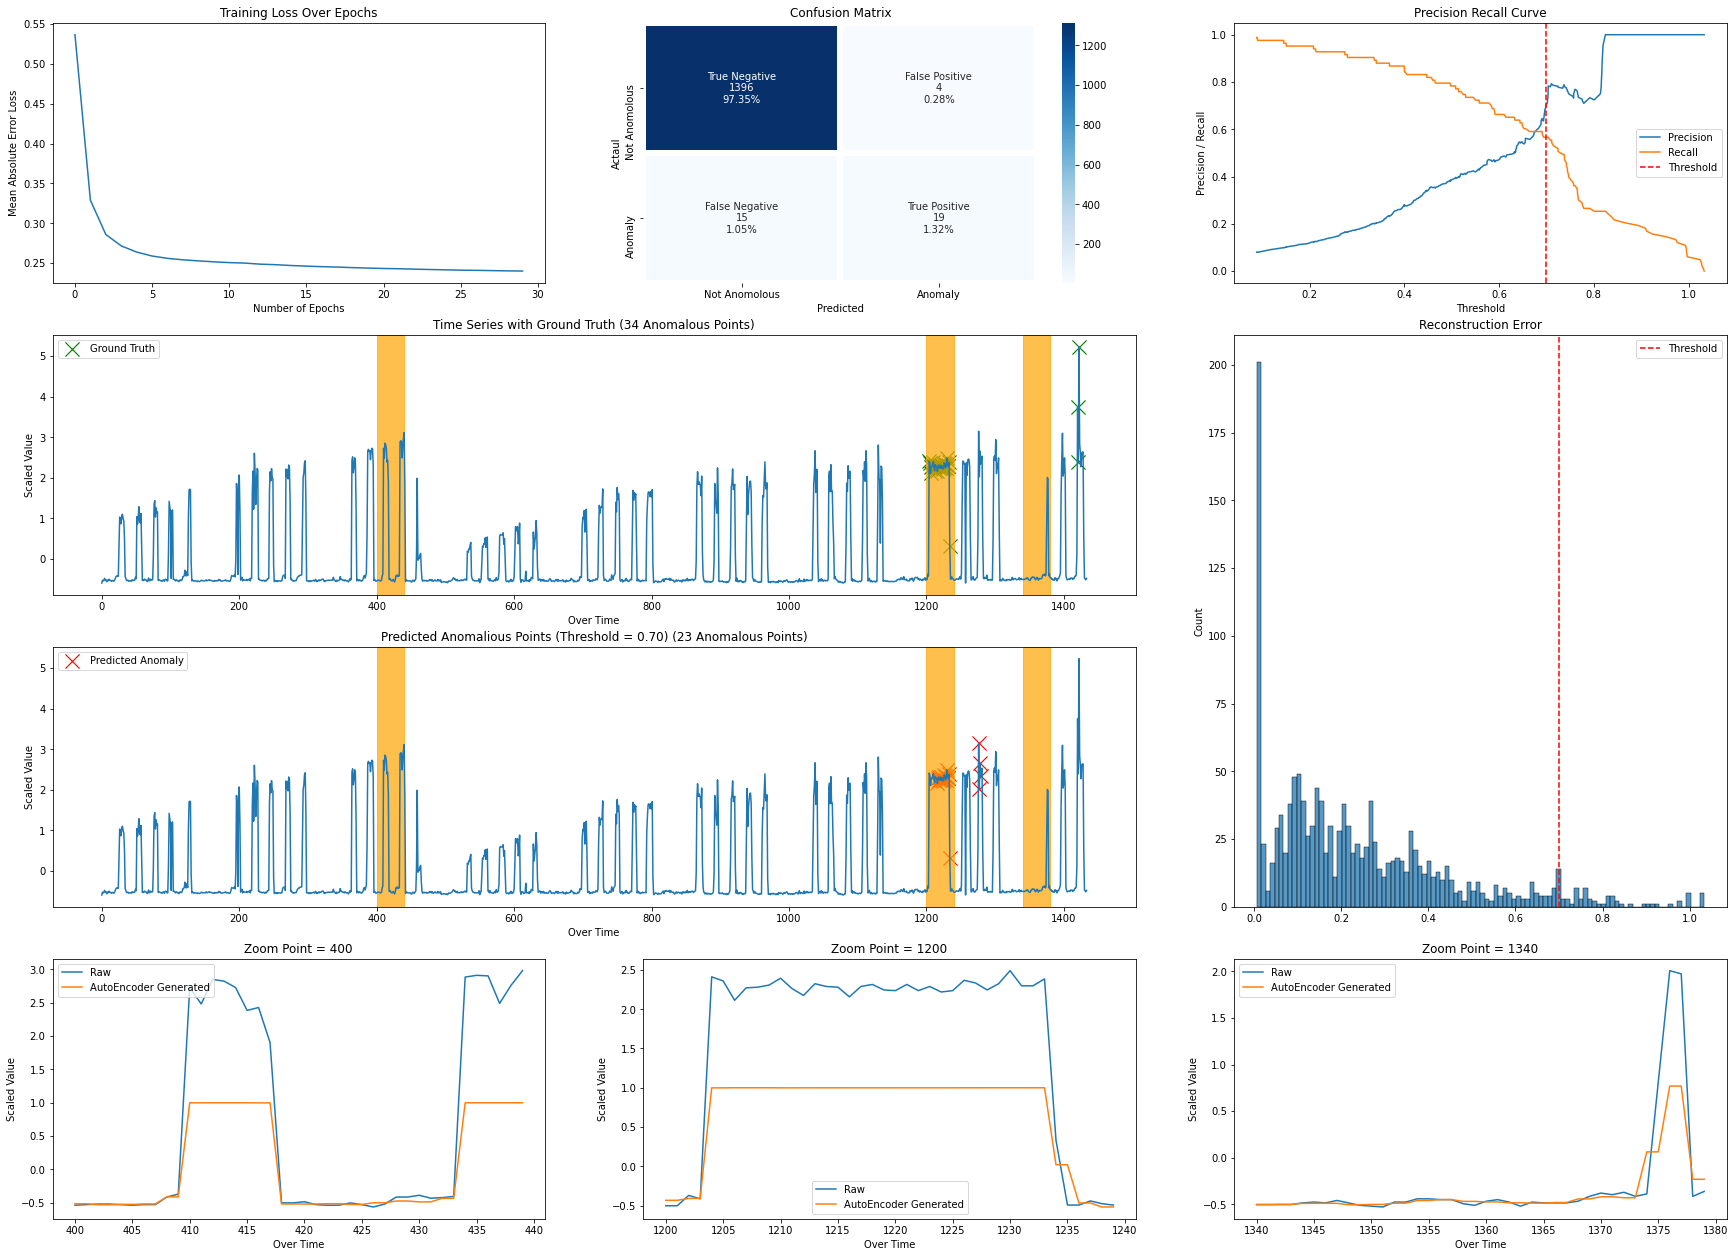

In [25]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_37.csv'
perform_analysis(file=file, ae_type='cnn-2-layer-16', sequence_size=40, zoom_locations=[400, 1200, 1340], threshold=0.7)

- **2 Layer CNN Auto Encoder with (16-8-8-16) Auto Encoder architecture**
- **Sequence Length = 20**
- **Threshold = 0.8**

Epoch 1/30
45/45 [==============================] - 0s 4ms/step - loss: 0.5208
Epoch 2/30
45/45 [==============================] - 0s 3ms/step - loss: 0.3366
Epoch 3/30
45/45 [==============================] - 0s 3ms/step - loss: 0.3081
Epoch 4/30
45/45 [==============================] - 0s 3ms/step - loss: 0.2878
Epoch 5/30
45/45 [==============================] - 0s 3ms/step - loss: 0.2743
Epoch 6/30
45/45 [==============================] - 0s 3ms/step - loss: 0.2657
Epoch 7/30
45/45 [==============================] - 0s 3ms/step - loss: 0.2621
Epoch 8/30
45/45 [==============================] - 0s 3ms/step - loss: 0.2596
Epoch 9/30
45/45 [==============================] - 0s 4ms/step - loss: 0.2574
Epoch 10/30
45/45 [==============================] - 0s 3ms/step - loss: 0.2558
Epoch 11/30
45/45 [==============================] - 0s 3ms/step - loss: 0.2546
Epoch 12/30
45/45 [==============================] - 0s 4ms/step - loss: 0.2536
Epoch 13/30
45/45 [==============================

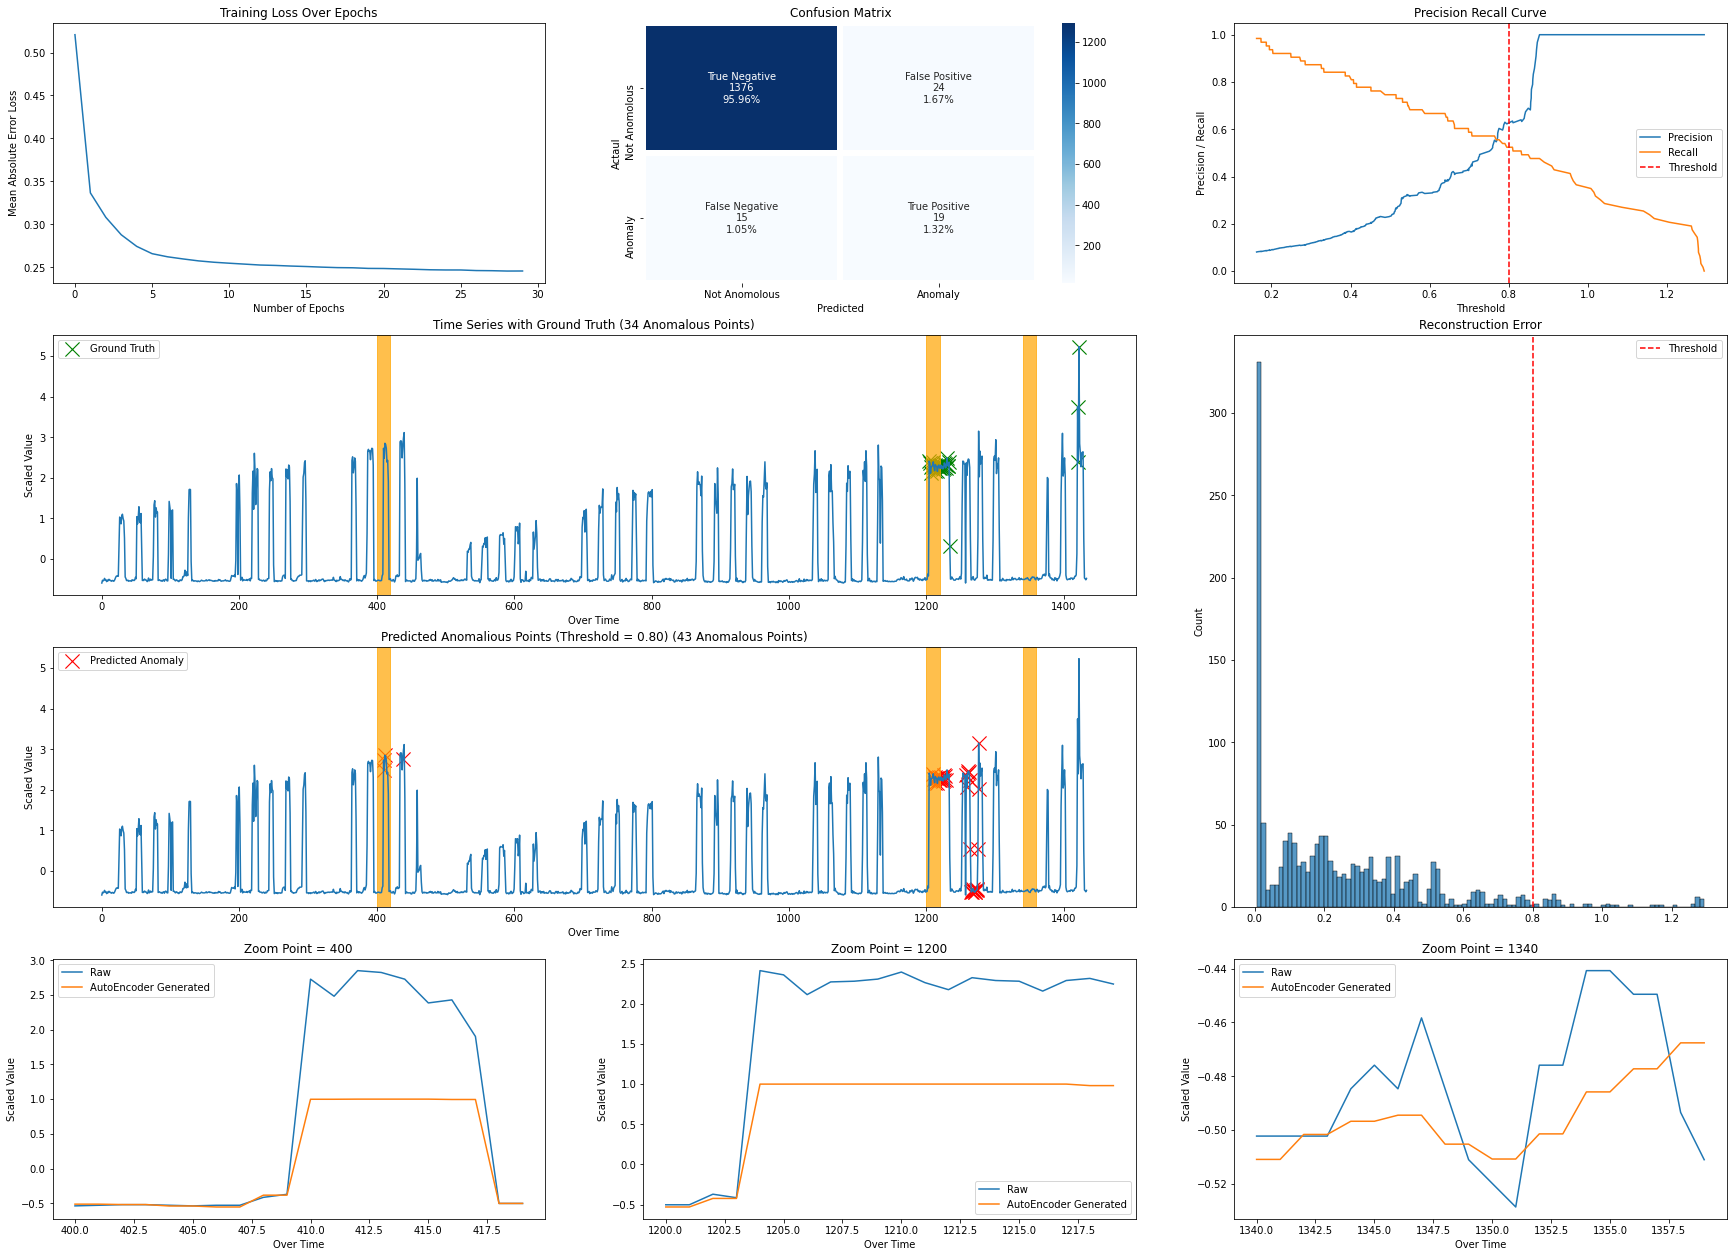

In [26]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_37.csv'
perform_analysis(file=file, ae_type='cnn-2-layer-16', sequence_size=20, zoom_locations=[400, 1200, 1340], threshold=0.8)

***

#### Dataset 4 
#### A2Benchmark/synthethic_50.csv

***

- **2 Layer LSTM Auto Encoder with (64-32-32-64) Auto Encoder architecture**
- **Sequence Length = 20**

Epoch 1/30
44/44 [==============================] - 3s 68ms/step - loss: 0.4019
Epoch 2/30
44/44 [==============================] - 3s 67ms/step - loss: 0.2888
Epoch 3/30
44/44 [==============================] - 3s 59ms/step - loss: 0.2737
Epoch 4/30
44/44 [==============================] - 3s 79ms/step - loss: 0.2635
Epoch 5/30
44/44 [==============================] - 2s 54ms/step - loss: 0.2613
Epoch 6/30
44/44 [==============================] - 2s 55ms/step - loss: 0.2559
Epoch 7/30
44/44 [==============================] - 3s 57ms/step - loss: 0.2493
Epoch 8/30
44/44 [==============================] - 2s 54ms/step - loss: 0.2459
Epoch 9/30
44/44 [==============================] - 2s 54ms/step - loss: 0.2472
Epoch 10/30
44/44 [==============================] - 2s 56ms/step - loss: 0.2421
Epoch 11/30
44/44 [==============================] - 3s 59ms/step - loss: 0.2398
Epoch 12/30
44/44 [==============================] - 2s 54ms/step - loss: 0.2406
Epoch 13/30
44/44 [==================

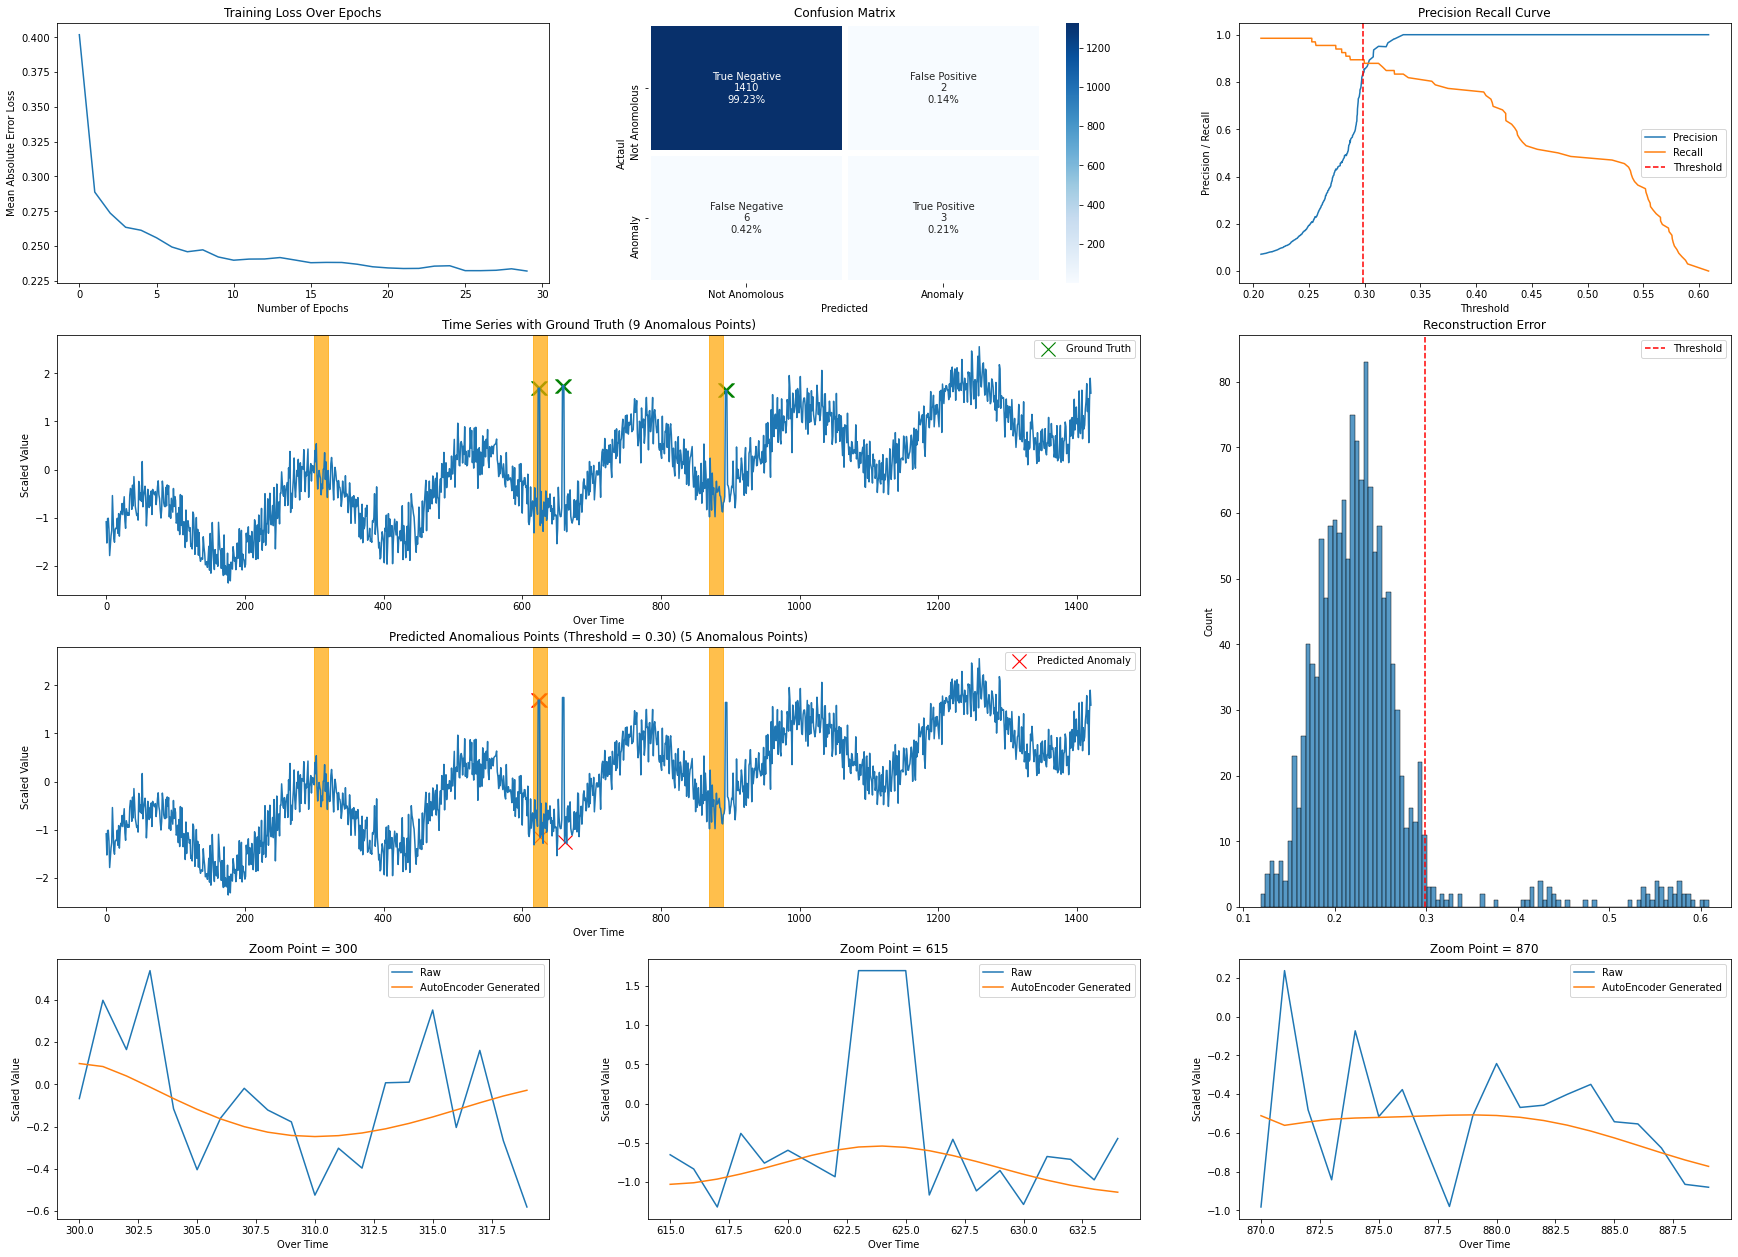

In [27]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_50.csv'
perform_analysis(file=file, ae_type='lstm-2-layer-128', sequence_size=20, zoom_locations=[300, 615, 870])

- **2 Layer LSTM Auto Encoder with (128-64-64-128) Auto Encoder architecture**
- **Sequence Length = 30**

Epoch 1/30
44/44 [==============================] - 3s 79ms/step - loss: 0.4023
Epoch 2/30
44/44 [==============================] - 4s 89ms/step - loss: 0.3003
Epoch 3/30
44/44 [==============================] - 4s 89ms/step - loss: 0.2846
Epoch 4/30
44/44 [==============================] - 3s 73ms/step - loss: 0.2698
Epoch 5/30
44/44 [==============================] - 3s 73ms/step - loss: 0.2801
Epoch 6/30
44/44 [==============================] - 3s 73ms/step - loss: 0.2593
Epoch 7/30
44/44 [==============================] - 4s 82ms/step - loss: 0.2538
Epoch 8/30
44/44 [==============================] - 3s 75ms/step - loss: 0.2495
Epoch 9/30
44/44 [==============================] - 3s 71ms/step - loss: 0.2490
Epoch 10/30
44/44 [==============================] - 3s 71ms/step - loss: 0.2473
Epoch 11/30
44/44 [==============================] - 3s 72ms/step - loss: 0.2506
Epoch 12/30
44/44 [==============================] - 3s 73ms/step - loss: 0.2475
Epoch 13/30
44/44 [==================

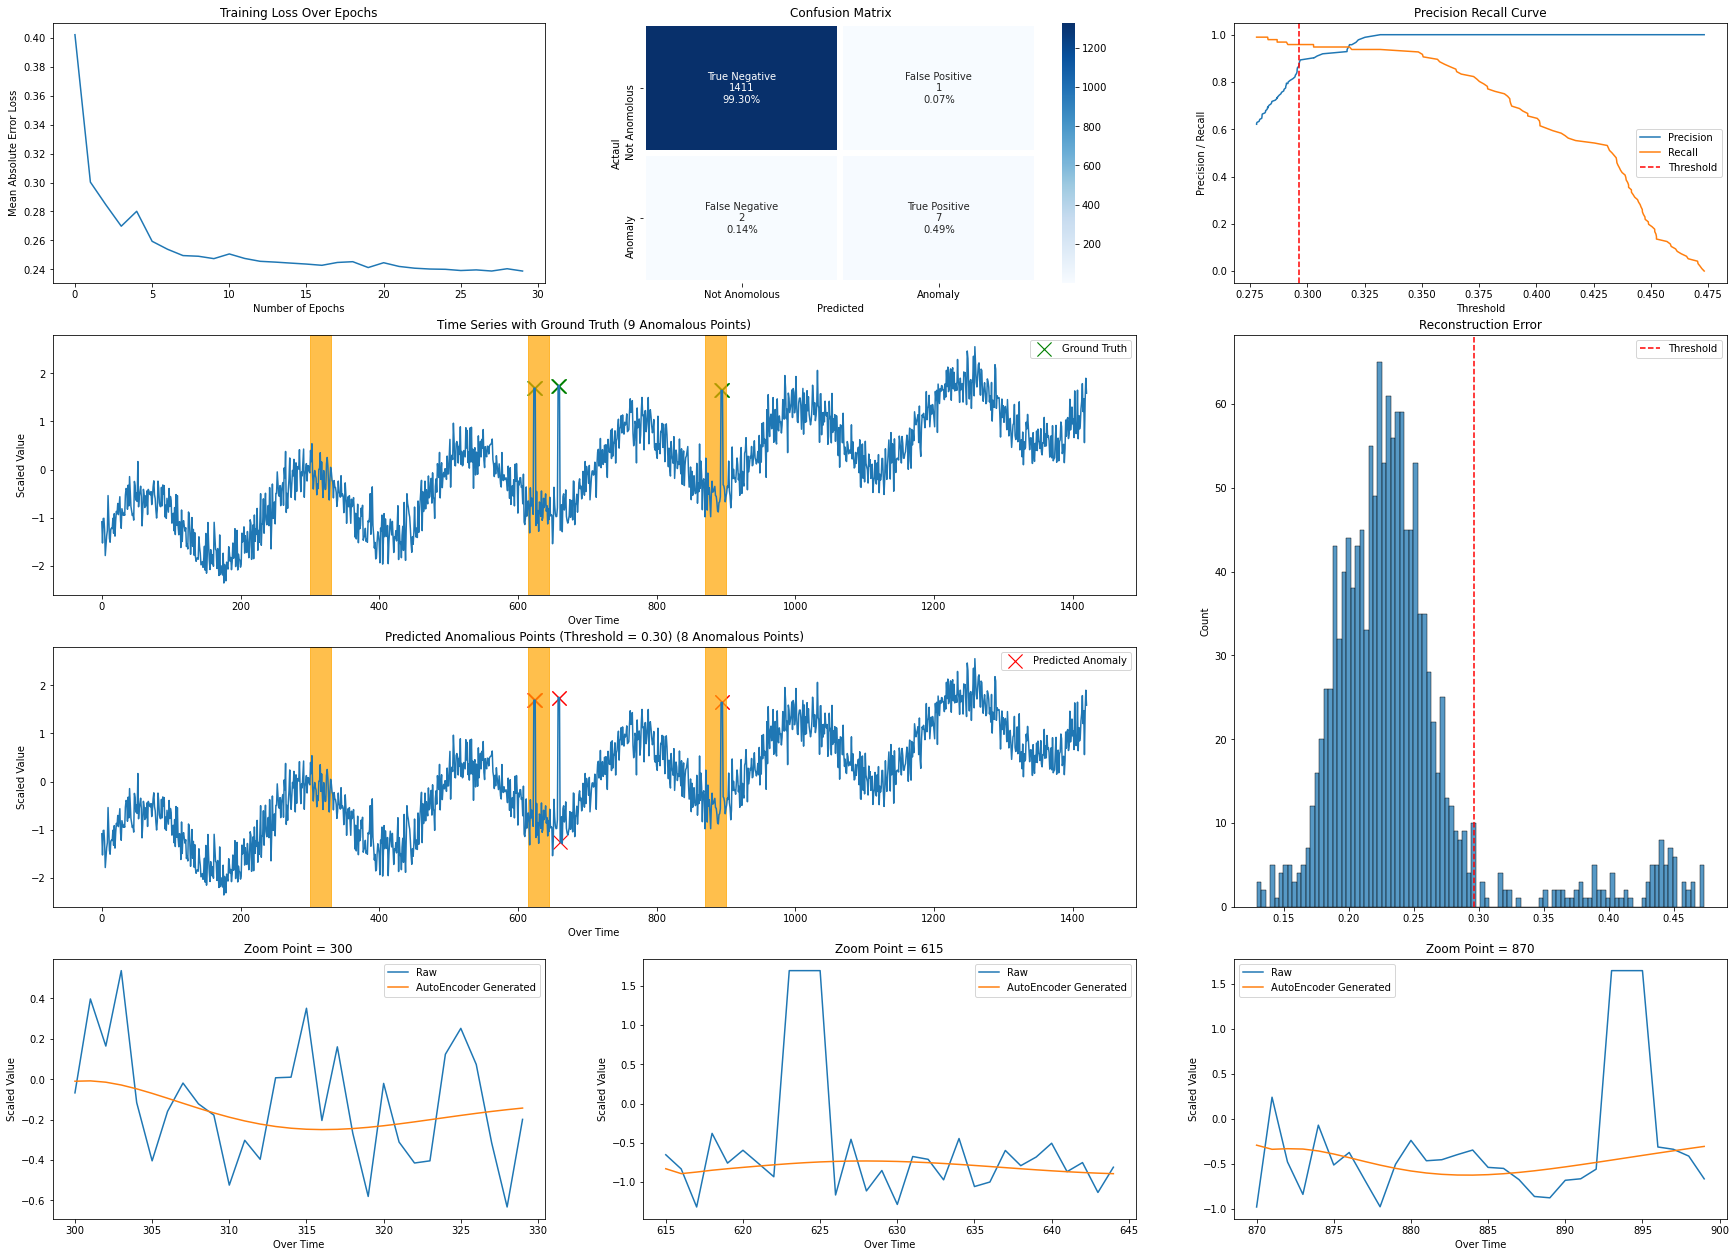

In [28]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_50.csv'
perform_analysis(file=file, ae_type='lstm-2-layer-128', sequence_size=30, zoom_locations=[300, 615, 870])

- **2 Layer CNN Auto Encoder with (16-8-8-16) Auto Encoder architecture**
- **Sequence Length = 40**

Epoch 1/30
44/44 [==============================] - 0s 9ms/step - loss: 0.6194
Epoch 2/30
44/44 [==============================] - 0s 5ms/step - loss: 0.3972
Epoch 3/30
44/44 [==============================] - 1s 12ms/step - loss: 0.3531
Epoch 4/30
44/44 [==============================] - 0s 8ms/step - loss: 0.3337
Epoch 5/30
44/44 [==============================] - 0s 5ms/step - loss: 0.3225
Epoch 6/30
44/44 [==============================] - 1s 12ms/step - loss: 0.3168
Epoch 7/30
44/44 [==============================] - 0s 9ms/step - loss: 0.3132
Epoch 8/30
44/44 [==============================] - 0s 9ms/step - loss: 0.3107
Epoch 9/30
44/44 [==============================] - 0s 8ms/step - loss: 0.3085
Epoch 10/30
44/44 [==============================] - 0s 5ms/step - loss: 0.3068
Epoch 11/30
44/44 [==============================] - 0s 6ms/step - loss: 0.3052
Epoch 12/30
44/44 [==============================] - 0s 5ms/step - loss: 0.3038
Epoch 13/30
44/44 [============================

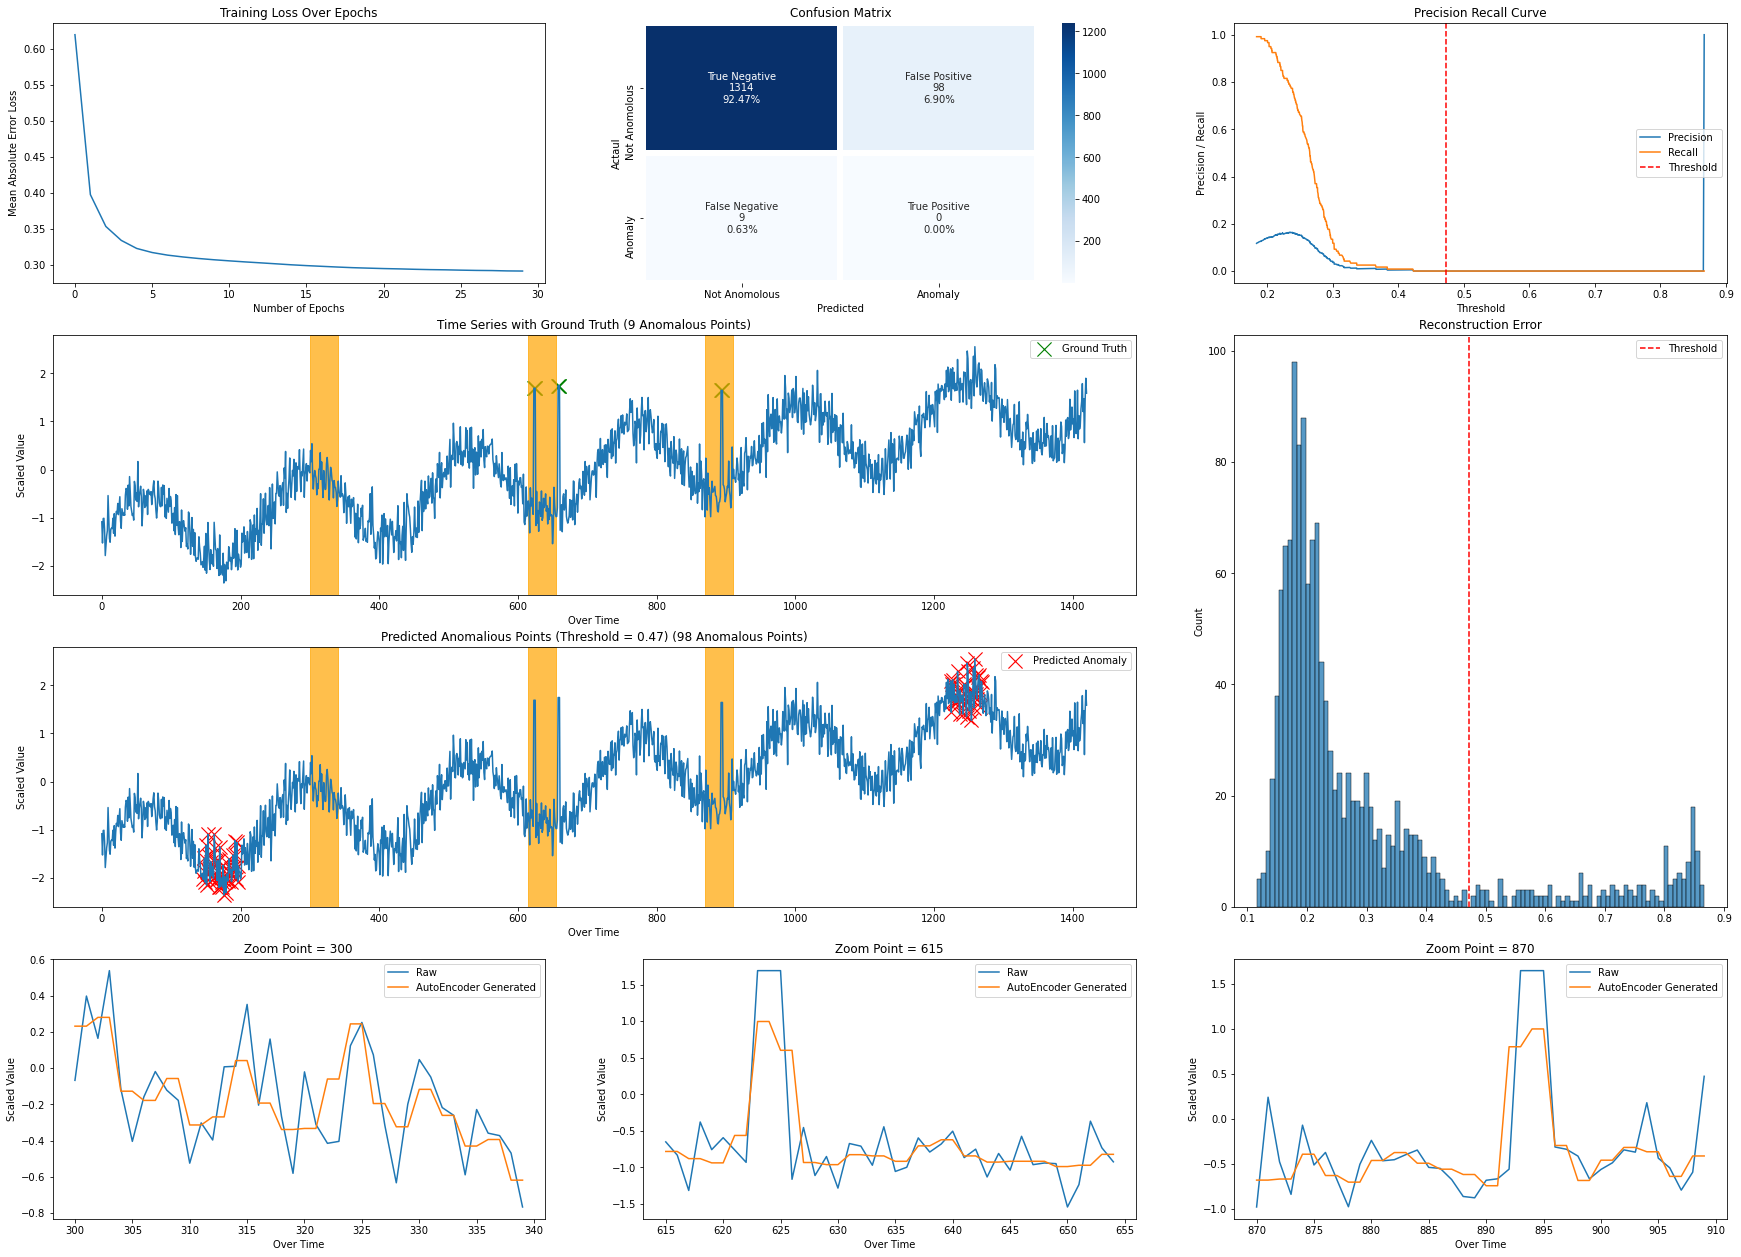

In [29]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_50.csv'
perform_analysis(file=file, ae_type='cnn-2-layer-16', sequence_size=40, zoom_locations=[300, 615, 870])

- **2 Layer CNN Auto Encoder with (16-8-8-16) Auto Encoder architecture**
- **Sequence Length = 20**

Epoch 1/30
44/44 [==============================] - 0s 5ms/step - loss: 0.5526
Epoch 2/30
44/44 [==============================] - 0s 4ms/step - loss: 0.3620
Epoch 3/30
44/44 [==============================] - 0s 4ms/step - loss: 0.3434
Epoch 4/30
44/44 [==============================] - 0s 4ms/step - loss: 0.3313
Epoch 5/30
44/44 [==============================] - 0s 4ms/step - loss: 0.3221
Epoch 6/30
44/44 [==============================] - 0s 4ms/step - loss: 0.3169
Epoch 7/30
44/44 [==============================] - 0s 4ms/step - loss: 0.3147
Epoch 8/30
44/44 [==============================] - 0s 4ms/step - loss: 0.3124
Epoch 9/30
44/44 [==============================] - 0s 4ms/step - loss: 0.3108
Epoch 10/30
44/44 [==============================] - 0s 4ms/step - loss: 0.3090
Epoch 11/30
44/44 [==============================] - 0s 5ms/step - loss: 0.3072
Epoch 12/30
44/44 [==============================] - 0s 11ms/step - loss: 0.3056
Epoch 13/30
44/44 [=============================

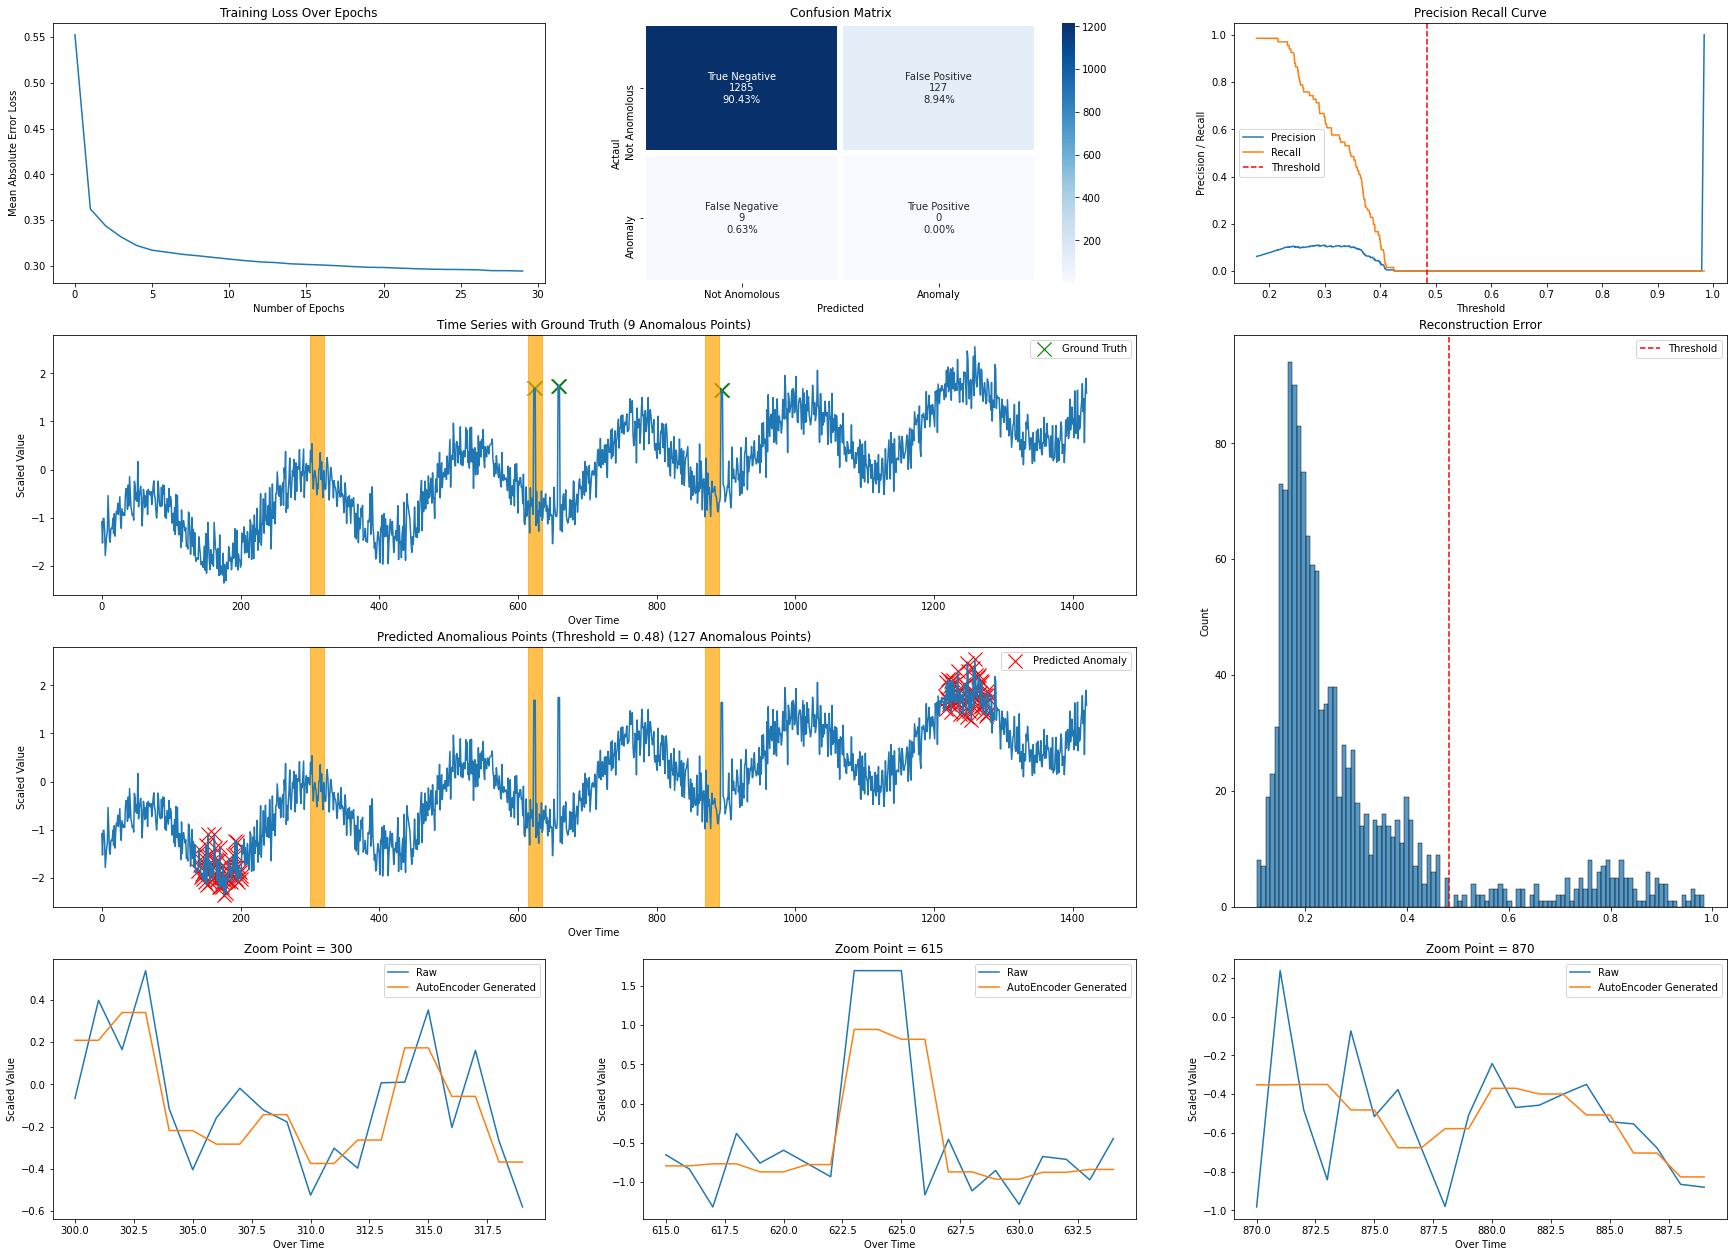

In [30]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_50.csv'
perform_analysis(file=file, ae_type='cnn-2-layer-16', sequence_size=20, zoom_locations=[300, 615, 870])

***

#### Dataset 5 
#### A2Benchmark/synthethic_26.csv

***

- **2 Layer LSTM Auto Encoder with (64-32-32-64) Auto Encoder architecture**
- **Sequence Length = 30**
- **Threshold = 0.270**

Epoch 1/30
44/44 [==============================] - 2s 54ms/step - loss: 0.4877
Epoch 2/30
44/44 [==============================] - 2s 50ms/step - loss: 0.3703
Epoch 3/30
44/44 [==============================] - 2s 49ms/step - loss: 0.2688
Epoch 4/30
44/44 [==============================] - 2s 48ms/step - loss: 0.2437
Epoch 5/30
44/44 [==============================] - 2s 49ms/step - loss: 0.2414
Epoch 6/30
44/44 [==============================] - 2s 49ms/step - loss: 0.2280
Epoch 7/30
44/44 [==============================] - 2s 50ms/step - loss: 0.2275
Epoch 8/30
44/44 [==============================] - 2s 50ms/step - loss: 0.2226
Epoch 9/30
44/44 [==============================] - 2s 48ms/step - loss: 0.2159
Epoch 10/30
44/44 [==============================] - 2s 48ms/step - loss: 0.2138
Epoch 11/30
44/44 [==============================] - 2s 49ms/step - loss: 0.2115
Epoch 12/30
44/44 [==============================] - 2s 52ms/step - loss: 0.2099
Epoch 13/30
44/44 [==================

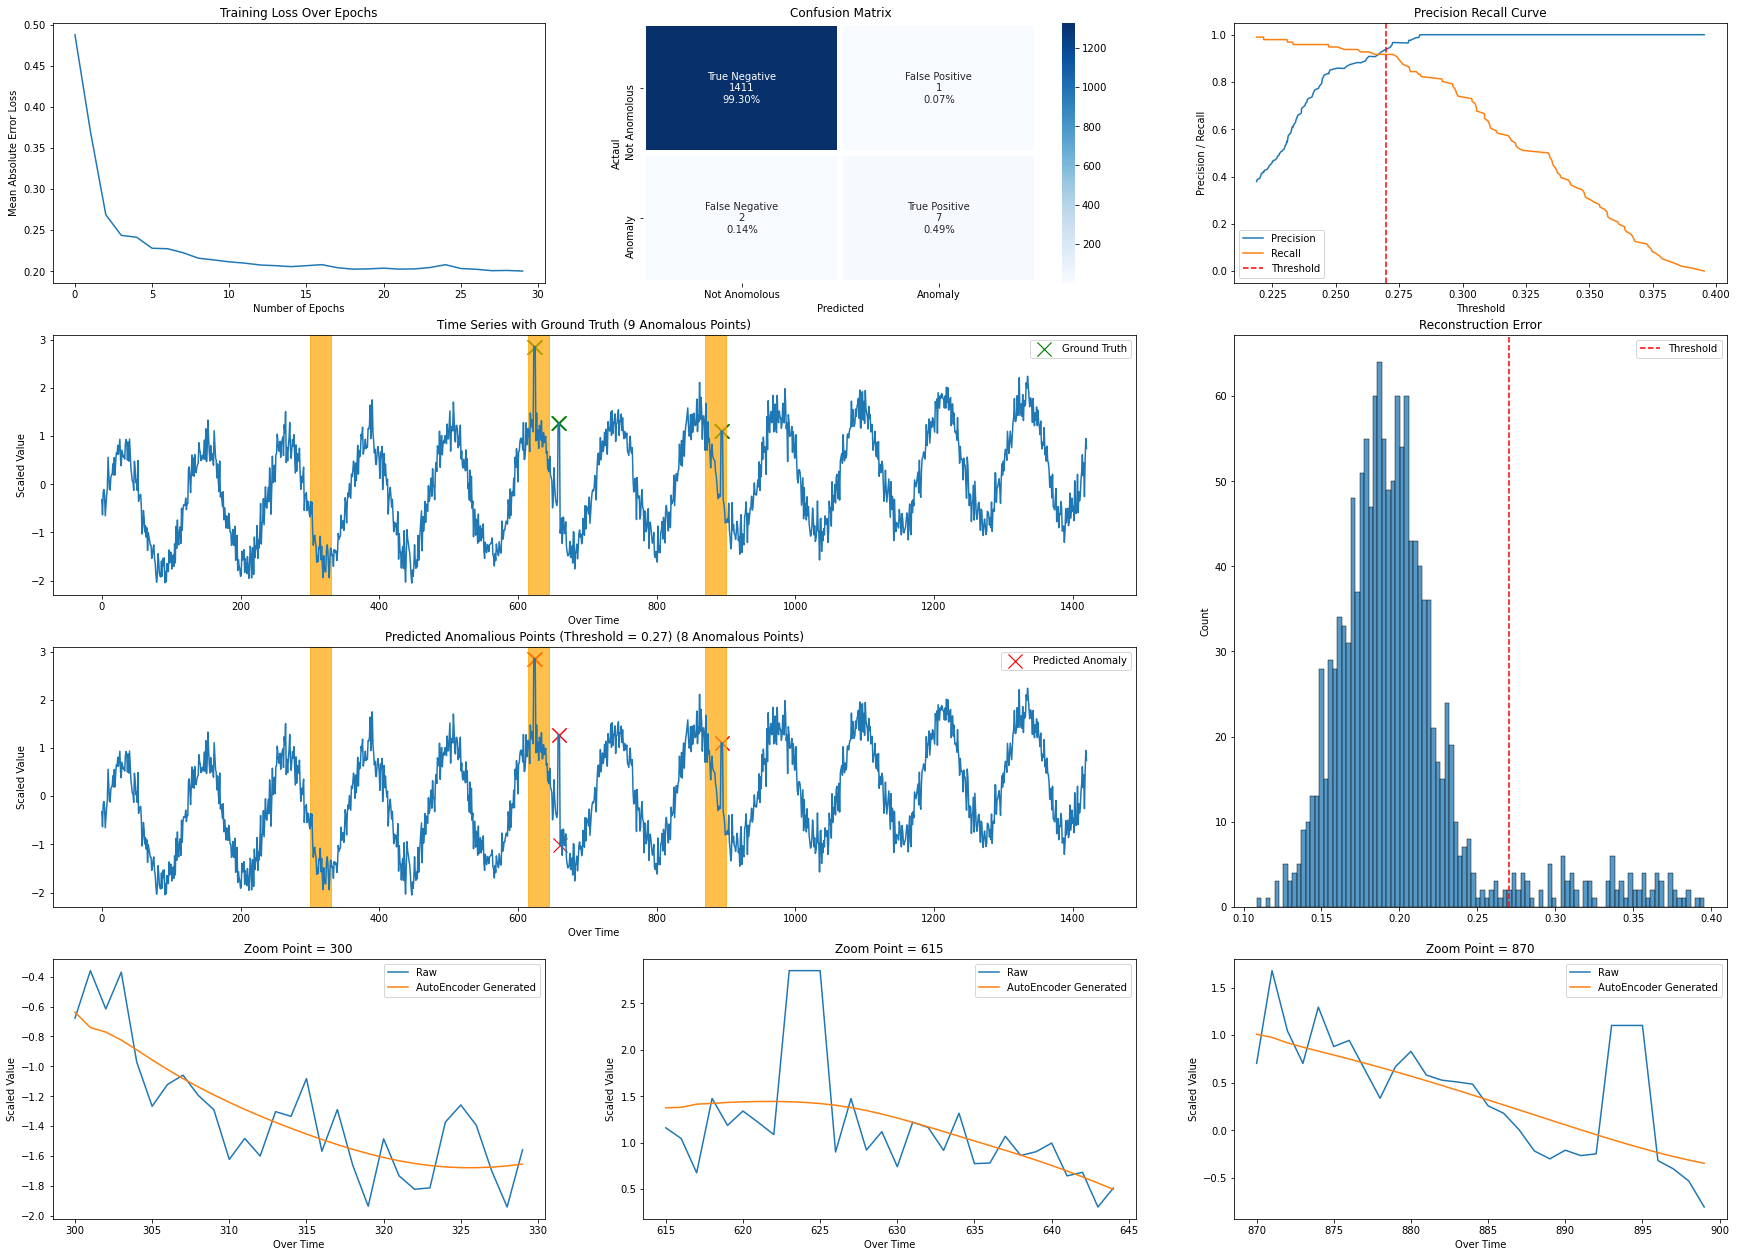

In [31]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_26.csv'
perform_analysis(file=file, ae_type='lstm-2-layer-64', sequence_size=30, zoom_locations=[300, 615, 870], threshold=0.270)

- **2 Layer LSTM Auto Encoder with (128-64-64-128) Auto Encoder architecture**
- **Sequence Length = 30**
- **Threshold = 0.270**

Epoch 1/30
44/44 [==============================] - 6s 133ms/step - loss: 0.4649
Epoch 2/30
44/44 [==============================] - 5s 113ms/step - loss: 0.2906
Epoch 3/30
44/44 [==============================] - 4s 84ms/step - loss: 0.2452
Epoch 4/30
44/44 [==============================] - 5s 108ms/step - loss: 0.2440 0s - loss: 
Epoch 5/30
44/44 [==============================] - 4s 91ms/step - loss: 0.2242
Epoch 6/30
44/44 [==============================] - 3s 72ms/step - loss: 0.2151
Epoch 7/30
44/44 [==============================] - 4s 85ms/step - loss: 0.2190
Epoch 8/30
44/44 [==============================] - 4s 82ms/step - loss: 0.2179
Epoch 9/30
44/44 [==============================] - 4s 90ms/step - loss: 0.2135
Epoch 10/30
44/44 [==============================] - 3s 76ms/step - loss: 0.2094
Epoch 11/30
44/44 [==============================] - 4s 82ms/step - loss: 0.2063
Epoch 12/30
44/44 [==============================] - 3s 79ms/step - loss: 0.2051
Epoch 13/30
44/44 [===

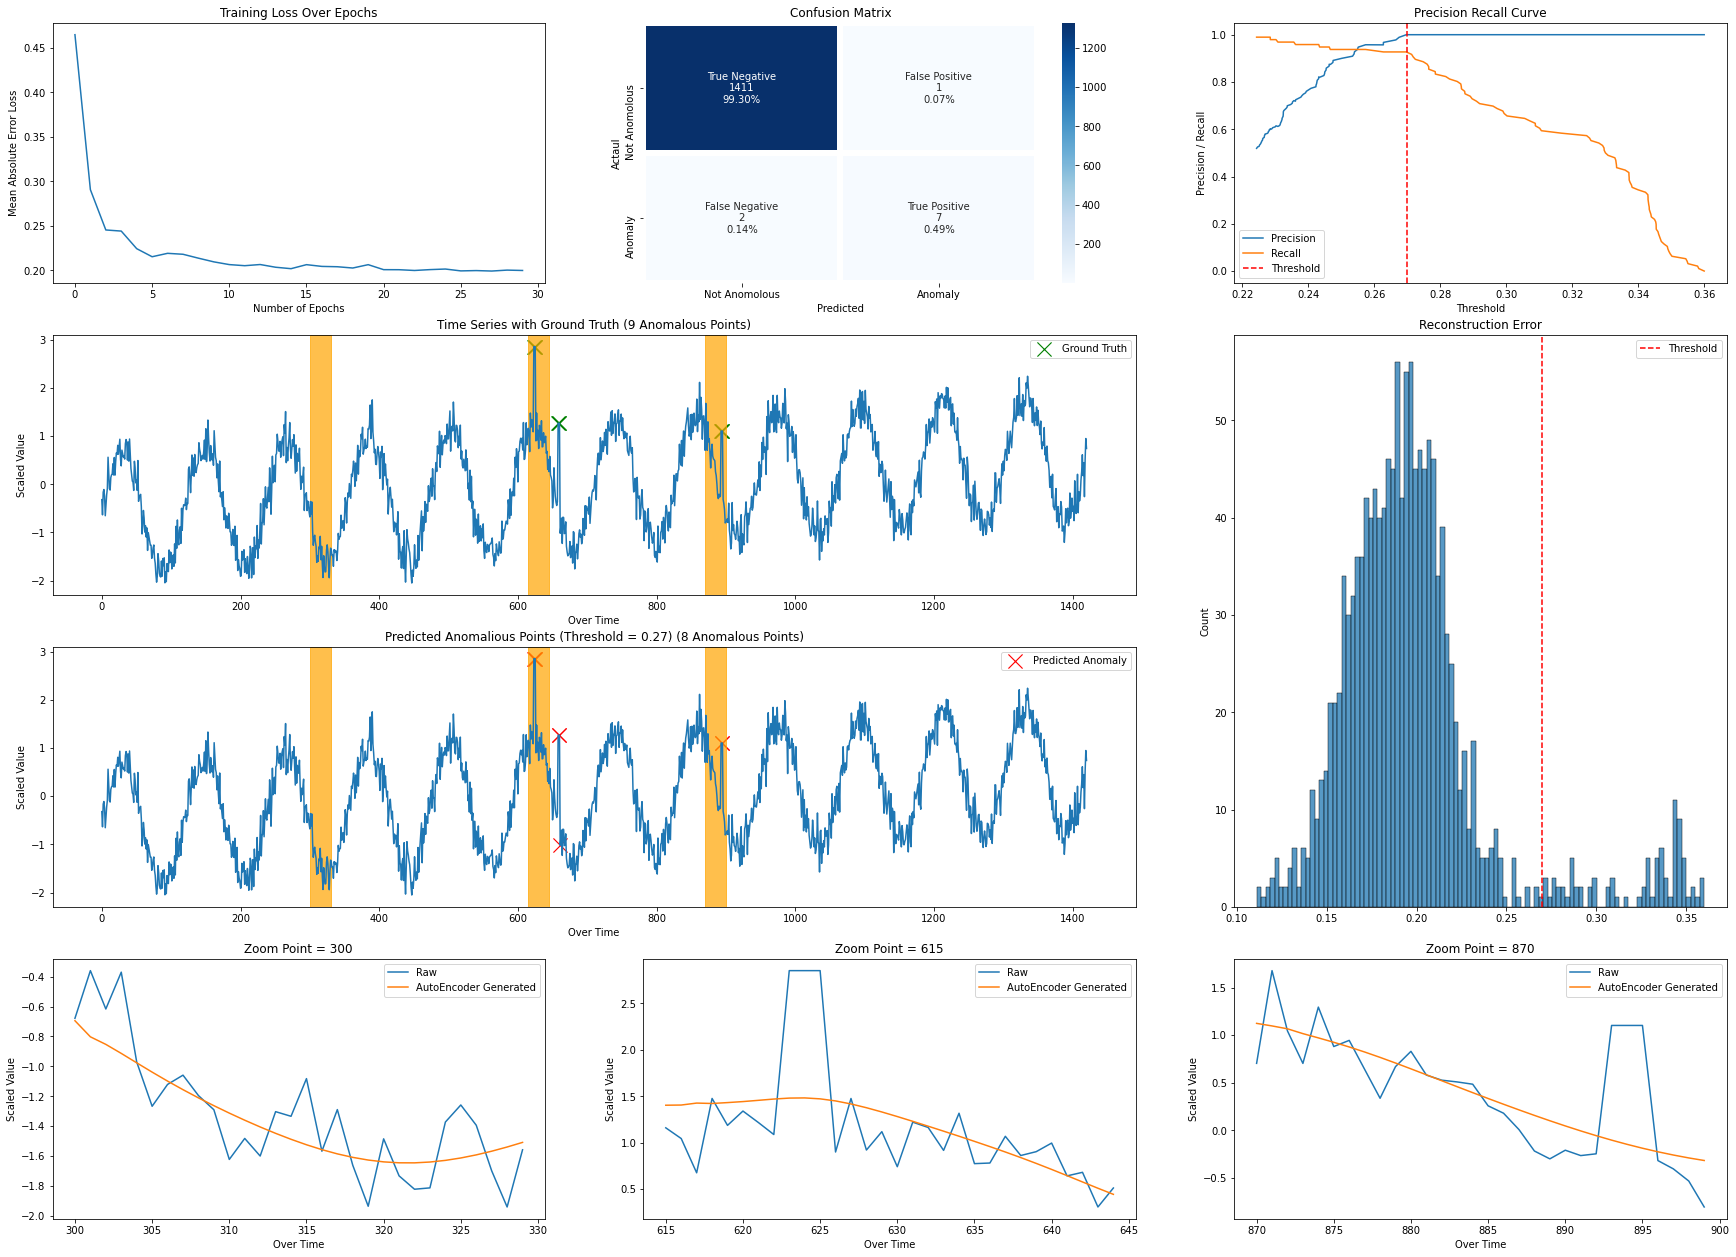

In [32]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_26.csv'
perform_analysis(file=file, ae_type='lstm-2-layer-128', sequence_size=30, zoom_locations=[300, 615, 870], threshold=0.270)

***

#### Dataset 6 
#### A2Benchmark/synthethic_20.csv

***

- **2 Layer LSTM Auto Encoder with (128-64-64-128) Auto Encoder architecture**
- **Sequence Length = 40**

Epoch 1/30
44/44 [==============================] - 6s 147ms/step - loss: 0.4258
Epoch 2/30
44/44 [==============================] - 6s 143ms/step - loss: 0.3150
Epoch 3/30
44/44 [==============================] - 8s 171ms/step - loss: 0.2488
Epoch 4/30
44/44 [==============================] - 6s 142ms/step - loss: 0.2106
Epoch 5/30
44/44 [==============================] - 5s 114ms/step - loss: 0.2023
Epoch 6/30
44/44 [==============================] - 4s 90ms/step - loss: 0.1980
Epoch 7/30
44/44 [==============================] - 4s 89ms/step - loss: 0.1913
Epoch 8/30
44/44 [==============================] - 4s 89ms/step - loss: 0.1894
Epoch 9/30
44/44 [==============================] - 4s 89ms/step - loss: 0.1875
Epoch 10/30
44/44 [==============================] - 4s 89ms/step - loss: 0.1909
Epoch 11/30
44/44 [==============================] - 4s 91ms/step - loss: 0.1886
Epoch 12/30
44/44 [==============================] - 4s 90ms/step - loss: 0.1826
Epoch 13/30
44/44 [=============

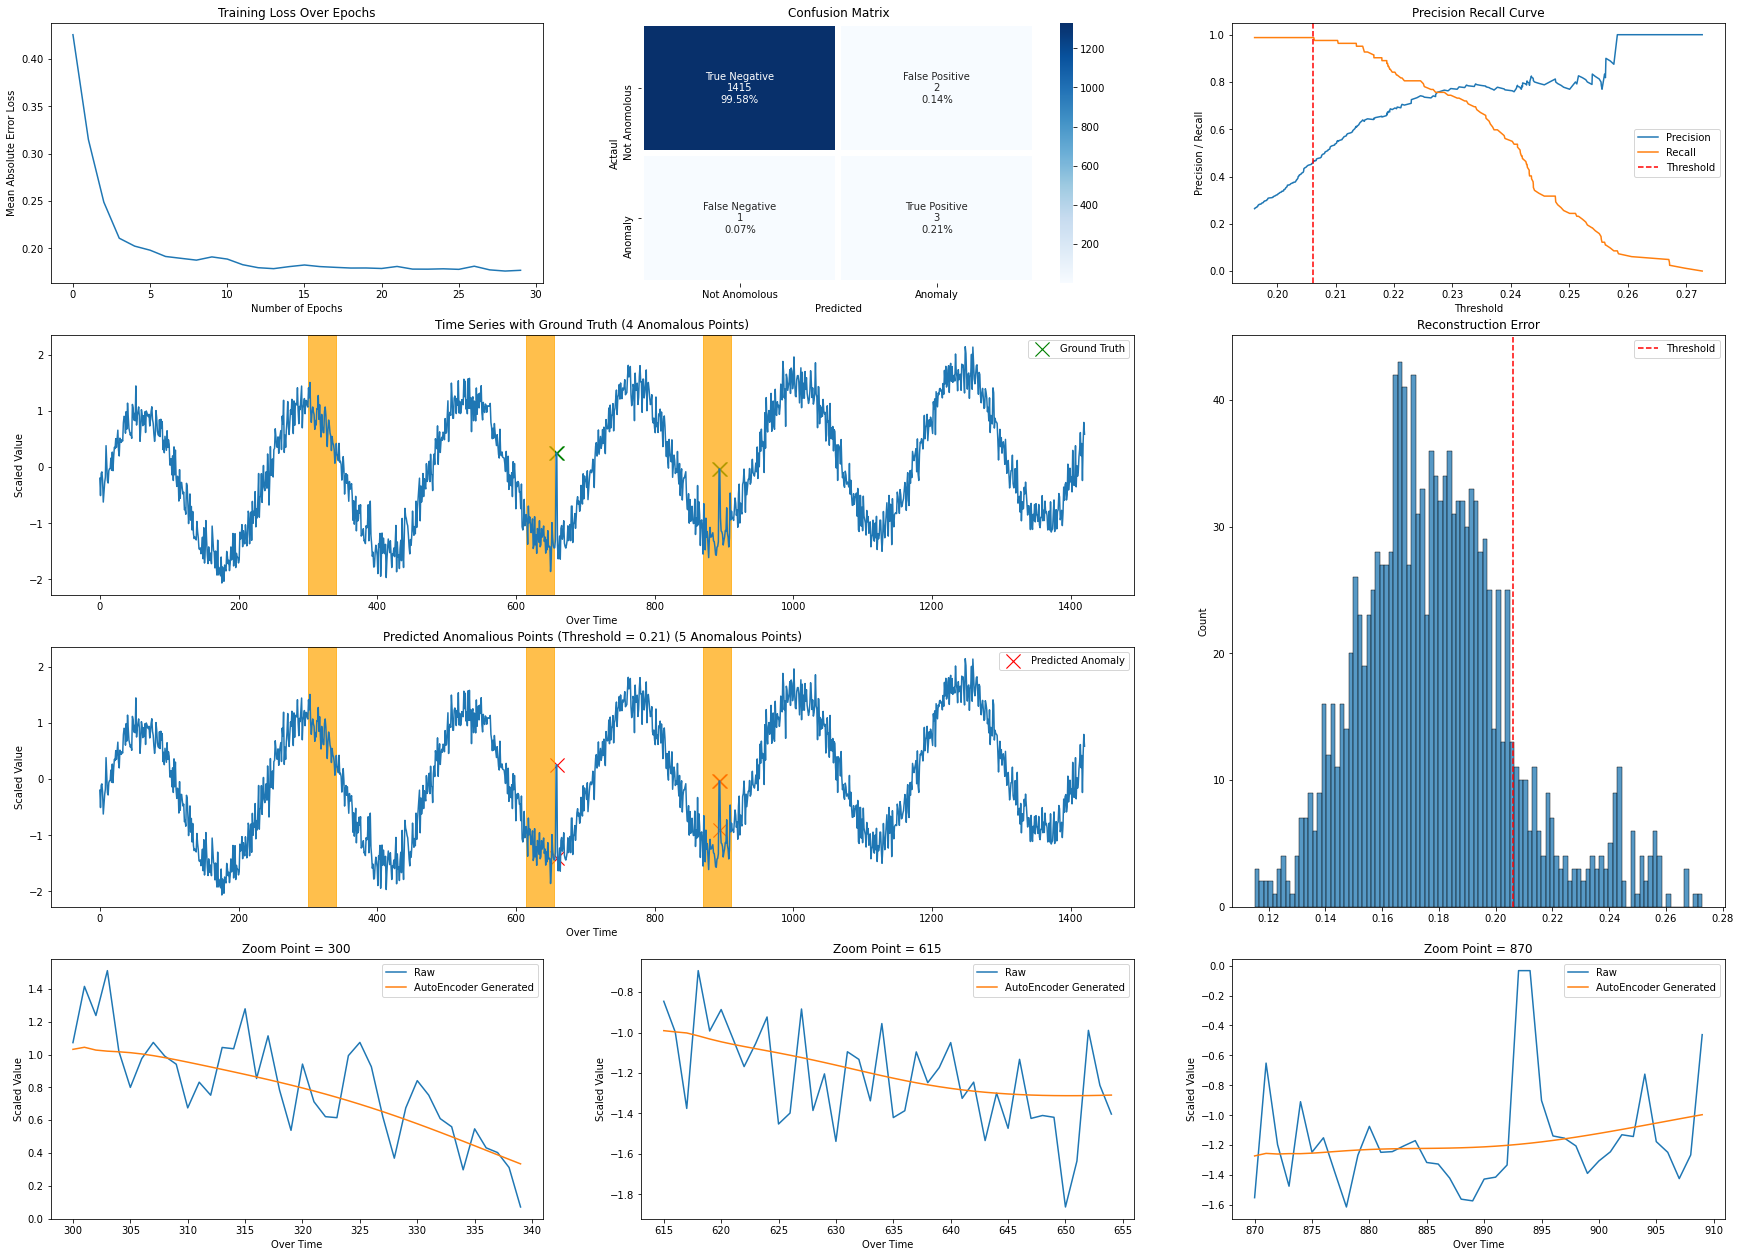

In [33]:
file = './datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_22.csv'
perform_analysis(file=file, ae_type='lstm-2-layer-128', sequence_size=40, zoom_locations=[300, 615, 870])

***

### Changes and Experiements working upon
- Working on implmenting the Denoising and Variational Auto encoders to understand its effect on finding anomalies on a time series data 
- Working on implmetning dynamic thresholding and selecting sequence / timesteps length 

***

### References
- https://towardsdatascience.com/autoencoders-for-the-compression-of-stock-market-data-28e8c1a2da3e
- https://www.kaggle.com/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders

***

### Appendix

***

#### Plotting Various datasets

In [120]:
def plotter(file_list):
    for r in range(12, len(file_list) + 12, 12):
        fig, ax = plt.subplots(3,4, figsize=(30,22), sharey=True); ax=ax.reshape(-1)
        i = 0
        for file in file_list[r-12:r]:
            data = pd.read_csv(file)
            ct = ColumnTransformer([('scaler',StandardScaler(),['value'])], remainder='drop')
            data['scaled_value'] = ct.fit_transform(data)
            anomalies = data[data.is_anomaly >0]
            _ = sns.lineplot(data=data, x='timestamp', y='scaled_value', ax=ax[i])
            _ = sns.scatterplot(data=anomalies, x='timestamp',y='scaled_value', color='r', marker='x', s= 100, ax=ax[i])        
            _ = ax[i].set_title('{}\nAnomaly Count - {}'.format('/'.join(file.split('/')[-2:]), anomalies.is_anomaly.sum()))
            _ = ax[i].set_xlabel('Over Time')
            _ = ax[i].set_xlabel('Scaled Value')
            i+=1
        plt.show(fig)

#### A1Benchmark Dataset

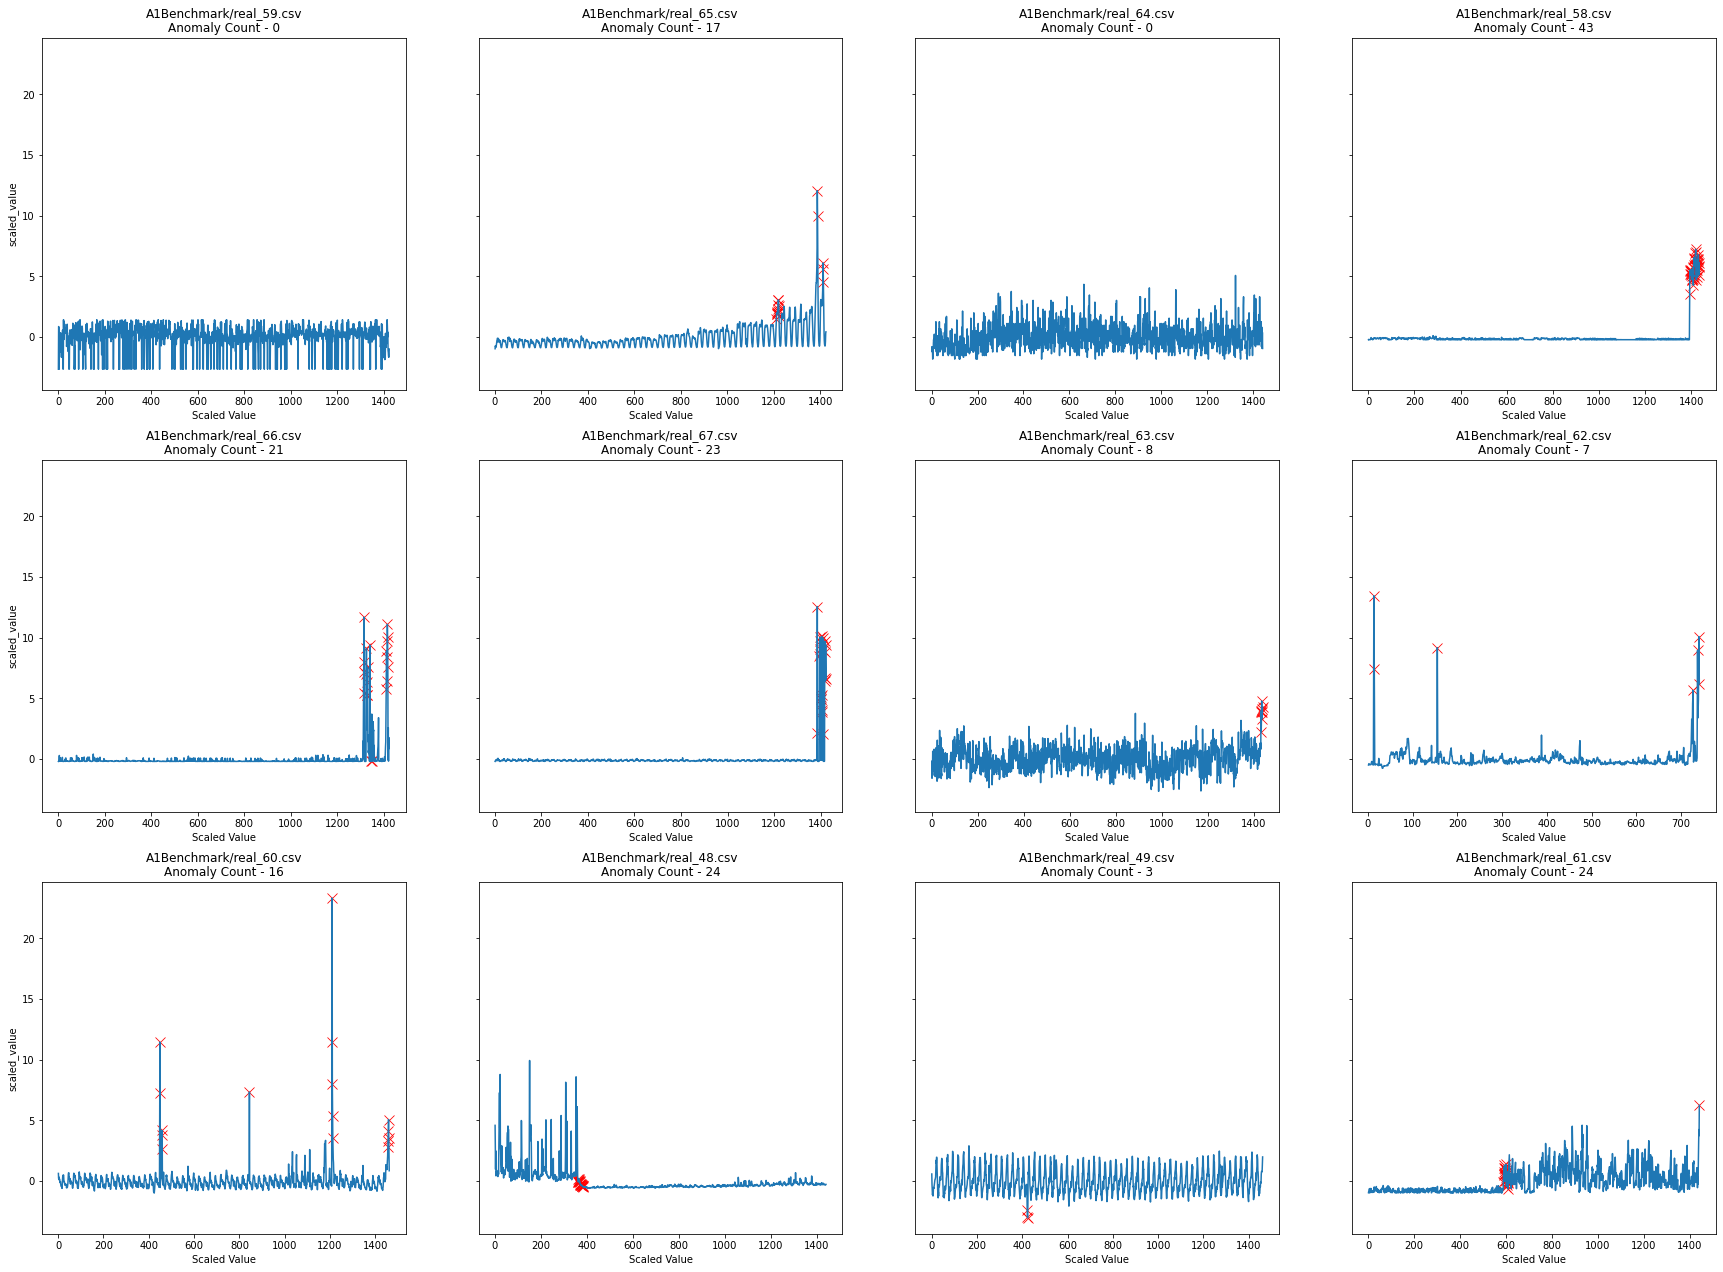

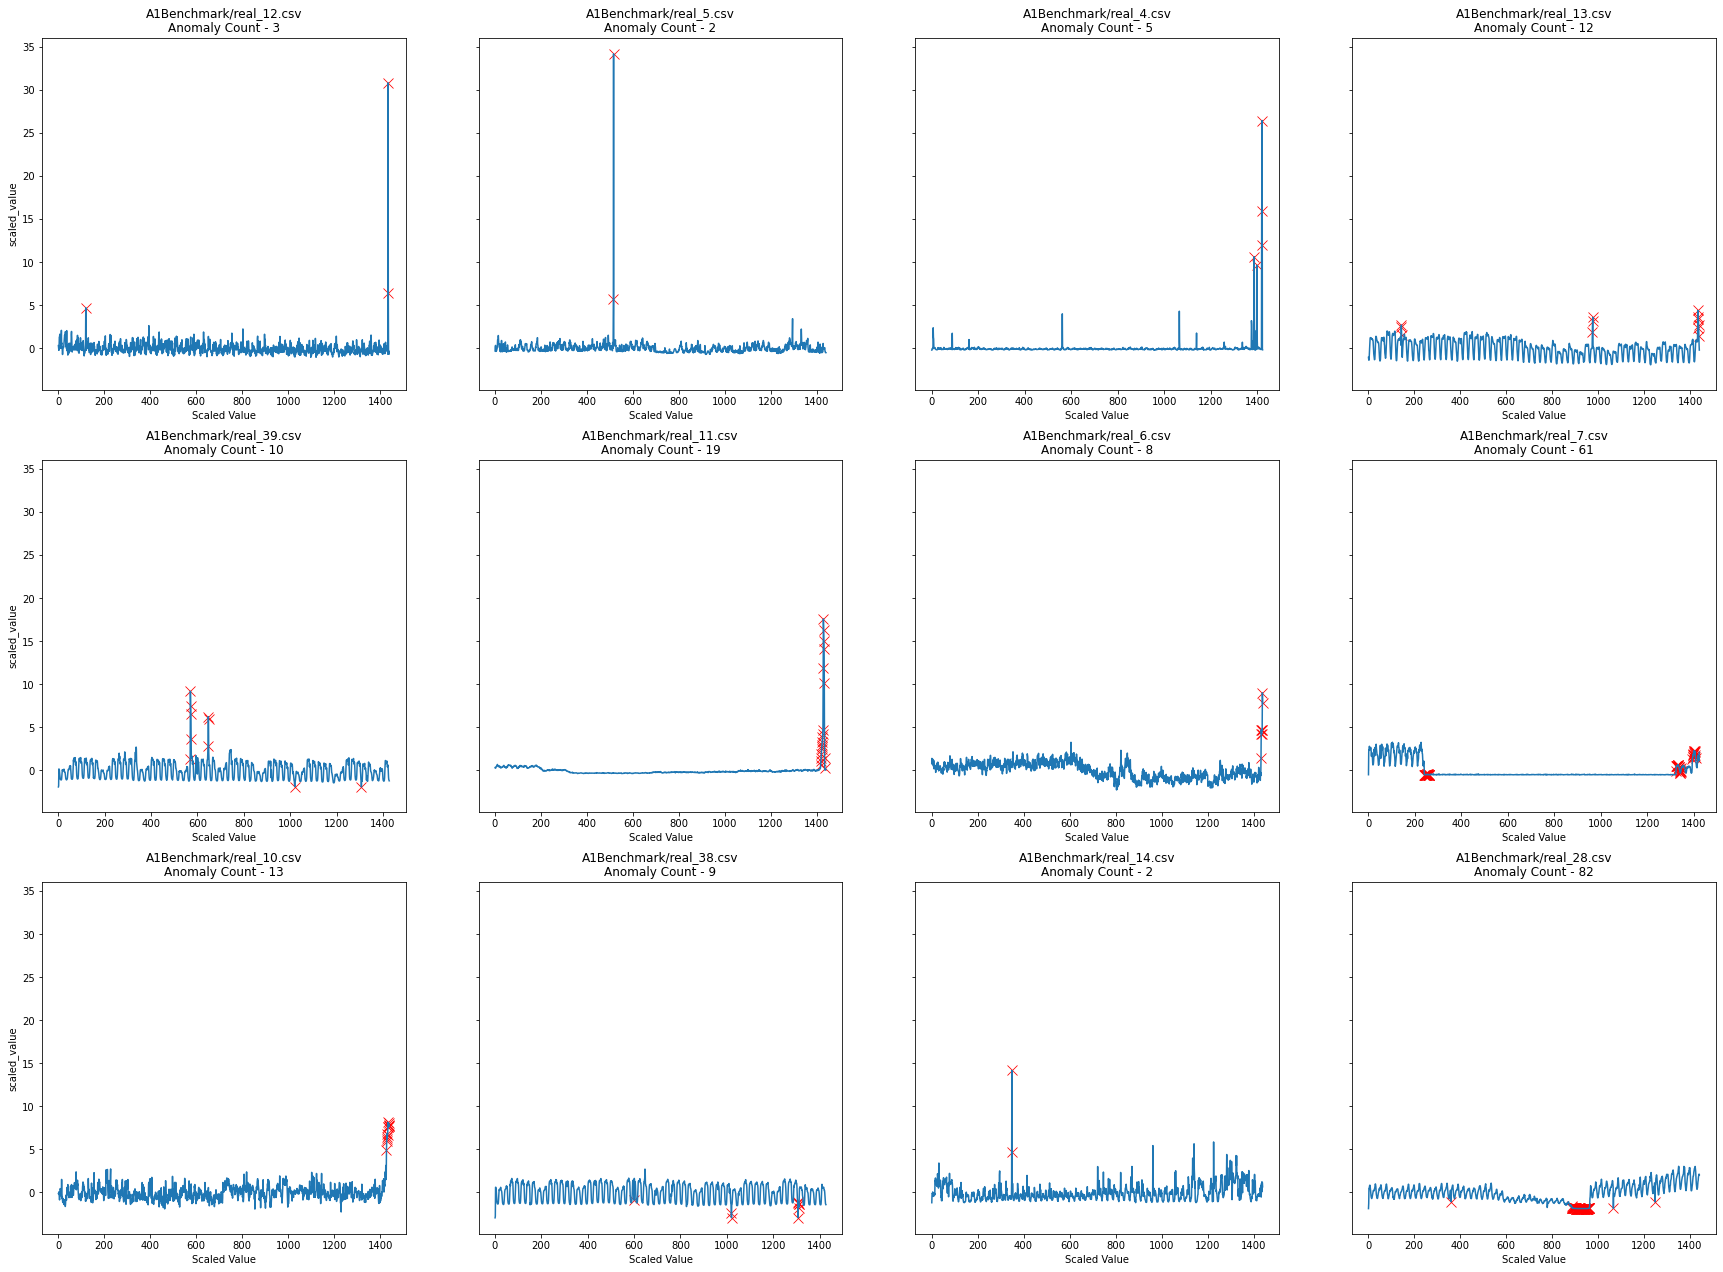

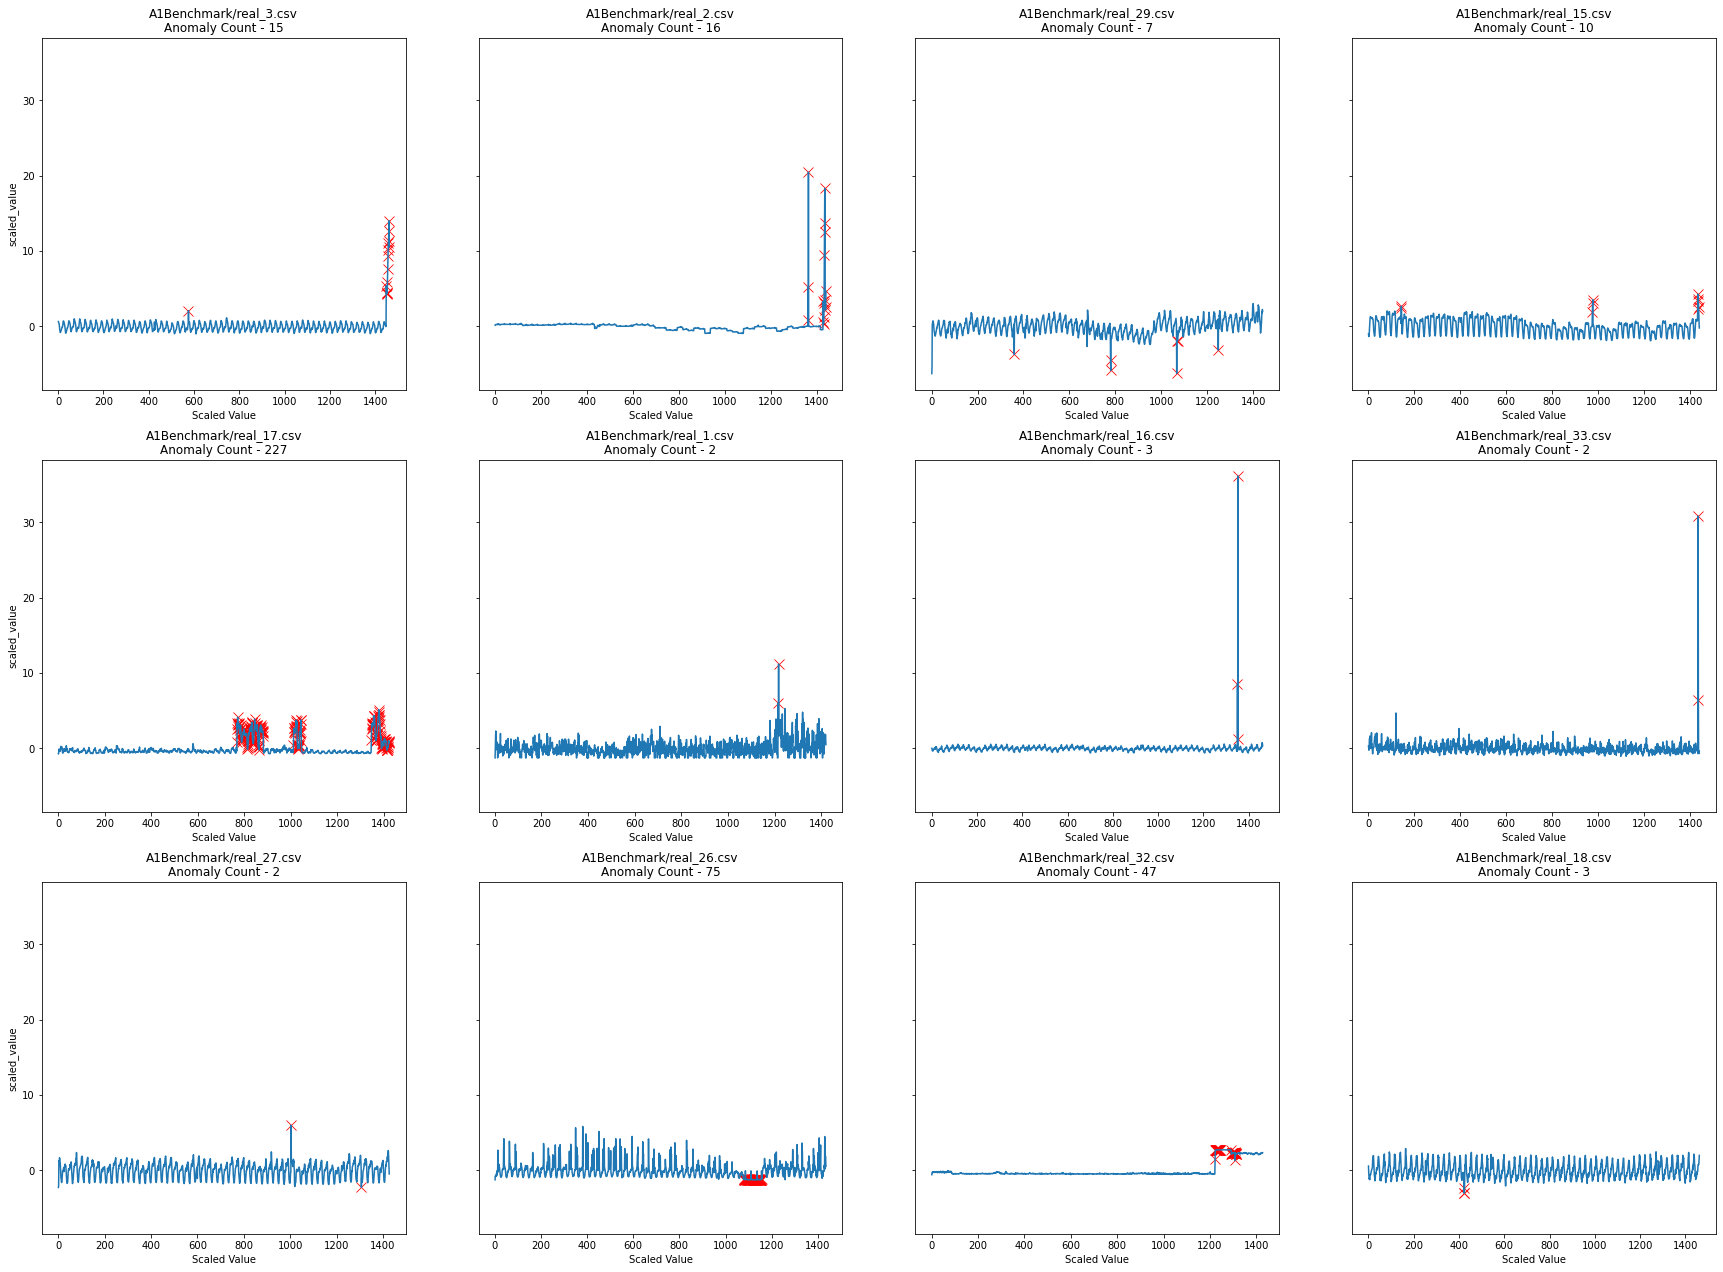

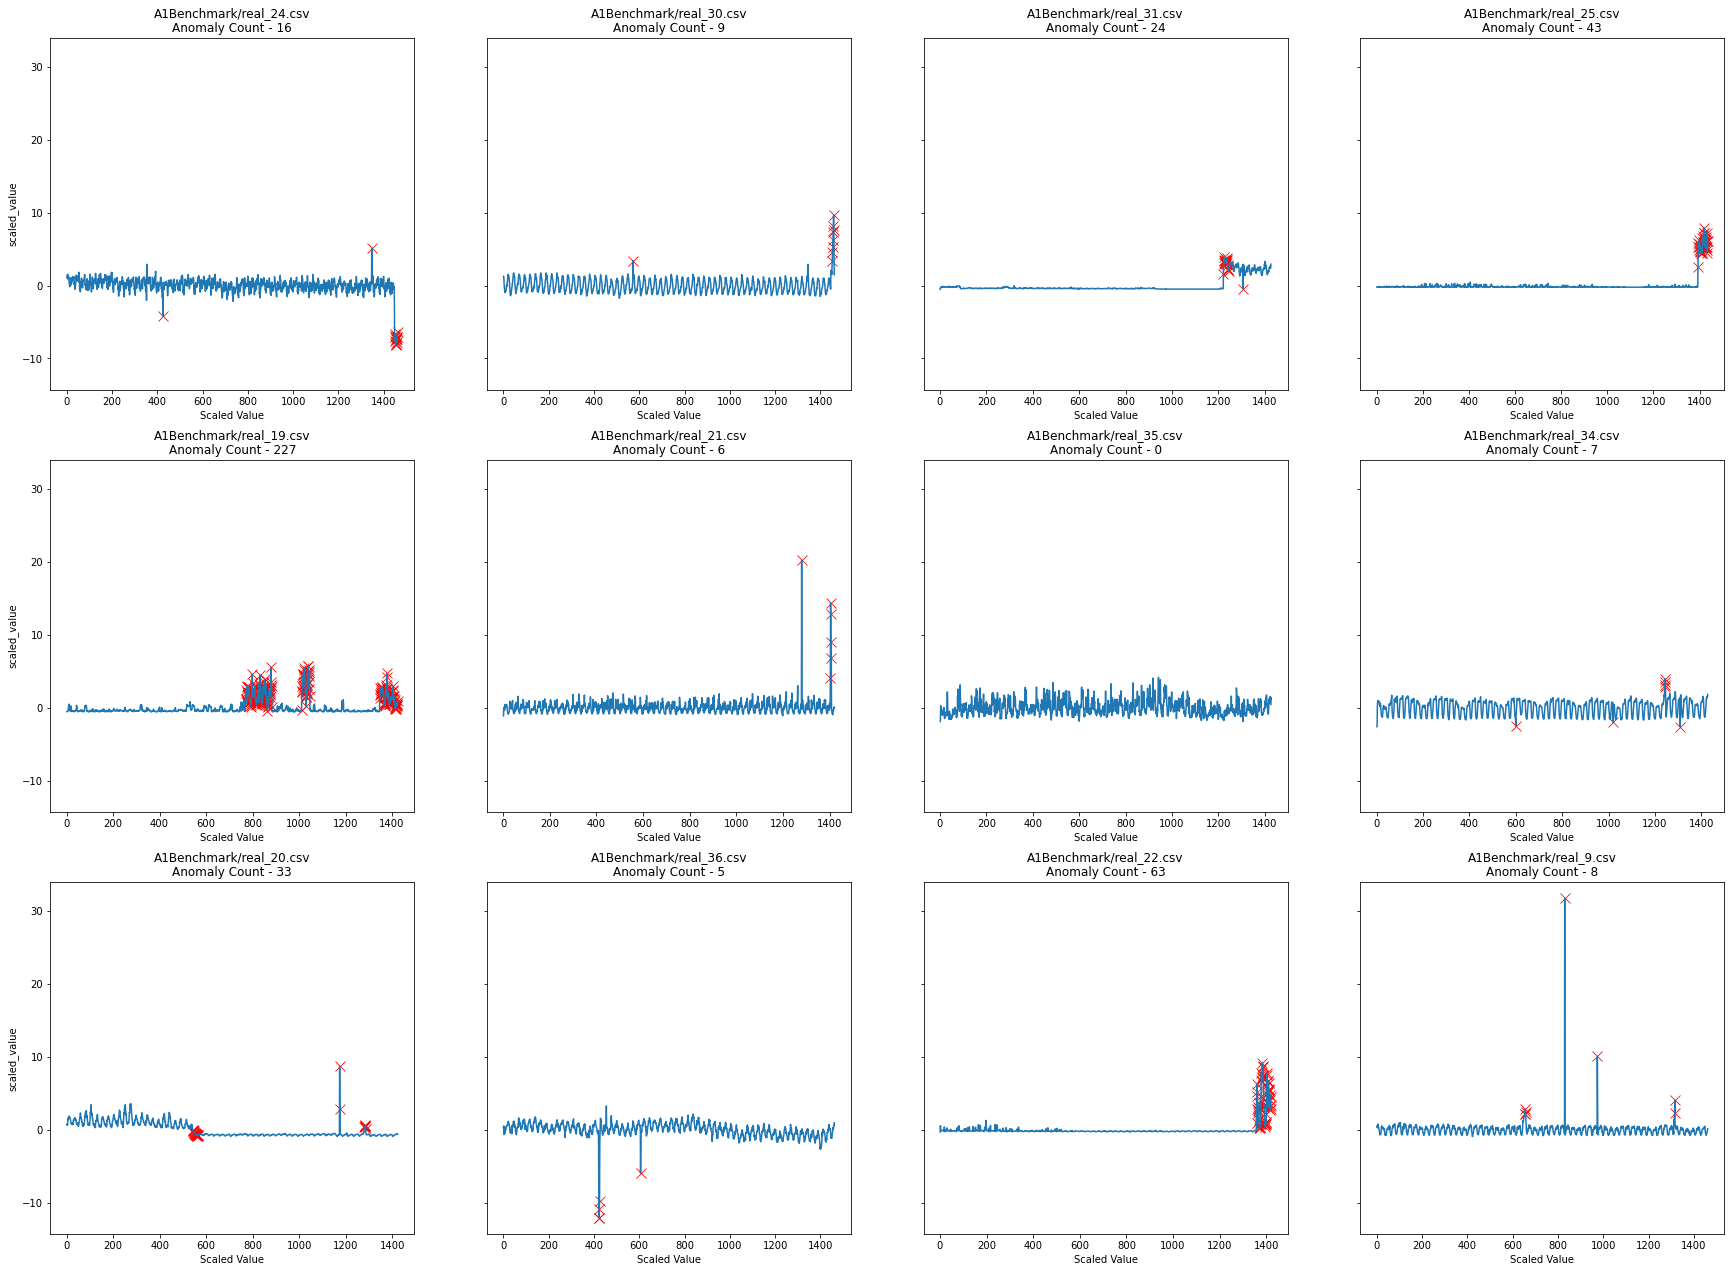

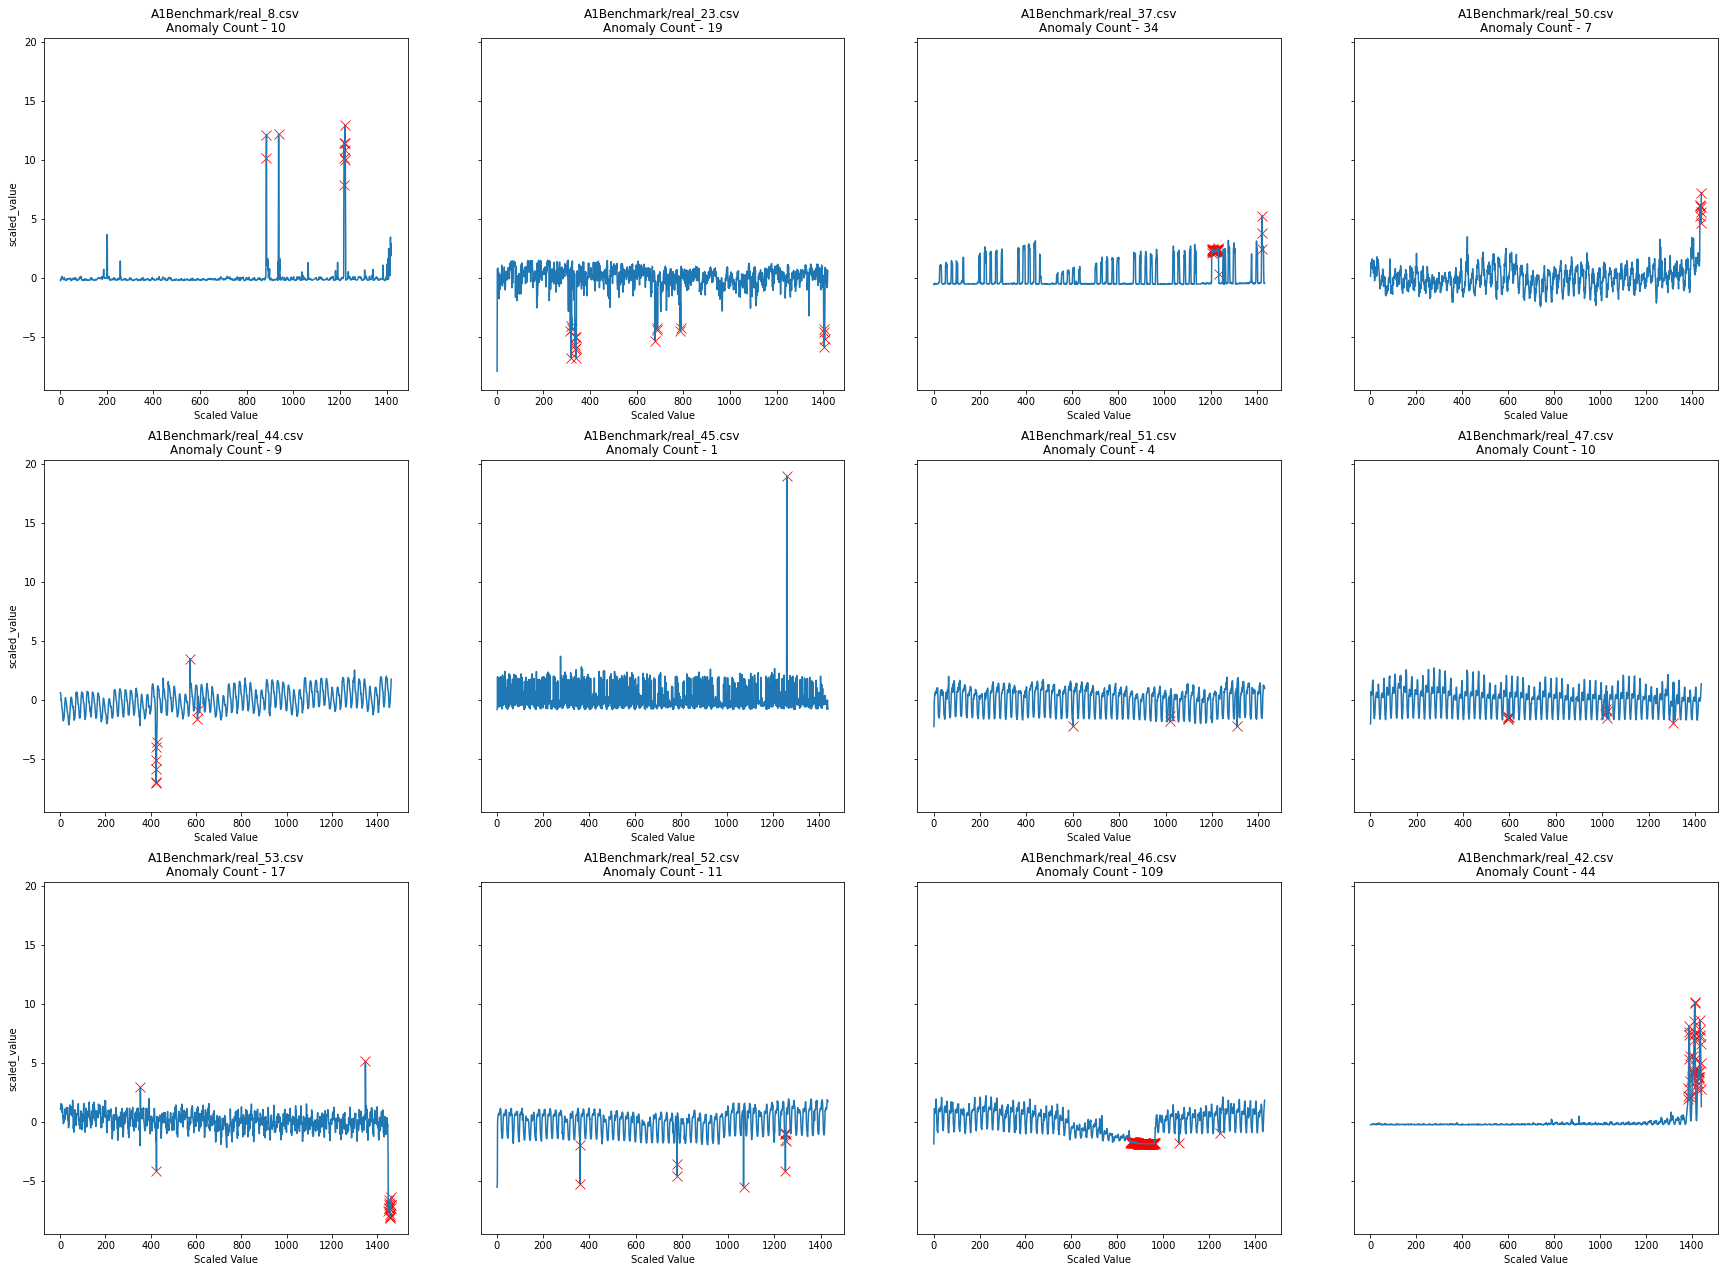

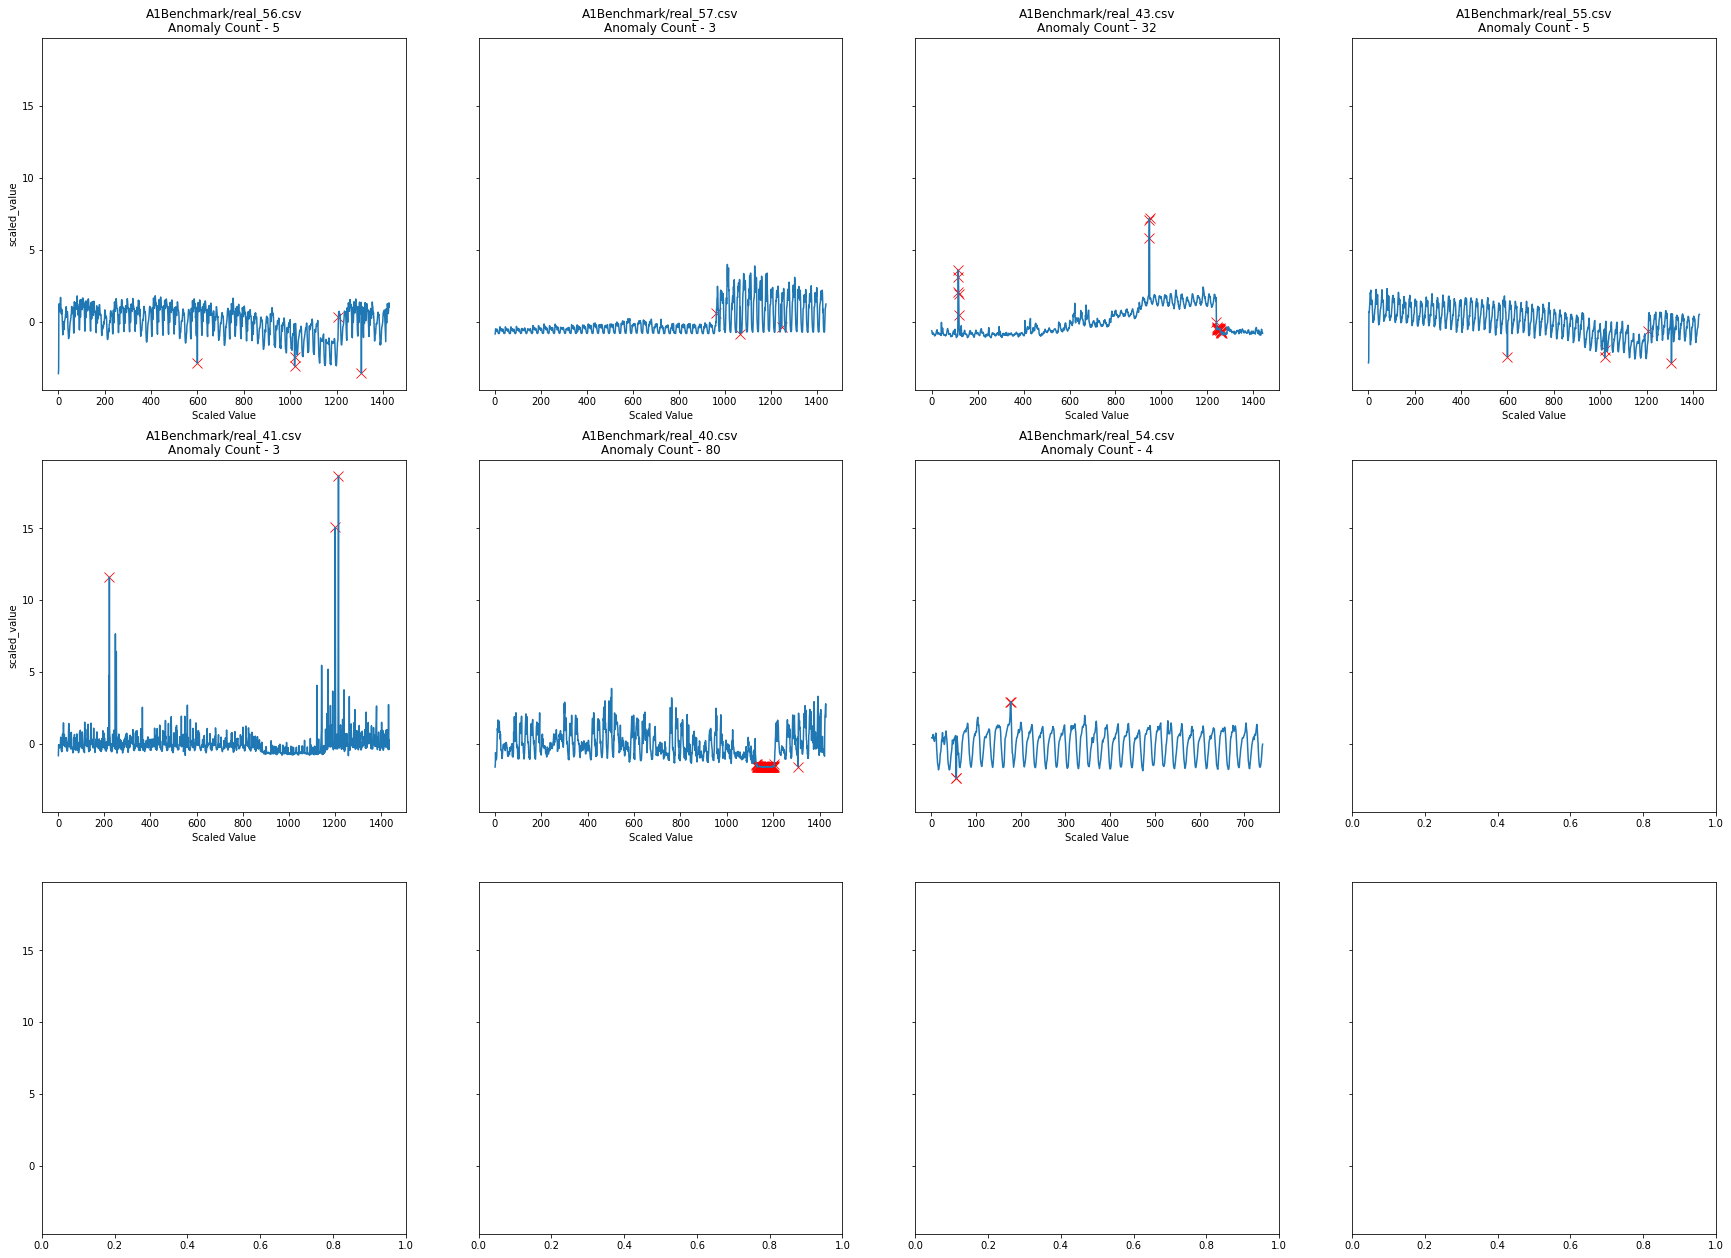

In [121]:
plotter(glob.glob('./datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/*'))

***

#### A2Benchmark Dataset

***

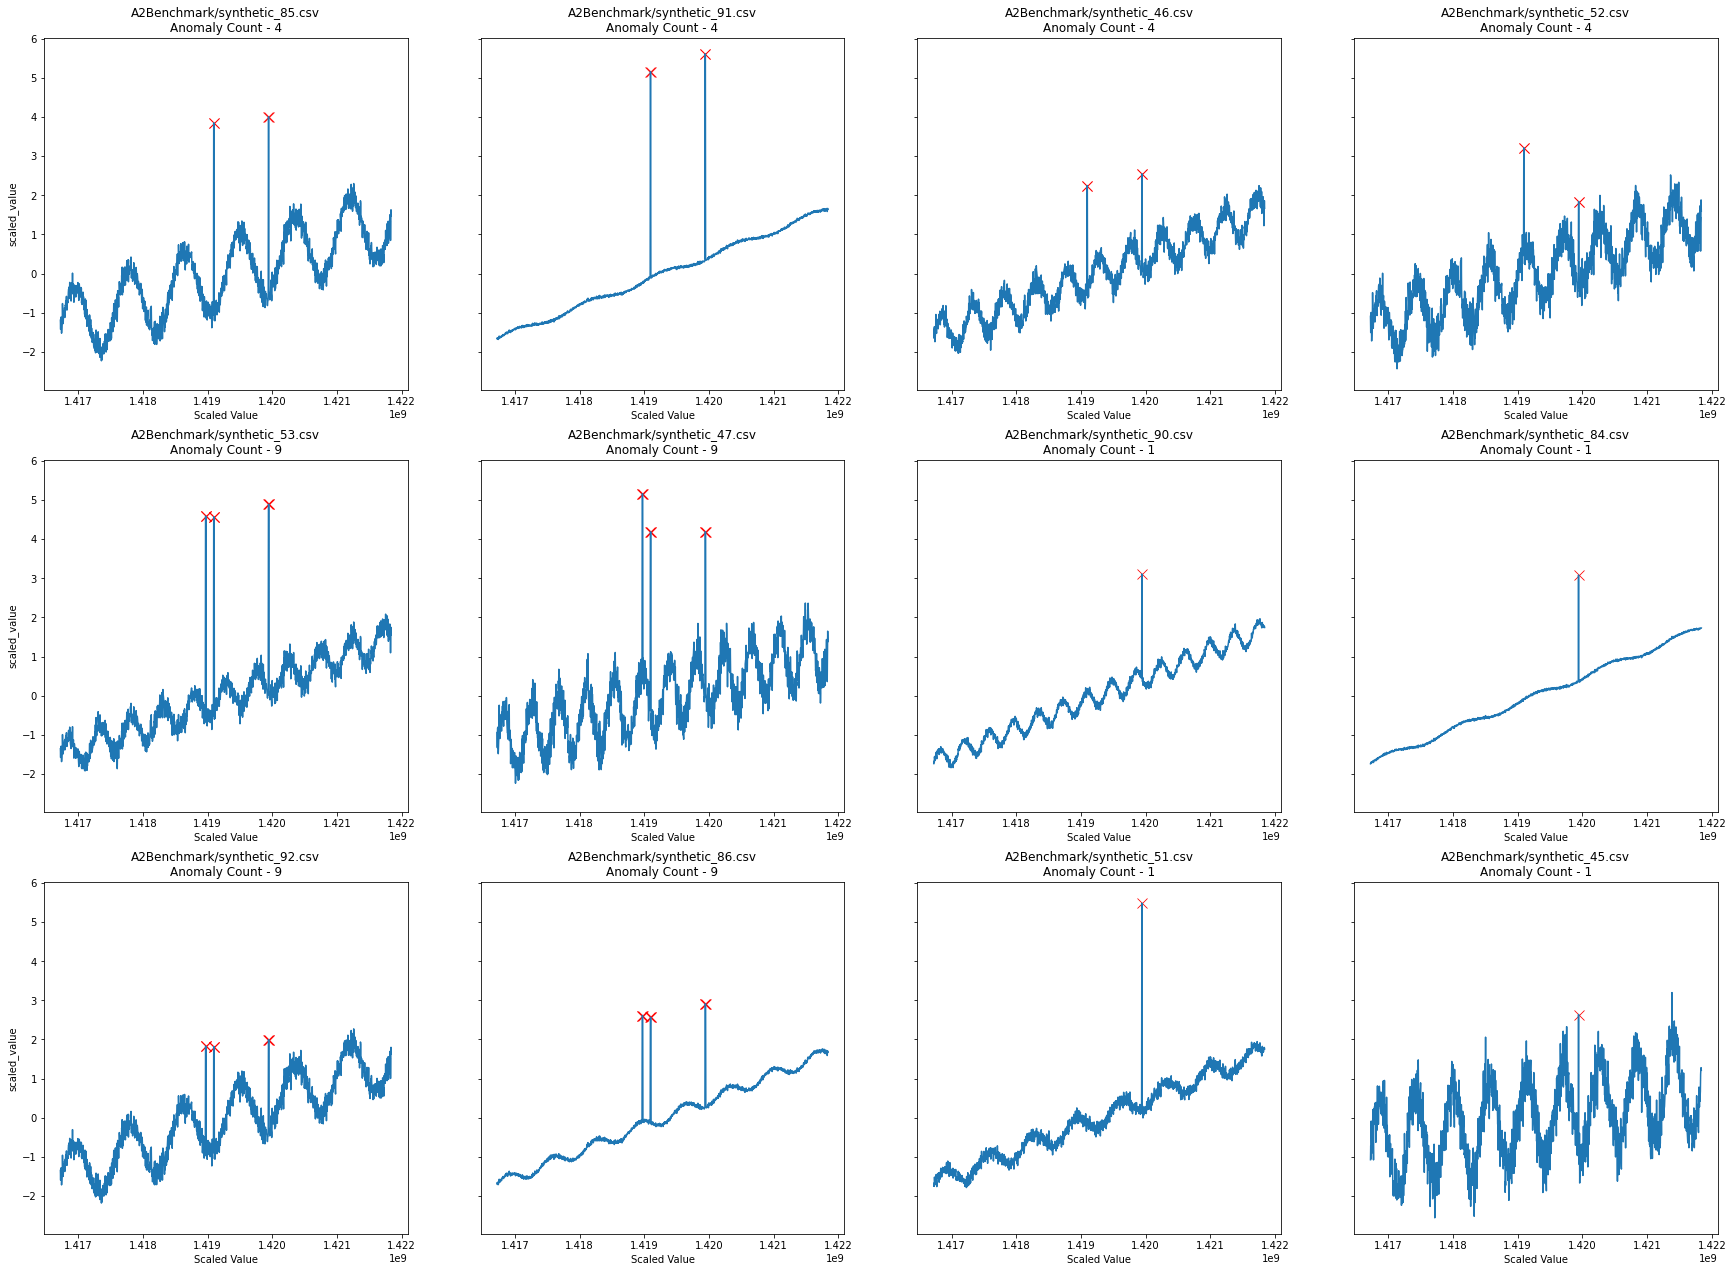

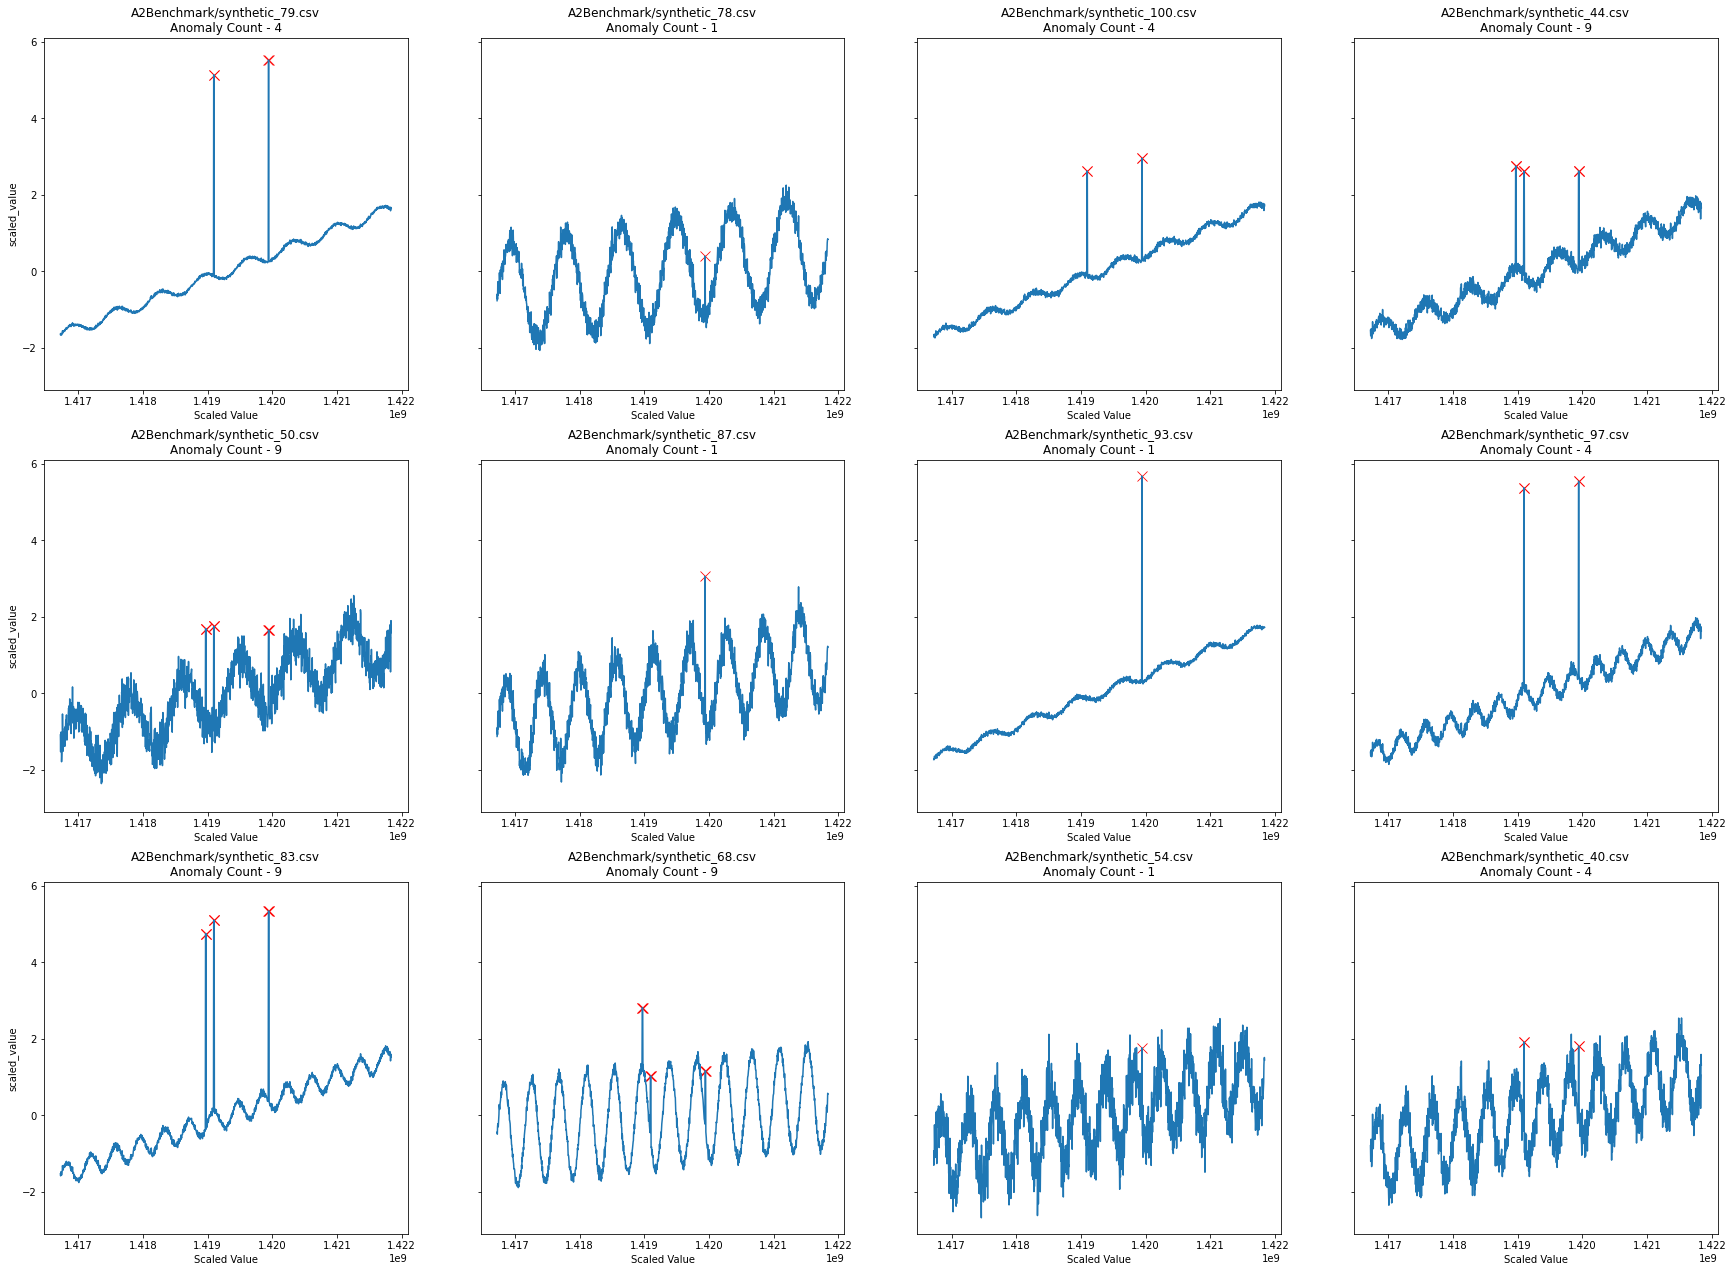

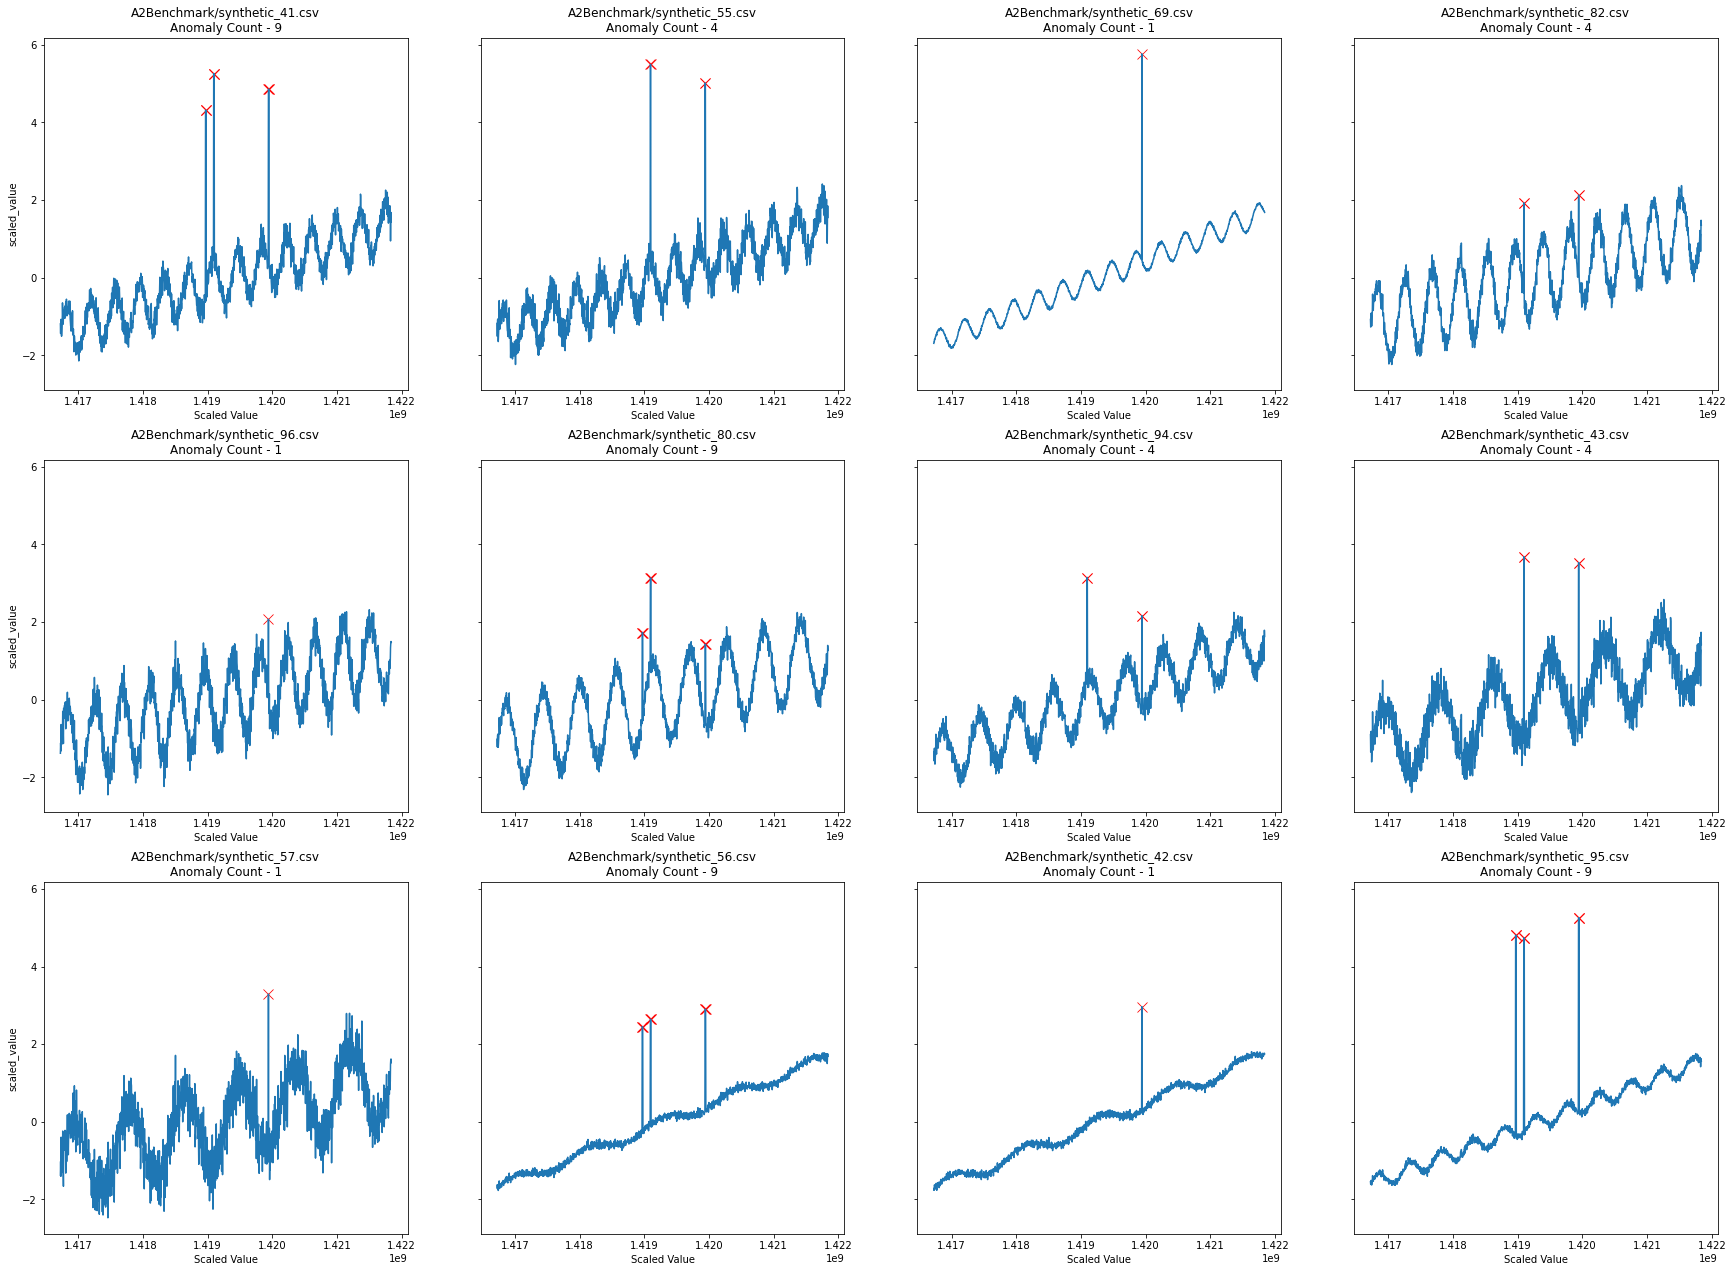

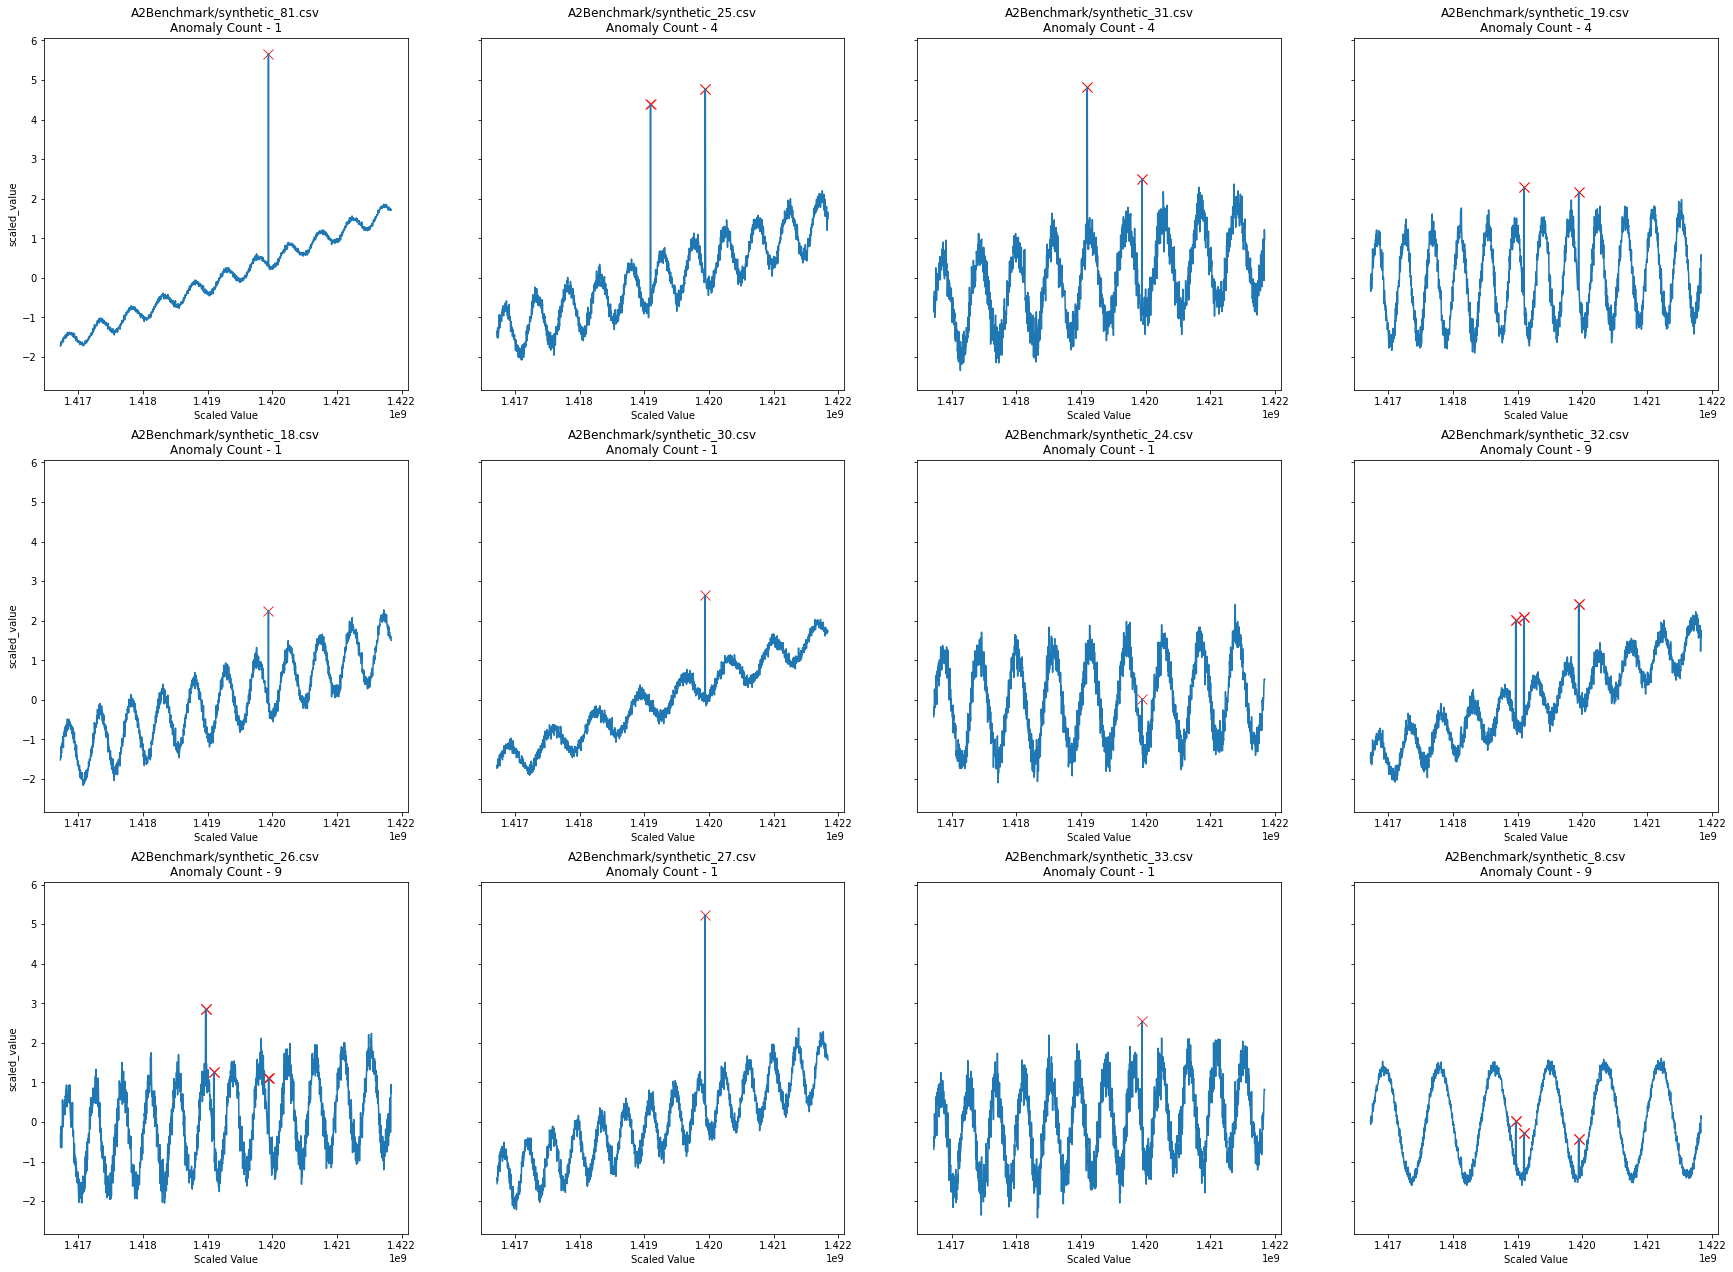

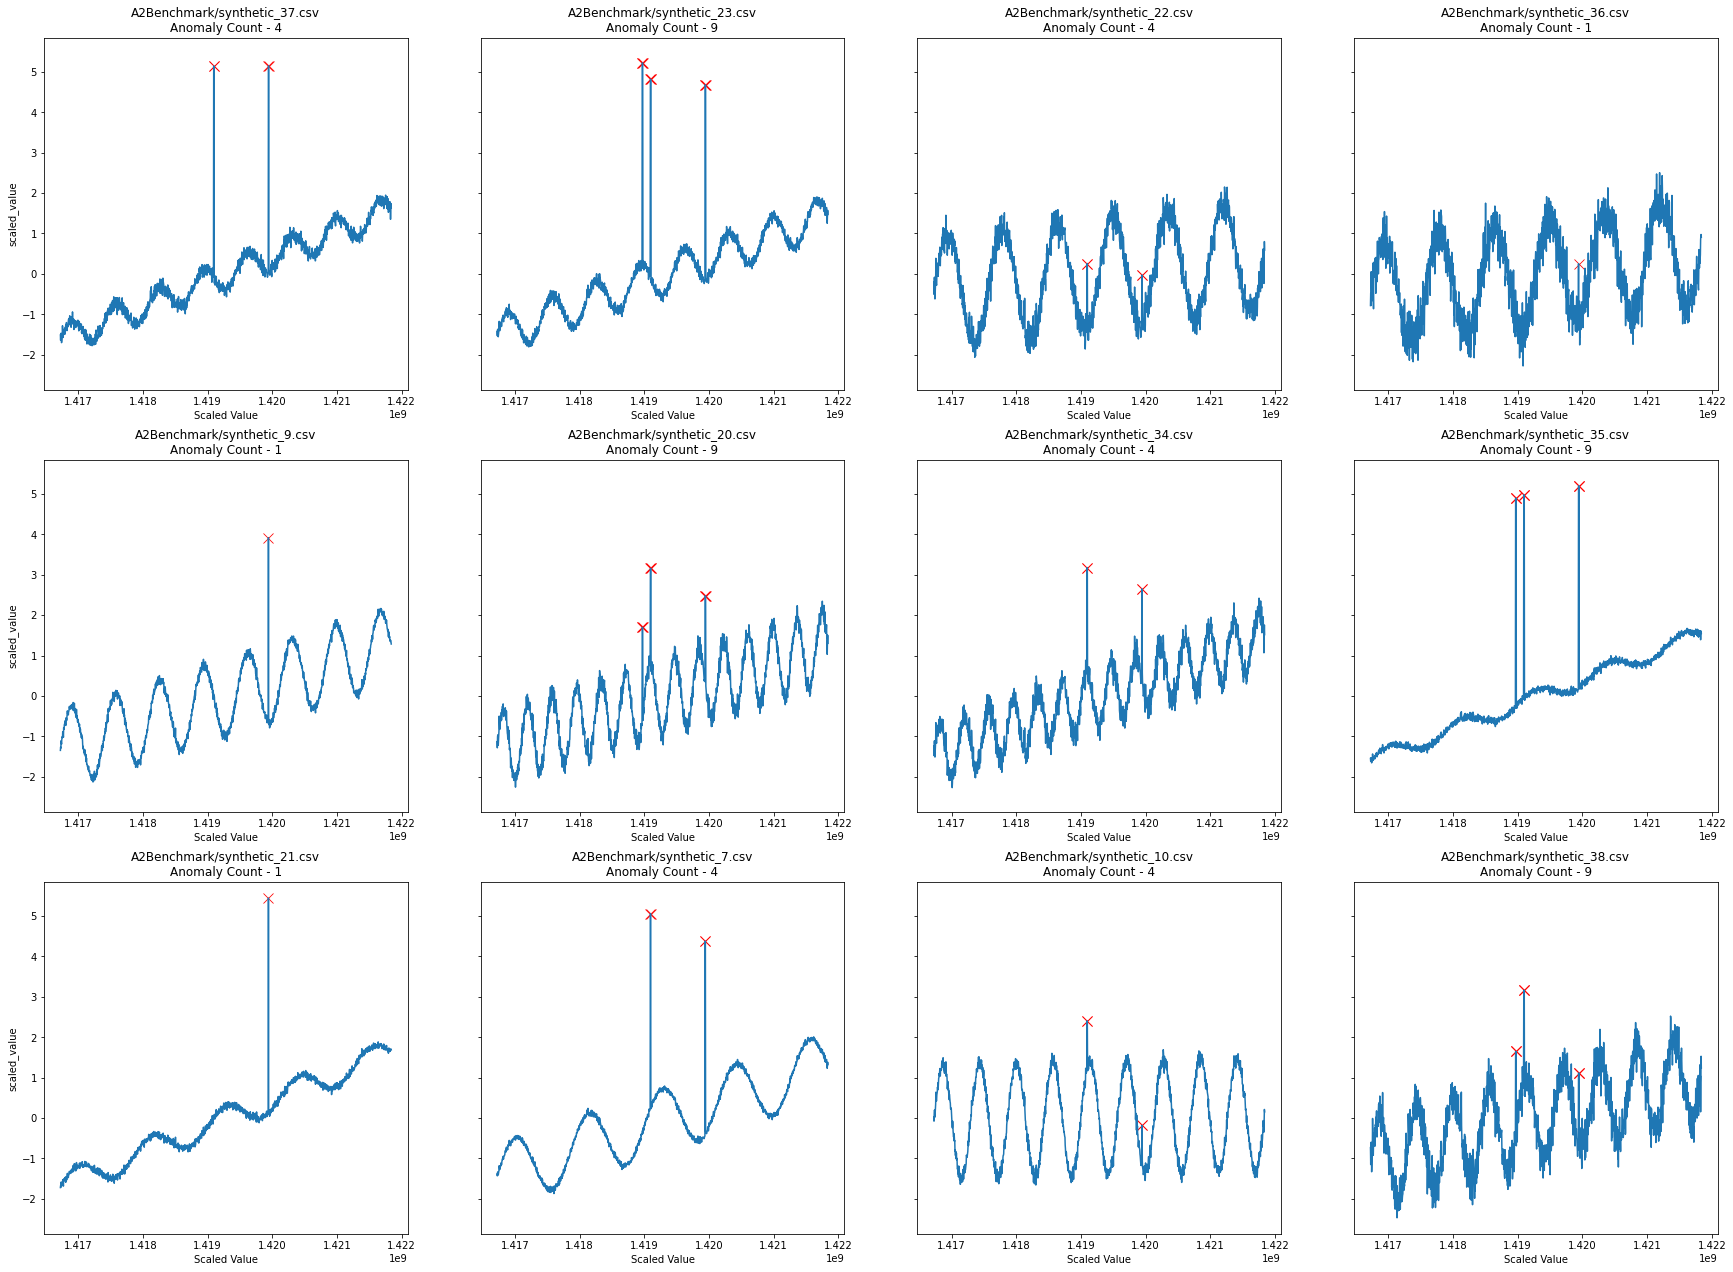

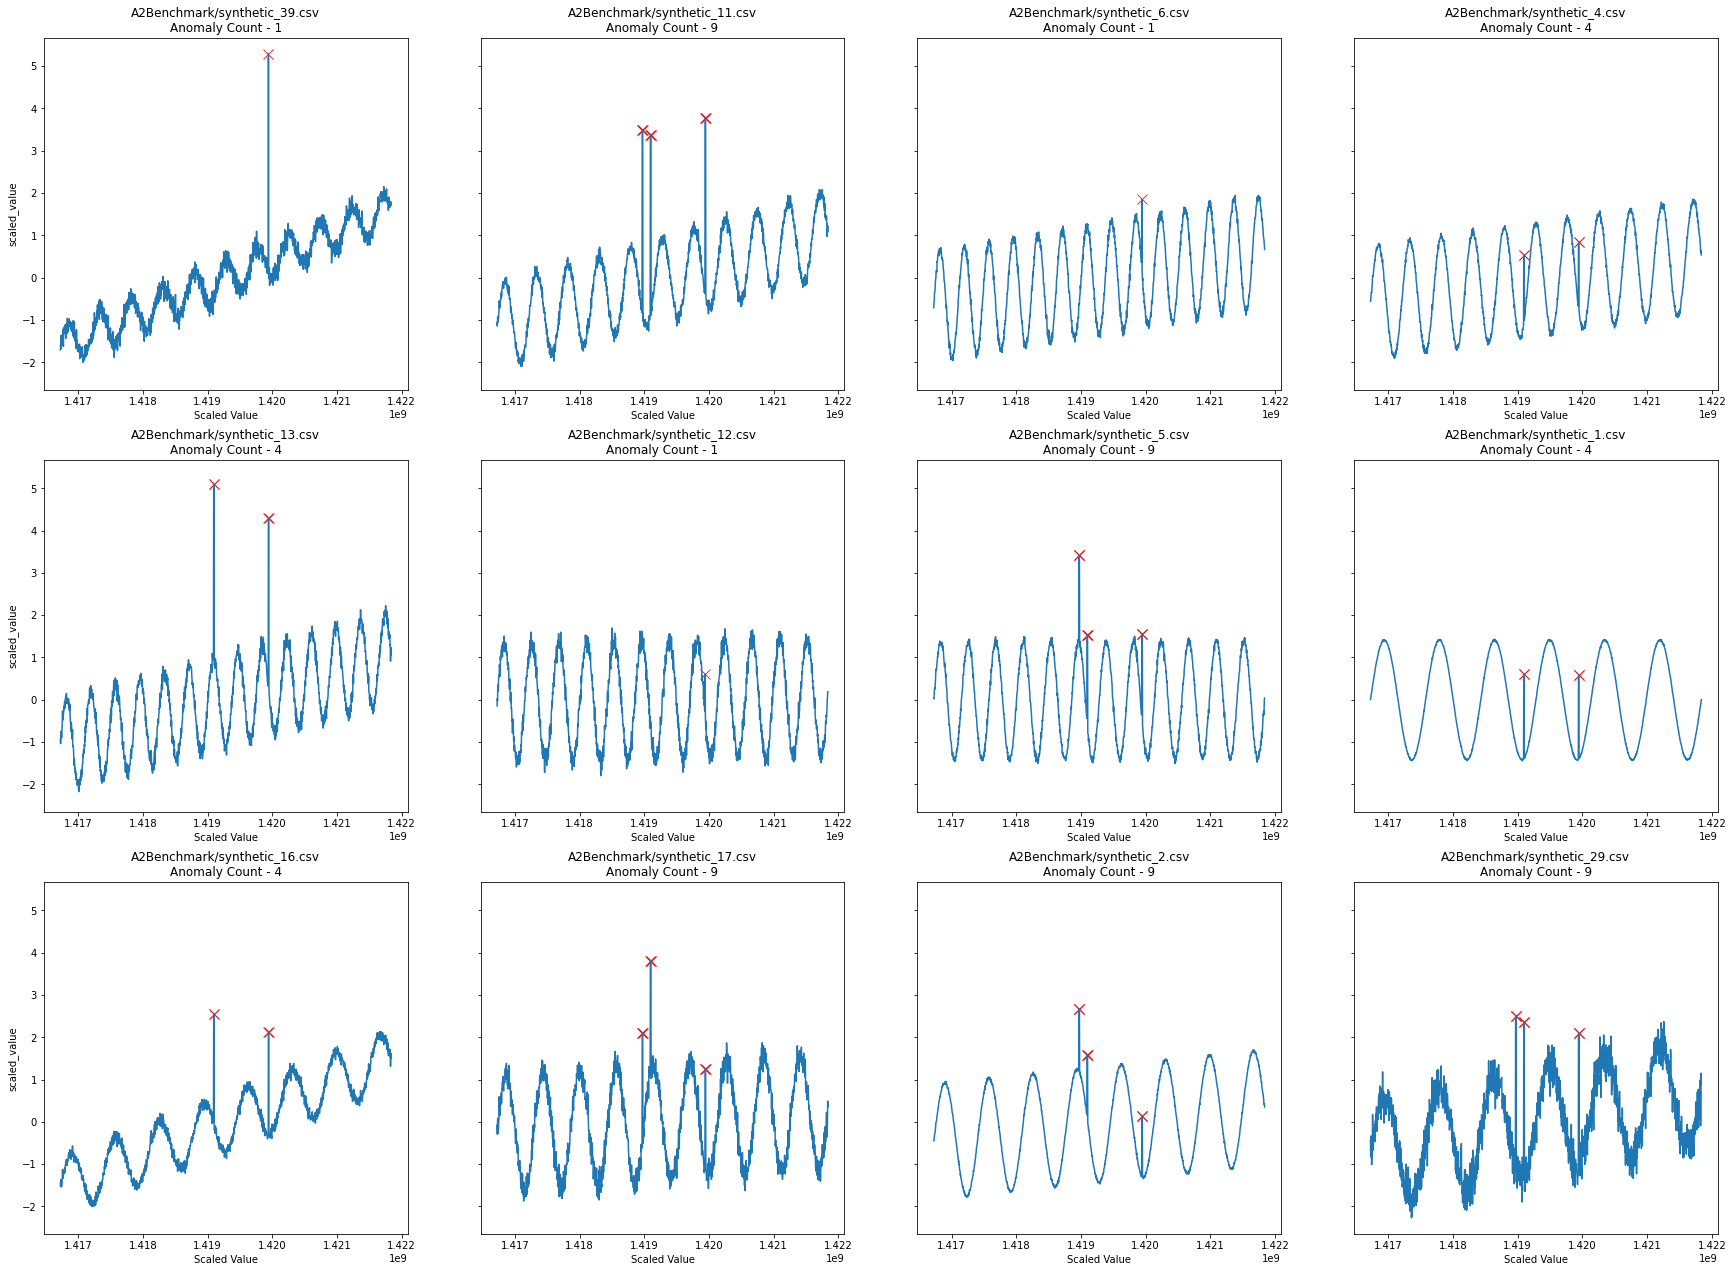

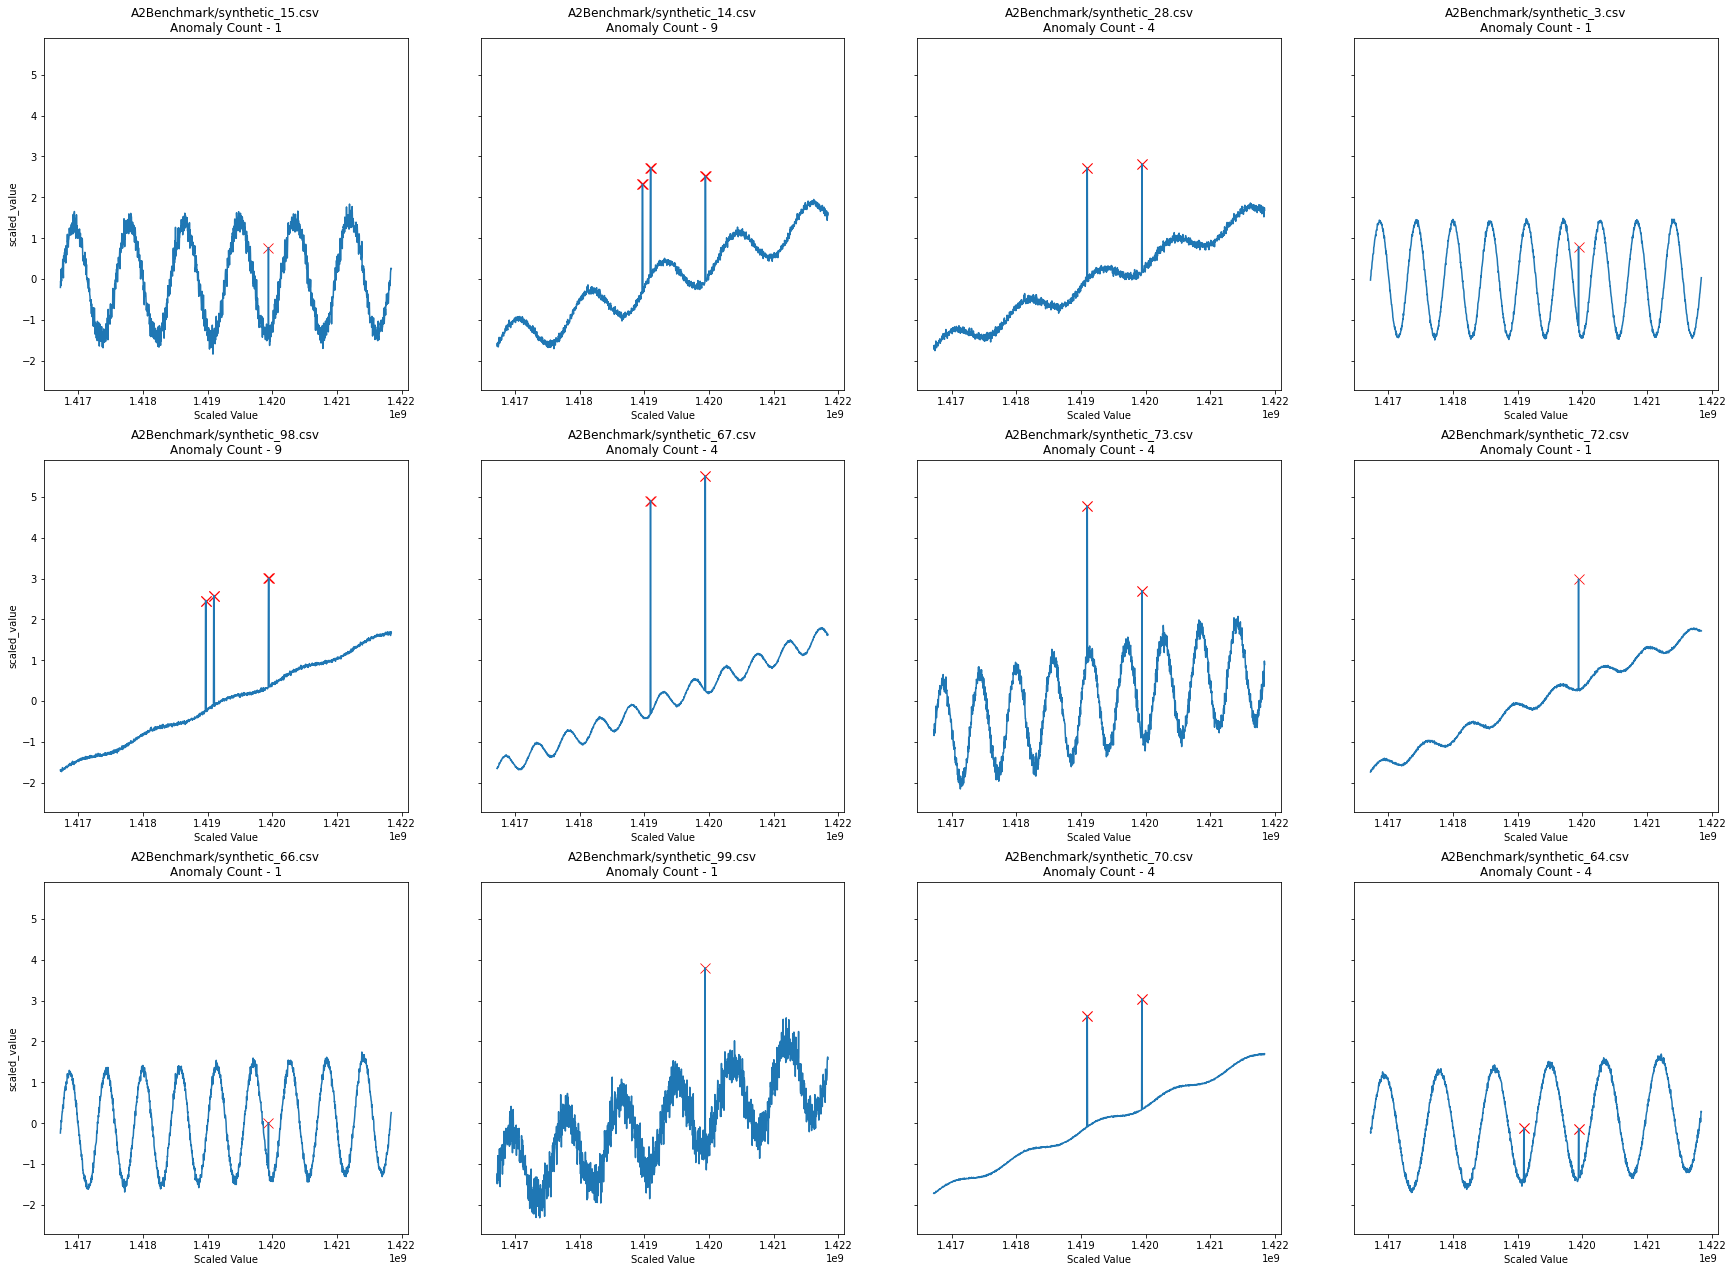

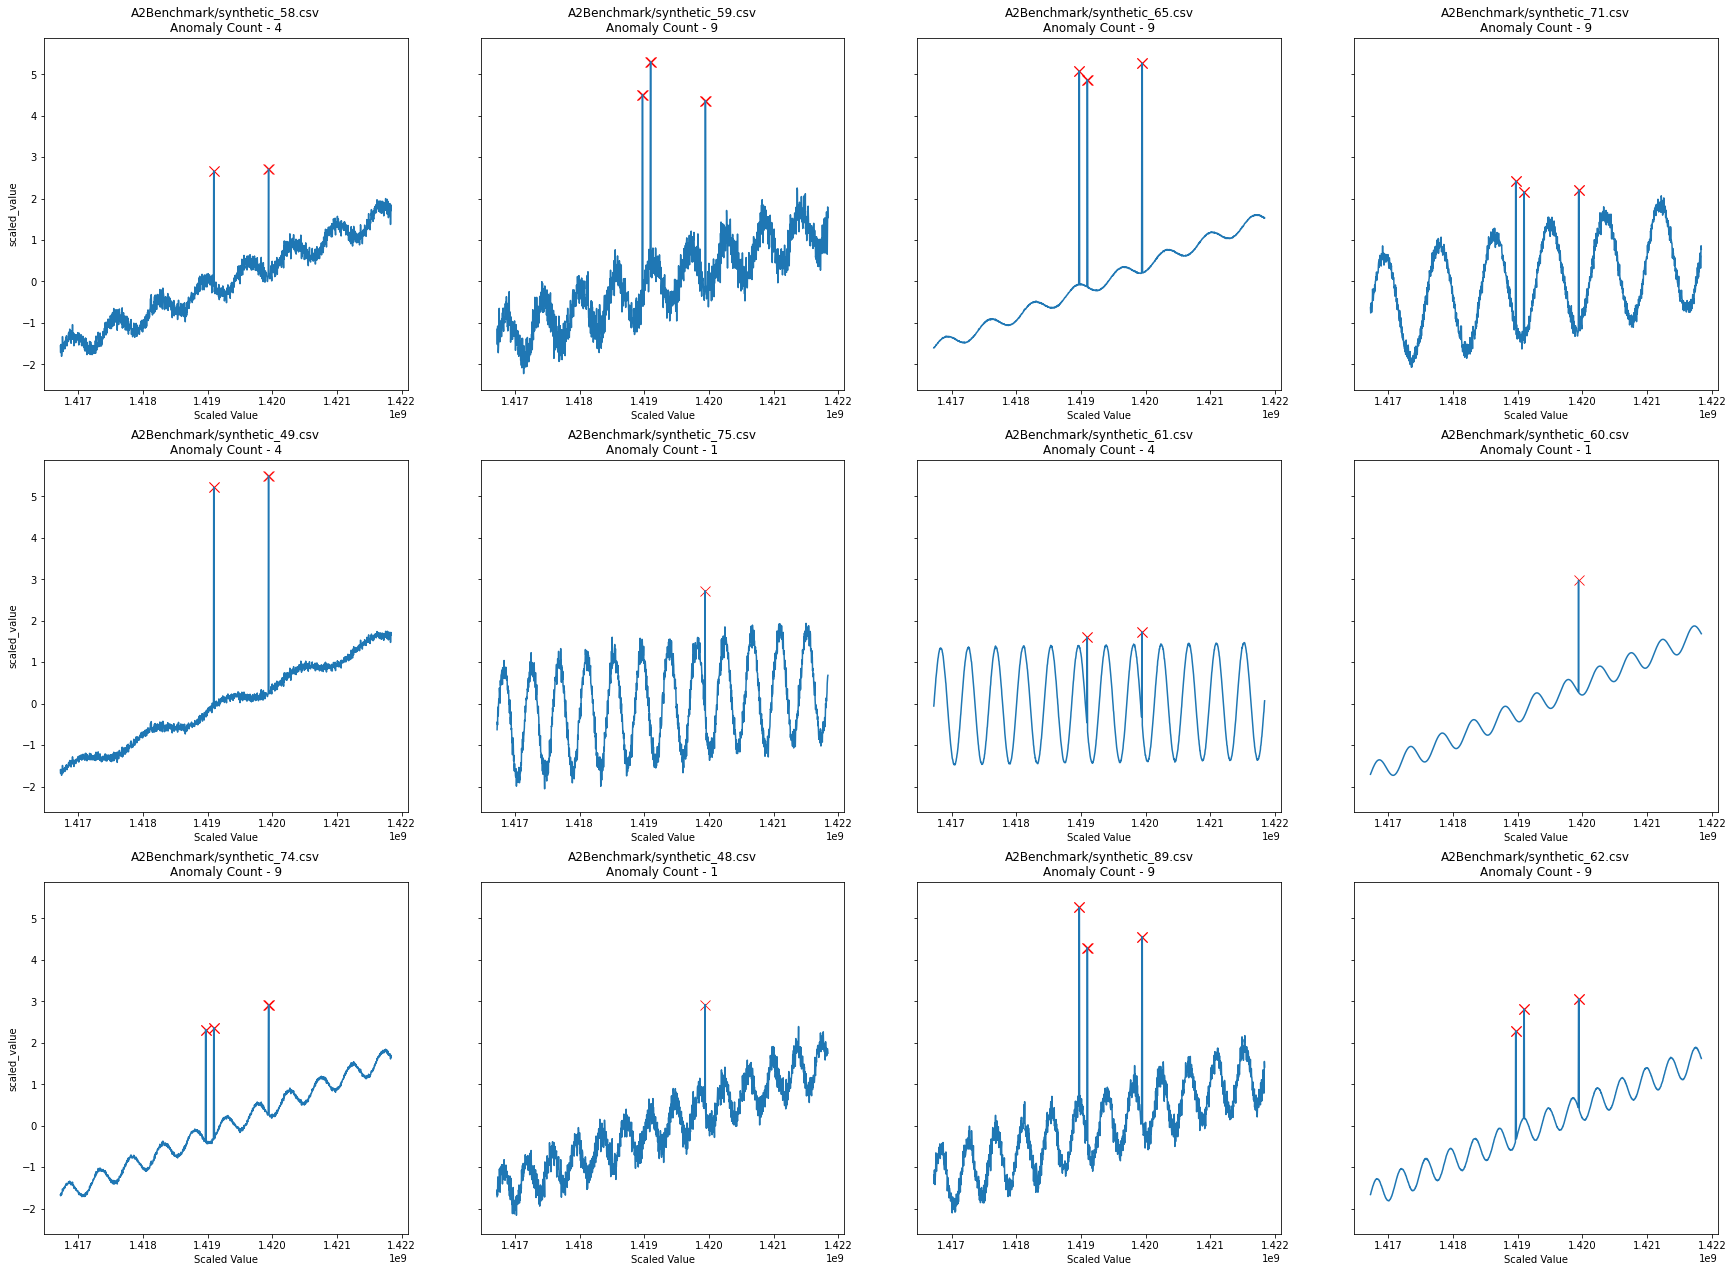

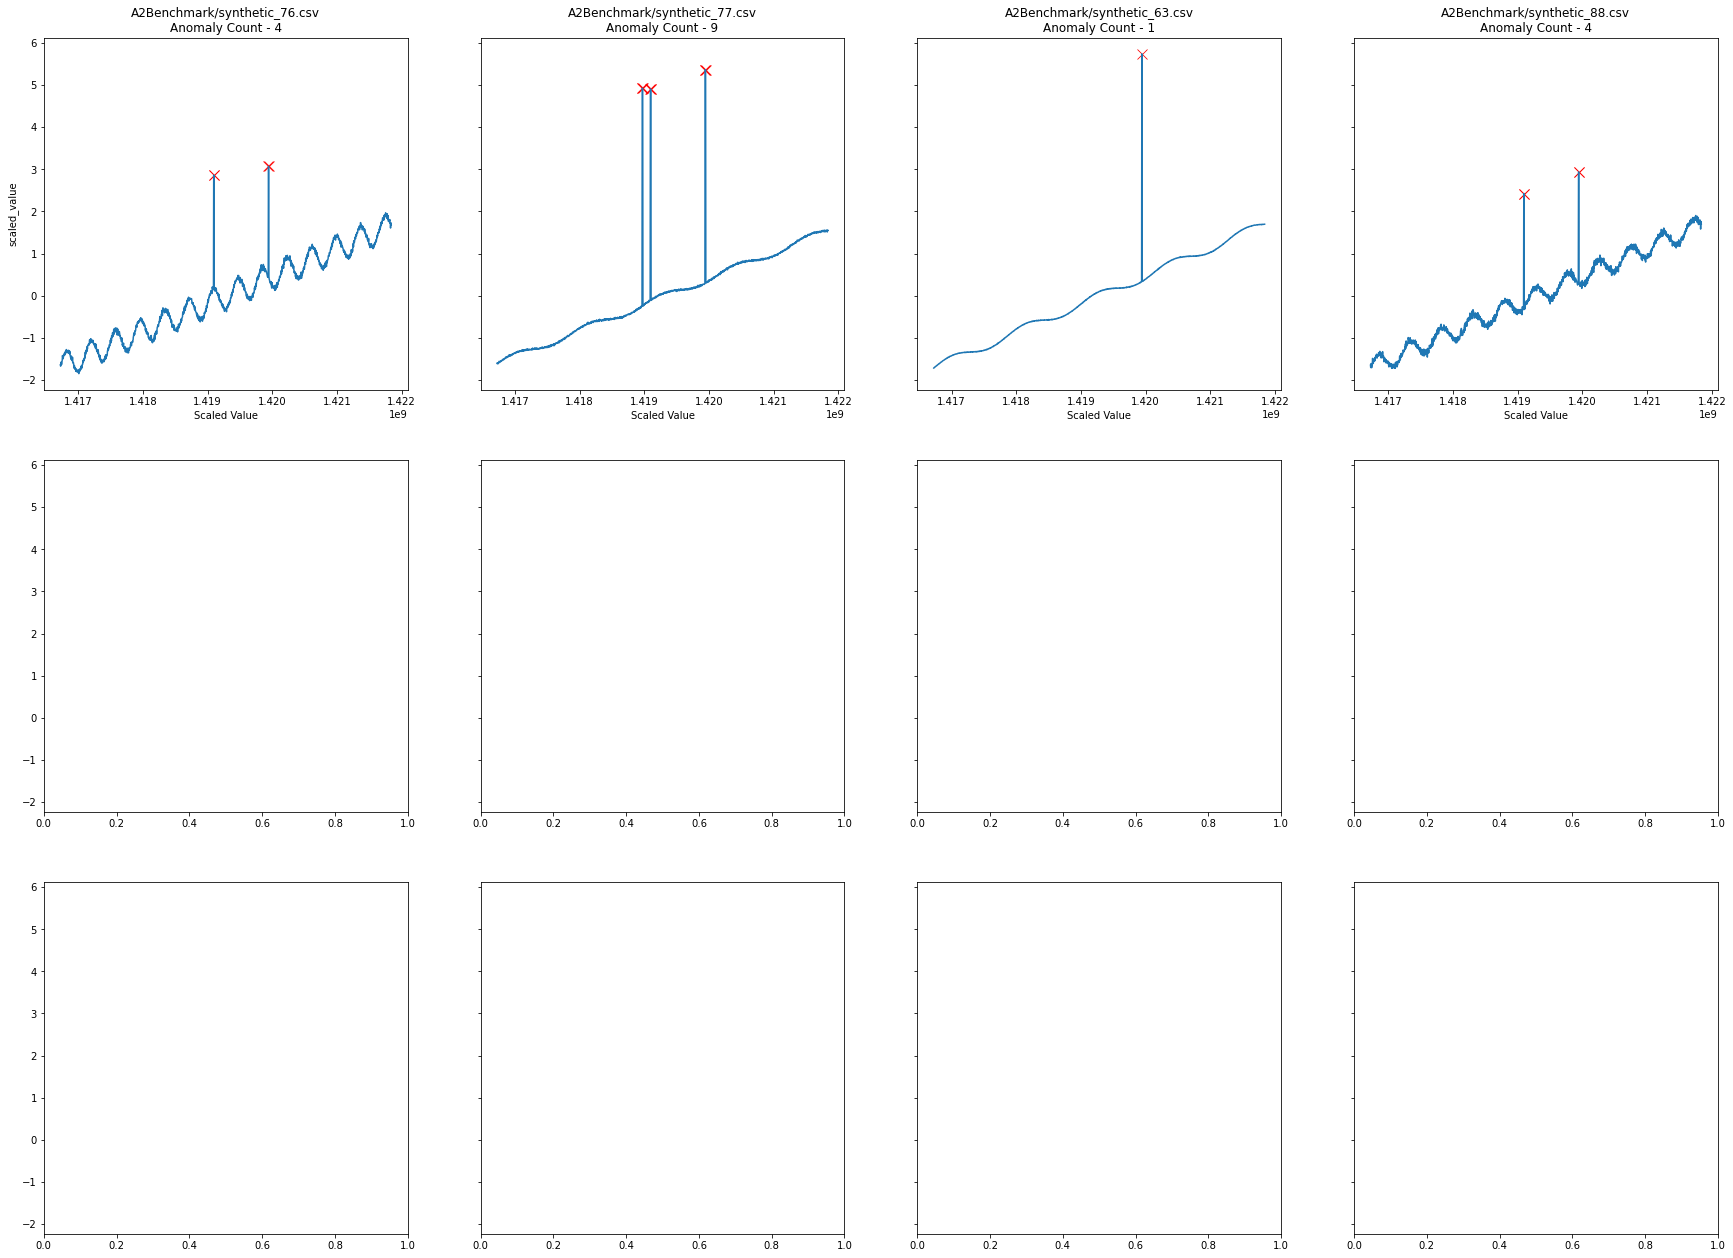

In [122]:
plotter(glob.glob('./datasets/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/*'))

***